## 🧾 Описание датасета IEEE Fraud Detection

Этот датасет был создан в рамках соревнования на Kaggle совместно с компанией **Vesta Corporation**, поставщиком решений для цифровой безопасности.  
**Цель:** спрогнозировать, является ли онлайн-транзакция мошеннической (целевая переменная `isFraud`).

---

## 📁 Структура датасета

### 🔹 Обучающая выборка
- `train_transaction.csv` — данные о транзакциях
- `train_identity.csv` — данные об устройстве, IP, браузере, ОС и пр., используемых во время транзакции

### 🔹 Тестовая выборка
- `test_transaction.csv`
- `test_identity.csv`

Обе таблицы соединяются по колонке `TransactionID`.

---

## 🎯 Целевая переменная
- `isFraud` — бинарный флаг:
  - `1`: транзакция — мошенническая
  - `0`: транзакция — легитимная

---

## 🧩 Признаки

### 📦 Transaction Features

| Признак           | Описание |
|-------------------|----------|
| `TransactionID`   | Уникальный ID транзакции |
| `TransactionDT`   | Временная метка (в секундах от некой базовой точки) |
| `TransactionAMT`  | Сумма транзакции (в долларах США) |
| `ProductCD`       | Код продукта |
| `card1`-`card6`   | Информация о платёжной карте: ID карты, тип, банк, страна и т.д. |
| `addr1`, `addr2`  | Географическая информация (адрес, штат и т.д.) |
| `dist1`, `dist2`  | Расстояние от пользователя до магазина или устройства |
| `P_emaildomain`, `R_emaildomain` | Email-домен покупателя и получателя |
| `C1`–`C14`        | Различные счётчики, связанные с транзакциями (например, кол-во карт, устройств, адресов) |
| `D1`–`D15`        | Временные дельты — количество дней с последней транзакции и т.д. |
| `M1`–`M9`         | Бинарные флаги сопоставления (например, совпадает ли адрес доставки и биллинга) |
| `V1`–`V339`       | Скрытые признаки, созданные системой Vesta (feature engineering) |

---

### 🧠 Identity Features

| Признак           | Описание |
|-------------------|----------|
| `DeviceType`      | Тип устройства (desktop / mobile) |
| `DeviceInfo`      | Информация об устройстве (например, модель или браузер) |
| `id_12`–`id_38`   | Признаки, связанные с IP, прокси, ISP, операционной системой и прочими параметрами пользователя. Их конкретное значение скрыто по соображениям конфиденциальности. |

---

## 🗃 Категориальные признаки

Некоторые из них:

- `ProductCD`
- `card1` – `card6`
- `addr1`, `addr2`
- `P_emaildomain`, `R_emaildomain`
- `M1` – `M9`
- `DeviceType`, `DeviceInfo`
- `id_12` – `id_38`

---

## ⚠ Особенности

- **Сильно несбалансированный датасет:** мошеннические транзакции — лишь малая часть выборки.
- **Псевдовременная метка (`TransactionDT`)** — может использоваться для создания временных признаков.
- **Много пропусков и выбросов** — важно тщательно обрабатывать данные.
- **Скрытые признаки `Vxxx`** — важно использовать отброс шума и методы отбора признаков.

# 0. Реализация вспомогательных функций

In [185]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import recall_score


def eval(model, X_val, y_val):
    # Предсказания вероятностей (например, predict_proba[:,1])
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]


    # Recall
    recall = recall_score(y_val, y_pred)
    print(f"Recall: {recall:.4f}")

    # ROC-AUC
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    print(f'ROC-AUC: {roc_auc:.4f}')

    # PR-AUC
    pr_auc = average_precision_score(y_val, y_pred_proba)
    print(f'PR-AUC: {pr_auc:.4f}')

    # --- ROC-AUC ---
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # диагональ
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # --- PR-AUC ---
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = average_precision_score(y_val, y_pred_proba)

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.4f})', color='green')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

## 1. Загрузка данных и базовая очистка

In [29]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# Путь к данным
PATH_TRANSACTION = '../data/ieee-fraud-detection/train_transaction.csv'
PATH_IDENTITY = '../data/ieee-fraud-detection/train_identity.csv'

# Загрузка данных
transaction = pd.read_csv(PATH_TRANSACTION)
identity = pd.read_csv(PATH_IDENTITY)

print(f"Размер train_transaction: {transaction.shape}")
print(f"Размер train_identity: {identity.shape}")

# Объединяем по TransactionID
train = transaction.merge(identity, how='left', on='TransactionID')

print(f"Итоговый размер train: {train.shape}")

# Быстрый осмотр данных
print(train.head())


Размер train_transaction: (590540, 394)
Размер train_identity: (144233, 41)
Итоговый размер train: (590540, 434)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0  

### Базовая очистка данных

In [30]:
# 3. Удаление признаков с более чем 95% пропусков
missing_frac = train.isnull().mean()
cols_to_drop = missing_frac[missing_frac > 0.95].index.tolist()
train.drop(columns=cols_to_drop, inplace=True)
print(f'Удалено {len(cols_to_drop)} признаков с >95% пропусков.')

Удалено 9 признаков с >95% пропусков.


In [31]:
# 4. Приведение типов
# Категориальные признаки, которые явно известны
categorical_features = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
    'DeviceType', 'DeviceInfo'
]

# identity категориальные признаки
identity_categoricals = [col for col in train.columns if col.startswith('id_')]
categorical_features += identity_categoricals

# M-признаки — бинарные (но иногда могут быть NaN)
m_features = [col for col in train.columns if col.startswith('M')]
categorical_features += m_features

# Оставляем только те, что остались в train
categorical_features = [col for col in categorical_features if col in train.columns]

# Каст категориальных в str/categorical
for col in categorical_features:
    train[col] = train[col].astype('category')

In [32]:
# 5. Обработка пропусков
# Для категориальных: пропуски → 'unknown'
for col in categorical_features:
    train[col] = train[col].cat.add_categories('unknown').fillna('unknown')

# Числовые оставляем с NaN для анализа
numeric_features = train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 6. Базовая проверка
print(f'Финальная форма данных: {train.shape}')
print(f'Число категориальных признаков: {len(categorical_features)}')
print(f'Число числовых признаков: {len(numeric_features)}')

train.head()

Финальная форма данных: (590540, 425)
Число категориальных признаков: 51
Число числовых признаков: 374


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

     card2  card3       card4  card5  ...                id_31    id_32  \
0  unknown  150.0    discover  142.0  ...              unknown  unknown   
1    404.0  150.0  mastercard  102.0  ...              unknown  unknown   
2    490.0  150.0        visa  166.0  ...              unknown  unknown   
3    567.0  150.0  mastercard  117.0  ...              unknown  unknown   
4    514.0  150.0  mastercard  102.0  ...  samsung browser 6.2     32.0   

       id_33           id_34    id_35    id_36    id_37    id_38  DeviceType  \
0    unknown         unknown  unknown  unknown  unknown  unknown     unknown   
1    unknown         unknown  unknown  unknown  unknown  unknown     unknown   
2    unknown         unknown  unknown  unknown  unknown  unknown     unknown   
3    unknown         unknown  unknown  unknown  unknown  unknown     unknown   
4  2220x1080  match_status:2        T        F        T        T      mobile   

                      DeviceInfo  
0                        unknown  
1                        unknown  
2                        unknown  
3                        unknown  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 425 columns]

In [33]:
train['TransactionDT'].head()

0    86400
1    86401
2    86469
3    86499
4    86506
Name: TransactionDT, dtype: int64

In [ ]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Чтобы красиво отображались графики
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
#plt.style.use("seaborn-dark")

## 2. Обзор признаков - Корреляционная матрица

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Посмотрим распределение целевой переменной
print(train['isFraud'].value_counts(normalize=True))

# Выберем только числовые признаки для корреляции
numeric_features = train.select_dtypes(include=[np.number])

# Посчитаем корреляцию с целевой переменной
correlation_matrix = numeric_features.corr()

# Корреляция признаков с целевой переменной
cor_target = correlation_matrix['isFraud'].sort_values(ascending=False)
print("Топ признаков, наиболее коррелирующих с isFraud:\n", cor_target.head(15))


isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64
Топ признаков, наиболее коррелирующих с isFraud:
 isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
V45        0.281832
V158       0.278066
V156       0.275952
V149       0.273282
V228       0.268861
Name: isFraud, dtype: float64


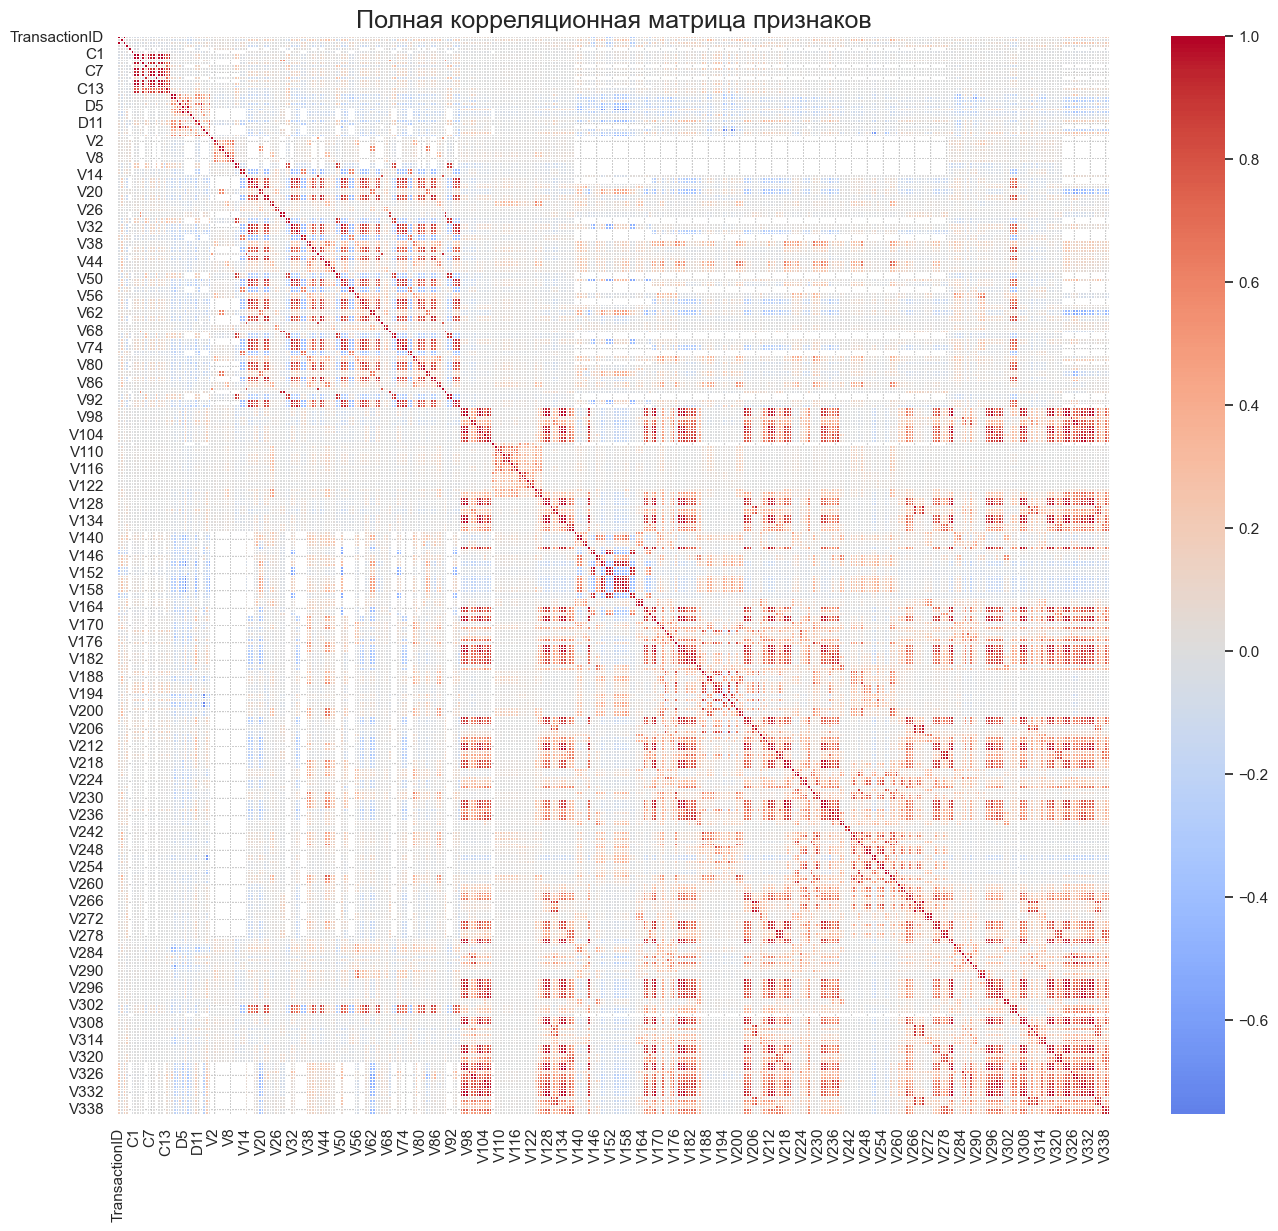

In [36]:
# Тепловая карта всей корреляционной матрицы
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Полная корреляционная матрица признаков', fontsize=18)
plt.show()

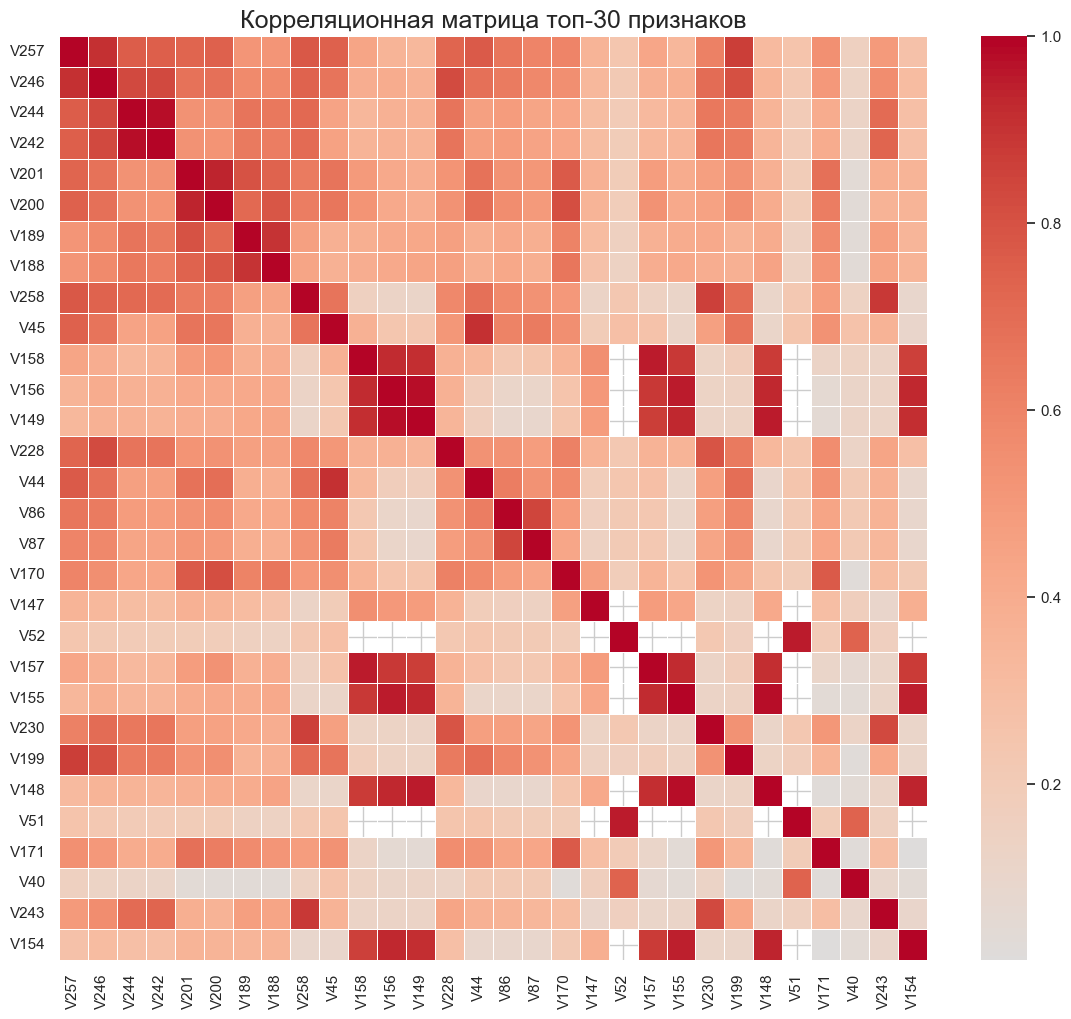

In [37]:
# Дополнительно: тепловая карта только топ-30 признаков
top_features = cor_target.index[1:31]  # исключаем сам isFraud
plt.figure(figsize=(14, 12))
sns.heatmap(train[top_features].corr(), cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title('Корреляционная матрица топ-30 признаков', fontsize=18)
plt.show()

Как мы видимо, сильно коррелируемые фияи трудно интерпретируемы

## Расширенный EDA для антифрод-датасета

### 1. Базовое описание данных

In [38]:
numeric_features = train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Размеры датасета
print(f'Размеры датасета: {train.shape[0]} строк, {train.shape[1]} признаков.')

# Доли классов
print(train['isFraud'].value_counts(normalize=True))

# Доля пропусков по признакам
missing_values = train.isnull().mean().sort_values(ascending=False)
print(missing_values[missing_values > 0])

# Типы признаков
print('Категориальные признаки:', len(categorical_features))
print('Числовые признаки:', len(numeric_features))


Размеры датасета: 590540 строк, 425 признаков.
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64
dist2    0.936284
D7       0.934099
D13      0.895093
D14      0.894695
D12      0.890410
           ...   
V309     0.000020
V308     0.000020
V307     0.000020
V279     0.000020
V305     0.000020
Length: 356, dtype: float64
Категориальные признаки: 51
Числовые признаки: 374


### 2.Анализ признака TransactionDT

> Важно! Так как `TransactionDT` - Временная метка (в секундах от некой базовой точки), то преобразования в новые признаки условное.

#### Нормализовать временные метки


Так как мы не знаем точной базовой точки, можно нормализовать временные метки, приведя их к более понятному формату. Например, мы можем посчитать, сколько прошло времени от самой первой транзакции и работать с этим диапазоном.

In [53]:
# Найдем минимальное значение
min_timestamp = train['TransactionDT'].min()

# Преобразуем временные метки относительно минимальной
train['Relative_TransactionDT'] = train['TransactionDT'] - min_timestamp

# Преобразуем в дни, часы, минуты и т.д.
train['Transaction_day'] = train['Relative_TransactionDT'] // (24 * 60 * 60)  # в днях
train['Transaction_hour'] = (train['Relative_TransactionDT'] // 3600) % 24  # в часах
train['Transaction_weekday'] = (train['Relative_TransactionDT'] // (3600*24)) % 7
train['Transaction_day'] = train['Transaction_day'].astype(int)
train['Transaction_hour'] = train['Transaction_hour'].astype(int)
train['Transaction_weekday'] = train['Transaction_weekday'].astype(int)

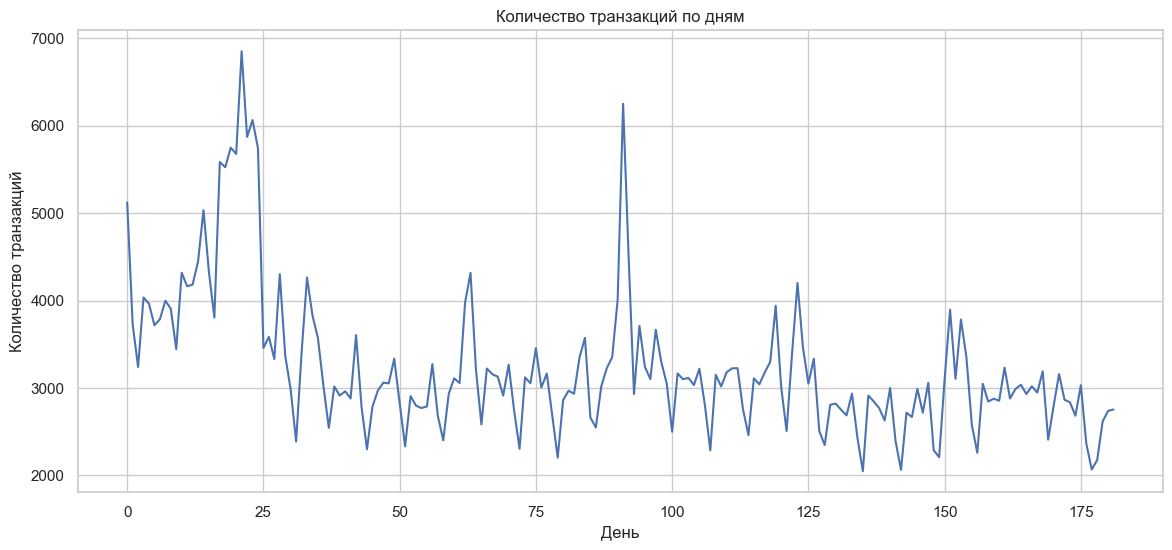

In [203]:
# Конвертация TransactionDT в дни
#train['Transaction_day'] = train['TransactionDT'] / (24 * 60 * 60)
#train['Transaction_day'] = train['Transaction_day'].astype(int)

# Количество транзакций во времени
plt.figure(figsize=(14,6))
train.groupby('Transaction_day').size().plot()
plt.title('Количество транзакций по дням')
plt.xlabel('День')
plt.ylabel('Количество транзакций')
plt.show()

#### График: Количество транзакций по дням

1. **Тренды и Пики:**
   - Наблюдаются несколько пиков, особенно в начале периода и ближе к середине.
   - Присутствует высокая изменчивость в количестве транзакций.
 
2. **Сезонность:**
   - Возможные периоды увеличения активности, что может быть связано с внешними факторами, например, акциями или праздниками.
  
3. **Общий Уровень:**
   - Тренд показывает небольшое снижение активности после первой половины, что может указывать на изменения в операционной среде или структуре данных.


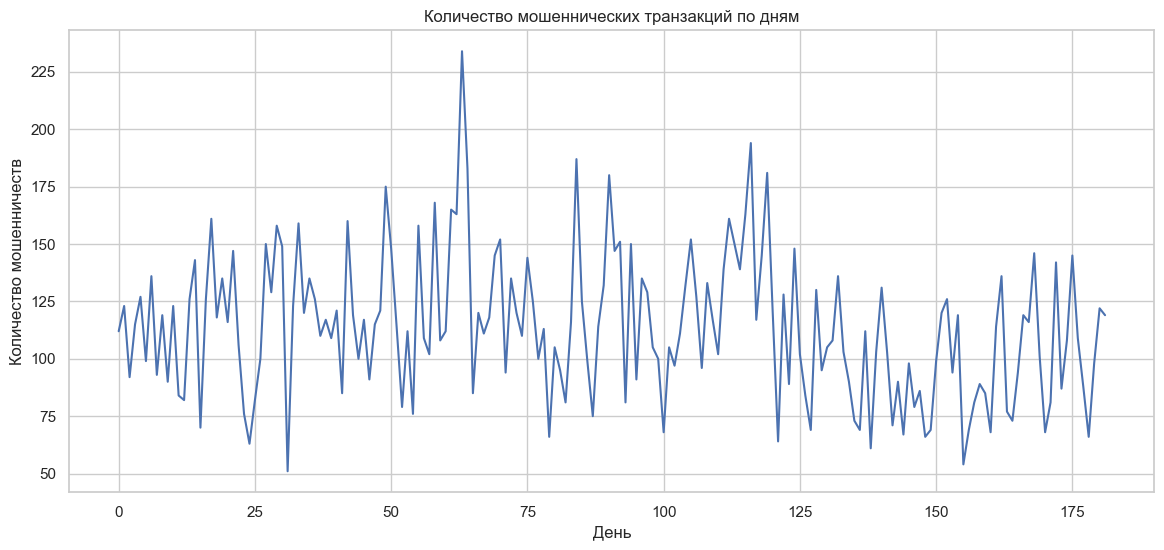

In [204]:
# Количество мошенничеств во времени
plt.figure(figsize=(14,6))
train[train['isFraud'] == 1].groupby('Transaction_day').size().plot()
plt.title('Количество мошеннических транзакций по дням')
plt.xlabel('День')
plt.ylabel('Количество мошенничеств')
plt.show()


#### График: Количество мошеннических транзакций по дням

1. **Тренды и Пики:**
   - Наблюдаются частые колебания в количестве мошеннических транзакций, но, в отличие от общего числа транзакций, их уровень более стабильный.

2. **Сезонность и Корреляция:**
   - Сезонные пики совпадают с общим графиком транзакций, что может указывать на то, что увеличение общего количества транзакций сопутствует и мошеннической активности.

3. **Общий Уровень:**
   - Явная волатильность свидетельствует о непредсказуемости мошеннических действий, хотя в целом показатели имеют тенденцию к снижению в течение времени.


### Общий вывод

- **Сопоставление графиков:** Пики и спады в количестве транзакций и мошеннических операций часто совпадают, указывая на возможную взаимосвязь между общим объемом транзакций и мошеннической активностью.
- **Возможные внешние влияния:** Стоит учитывать влияние сезонных факторов или маркетинговых кампаний, которые могут влиять на активность транзакций.

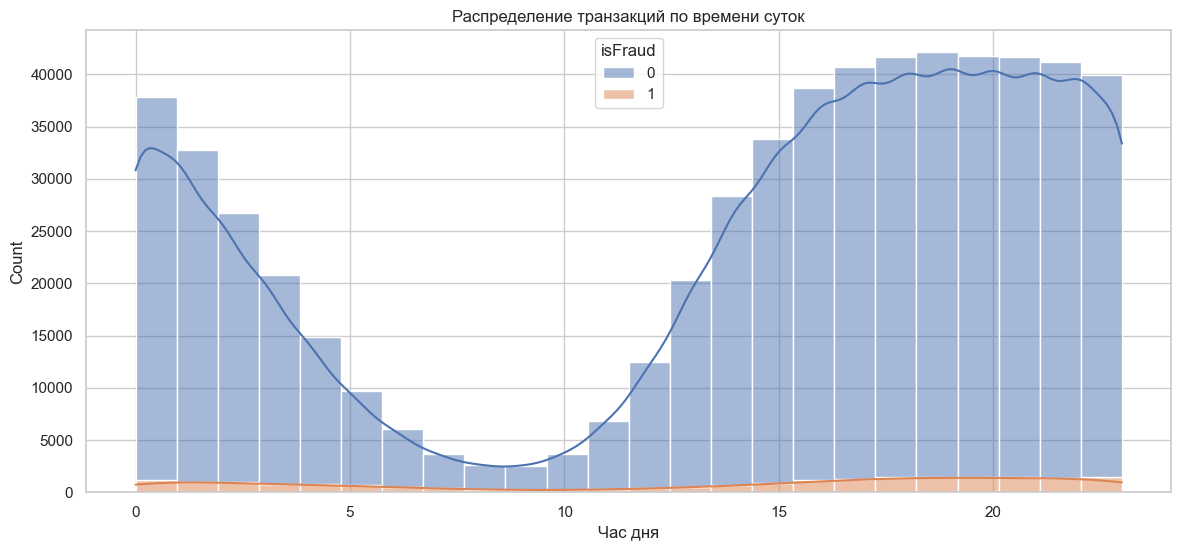

In [205]:
# Время суток
#train['Transaction_hour'] = (train['TransactionDT'] / 3600) % 24

plt.figure(figsize=(14,6))
sns.histplot(data=train, x='Transaction_hour', hue='isFraud', bins=24, kde=True, multiple='stack')
plt.title('Распределение транзакций по времени суток')
plt.xlabel('Час дня')
plt.show()

### Анализ графика распределения транзакций по времени суток

1. **Общая активность:**
   - Наибольшее количество транзакций происходит в вечерние и ночные часы (пик около 16-23 часов).
   - Самое низкое количество транзакций наблюдается около 6-10 часов утра.

2. **Мошеннические транзакции:**
   - Хотя количество мошеннических транзакций значительно ниже общего числа транзакций, их распределение по времени суток похоже на распределение обычных транзакций.
   - Мошеннические активности также снижаются утром и увеличиваются вечером.

3. **Интерпретации:**
   - Активность пользователей и, возможно, мошенническая активность связаны с суточной активностью людей, как в рабочее, так и в нерабочее время.
   - Необходимы дополнительные исследования, чтобы определить, связаны ли пики мошенничества с особыми событиями или условиями.

In [43]:
train[['TransactionDT', 'Relative_TransactionDT','Transaction_day', 'Transaction_hour']]

TransactionDT  Relative_TransactionDT  Transaction_day  \
0               86400                       0                0   
1               86401                       1                0   
2               86469                      69                0   
3               86499                      99                0   
4               86506                     106                0   
...               ...                     ...              ...   
590535       15811047                15724647              181   
590536       15811049                15724649              181   
590537       15811079                15724679              181   
590538       15811088                15724688              181   
590539       15811131                15724731              181   

        Transaction_hour  
0               0.000000  
1               0.000278  
2               0.019167  
3               0.027500  
4               0.029444  
...                  ...  
590535         23.957500  
590536         23.958056  
590537         23.966389  
590538         23.968889  
590539         23.980833  

[590540 rows x 4 columns]

### 3. Анализ целевой переменной isFraud

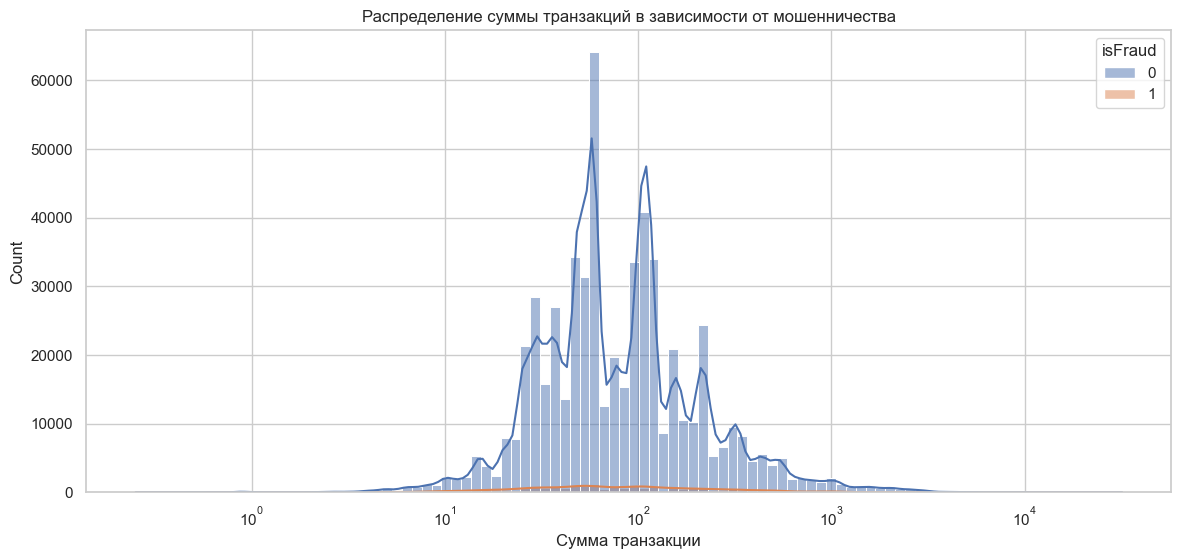

Топ-10 признаков по корреляции с isFraud:
V257    0.383060
V246    0.366878
V244    0.364129
V242    0.360590
V201    0.328005
V200    0.318783
V189    0.308219
V188    0.303582
V258    0.297151
V45     0.281832
Name: isFraud, dtype: float64


In [11]:
# Распределение сумм транзакций
plt.figure(figsize=(14,6))
sns.histplot(data=train, x='TransactionAmt', hue='isFraud', bins=100, log_scale=True, kde=True)
plt.title('Распределение суммы транзакций в зависимости от мошенничества')
plt.xlabel('Сумма транзакции')
plt.show()

# Топ-10 признаков по корреляции с isFraud
fraud_corr = train[numeric_features].corr()['isFraud'].drop('isFraud').abs().sort_values(ascending=False)
print('Топ-10 признаков по корреляции с isFraud:')
print(fraud_corr.head(10))


**Описание графика**

Ось X (логарифмическая шкала) — это сумма транзакции (TransactionAmt). Сразу видно, что большинство транзакций сосредоточены в диапазоне от примерно 10 до 1000 единиц.

Ось Y — это количество транзакций.

Цвета:
- Синие столбцы — обычные транзакции (isFraud = 0).
- Оранжевая линия/заливка (еле видная) — мошеннические транзакции (isFraud = 1).

Что видно:
- Обычных транзакций очень много по сравнению с мошенническими.
- Распределение транзакций сильно скошено вправо (много маленьких сумм, мало больших).
- Мошеннические транзакции встречаются реже и скорее всего имеют свои "специфические" диапазоны сумм, хотя визуально их не видно на фоне всех транзакций.


**Краткий вывод по графику**:

- Большинство транзакций — на небольшие суммы.
- Мошеннические транзакции — редкие и тонут в основном распределении.

### 4. Анализ категориальных признаков

### Анализ признака ProductCD


Анализ признака: ProductCD
ProductCD
W          0.744522
C          0.116028
R          0.063838
H          0.055922
S          0.019690
unknown    0.000000
Name: proportion, dtype: float64


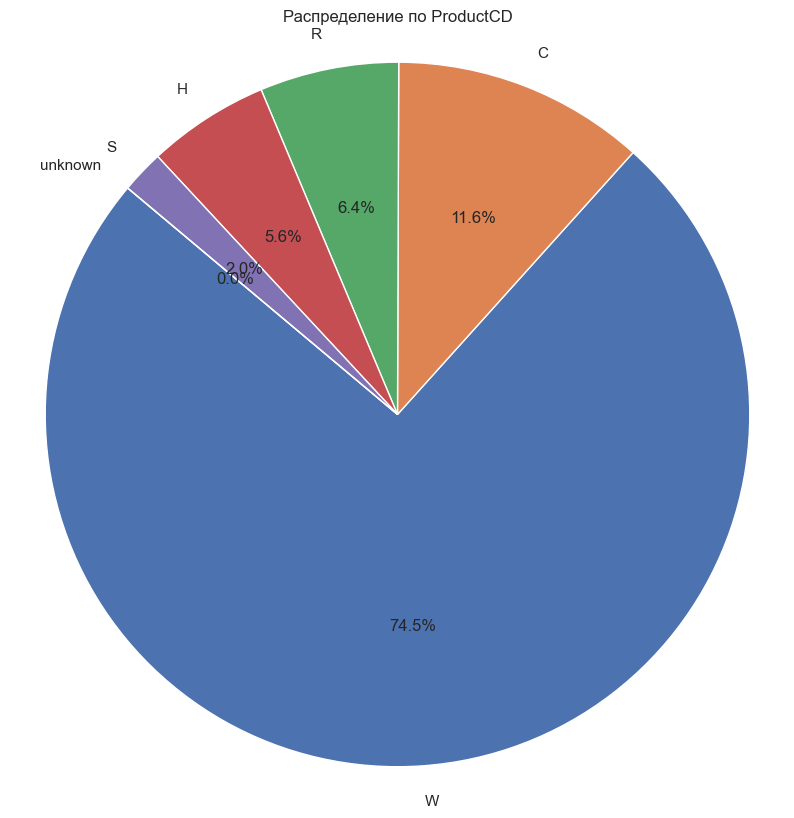

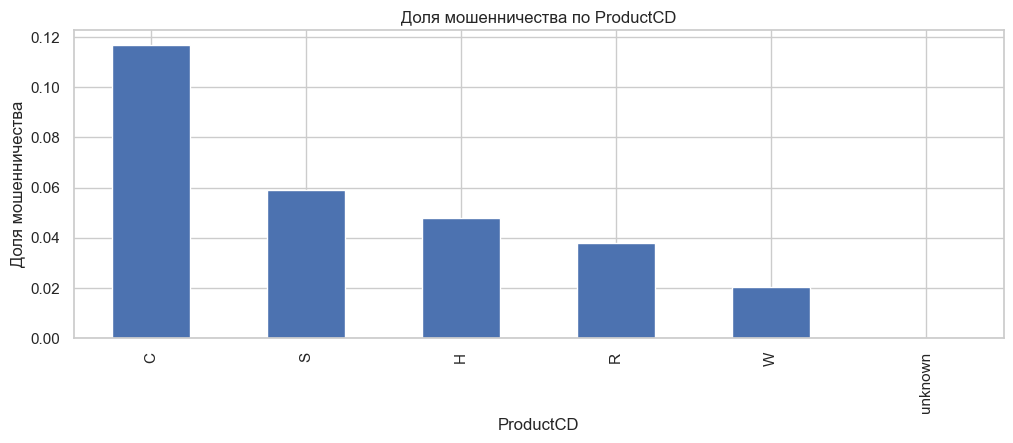

In [103]:
col = 'ProductCD'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()


fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()


#### 1. Распределение транзакций по ProductCD
- Большинство транзакций относятся к типу **W** — **74.45%** всех операций.
- На втором месте — **C** (**11.60%**), затем идут **R** (**6.38%**), **H** (**5.59%**) и **S** (**1.97%**).
- Категория **unknown** отсутствует (0%).

**Вывод**: транзакции крайне неравномерно распределены между различными ProductCD. Большую часть составляют операции типа **W**.

---

#### 2. Доля мошенничества по ProductCD (анализ графика)
На графике показана **доля мошеннических операций** внутри каждой категории:

- **Наивысшая доля мошенничества** наблюдается у ProductCD **C** (~12%).
- Далее идут **S**, **H** и **R** — их доли мошенничества постепенно уменьшаются.
- У **W**, несмотря на огромное количество транзакций, **доля мошенничества минимальна** (~2%).
- Для **unknown** доля мошенничества равна нулю.

**Вывод**:
- Типы продуктов **C**, **S**, **H** и **R** более подвержены мошенничеству, чем **W**.
- Особенно стоит обратить внимание на **C** — хотя он встречается реже, риск мошенничества в нём высокий.
- **W** — массовый продукт с наименьшим риском мошенничества.

---

#### 3. Итого:
- При построении модели для предсказания мошенничества можно учитывать категорию **ProductCD** как важный признак.
- Категории с высокой долей мошенничества (**C**, **S**) могут иметь повышенный вес или более строгую проверку.
- Категории с низкой долей мошенничества (**W**) могут снижать вероятность классификации транзакции как мошеннической.

### Анализ признака  card1


Анализ признака: card1
card1
7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
12695    0.012008
12544    0.011469
6019     0.011466
2803     0.010399
7585     0.009032
Name: proportion, dtype: float64


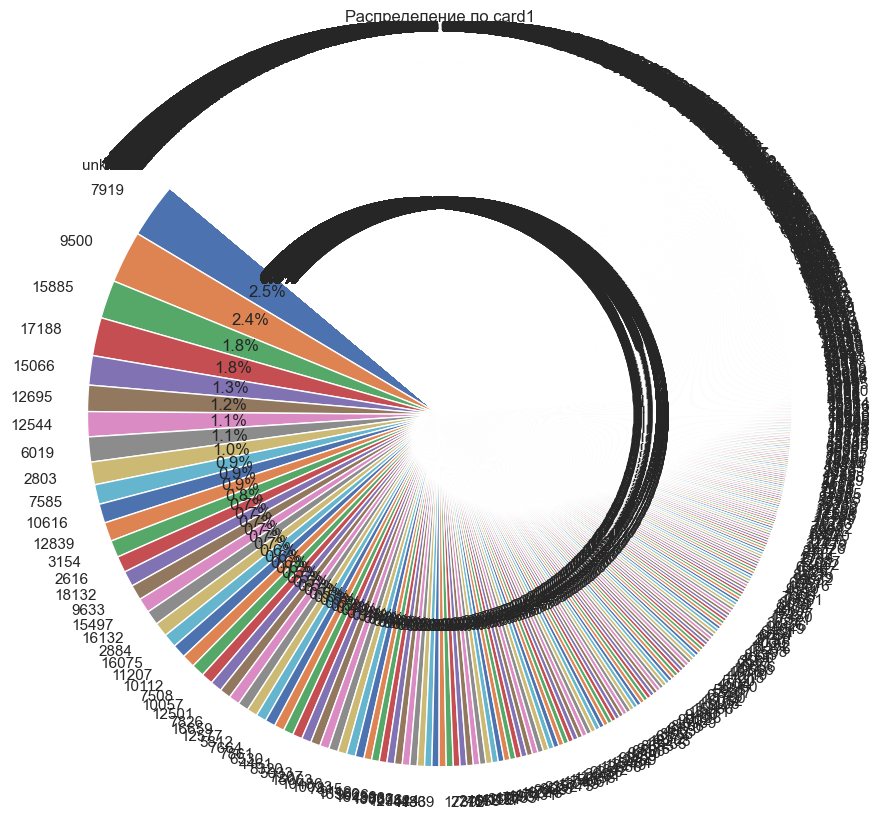

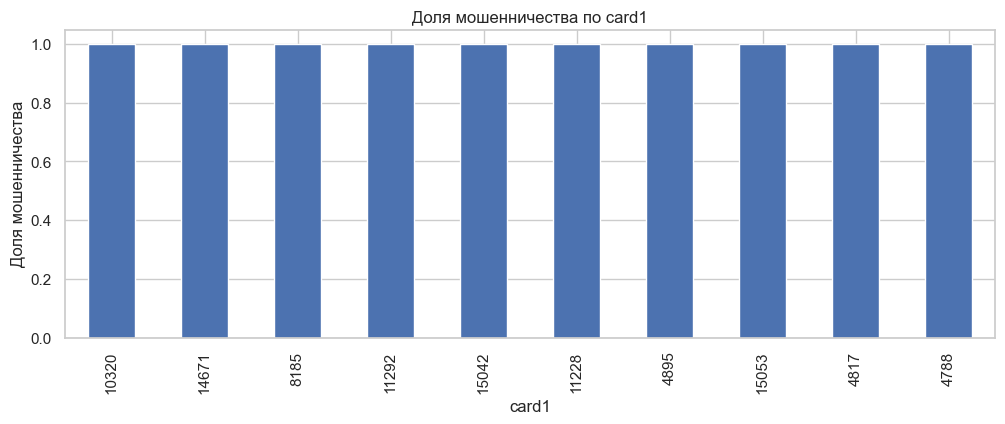

In [104]:
col = 'card1'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()


fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика "Доля мошенничества по card1"

1. **Равномерная доля мошенничества:**
   - График показывает, что доля мошеннических транзакций для каждой из представленных карт примерно одинакова. Это указывает на отсутствие явных аномалий или специфичных карт с высоким уровнем риска.

2. **Визуальное различие:**
   - Незначительные различия между картами указывают на то, что по этому признаку не удастся точно выделить мошеннические действия.

3. **Интерпретация данных:**
   - Это может свидетельствовать о том, что `card1` как отдельный признак не является сильным индикатором мошенничества. Необходимо комбинировать его с другими признаками для повышения эффективности модели.

4. **Нет доминирующих аномалий:**
   - Отсутствие резкого пика говорит о том, что ни одна из категорий `card1` не выбивается в плане анормально высокого уровня мошенничества.

### Варианты использования признака:

- **Комбинация признаков:** Исследовать сочетания `card1` с другими признаками, чтобы выявить потенциальные скрытые зависимости.
  
- **Feature Engineering:** Создать дополнительные признаки, такие как взаимодействия с другими категориями (`card2`, `addr1`, и т.д.).

- **Сегментация:** Исследовать временные изменения в доле мошенничества, что может выявить неизвестные паттерны.

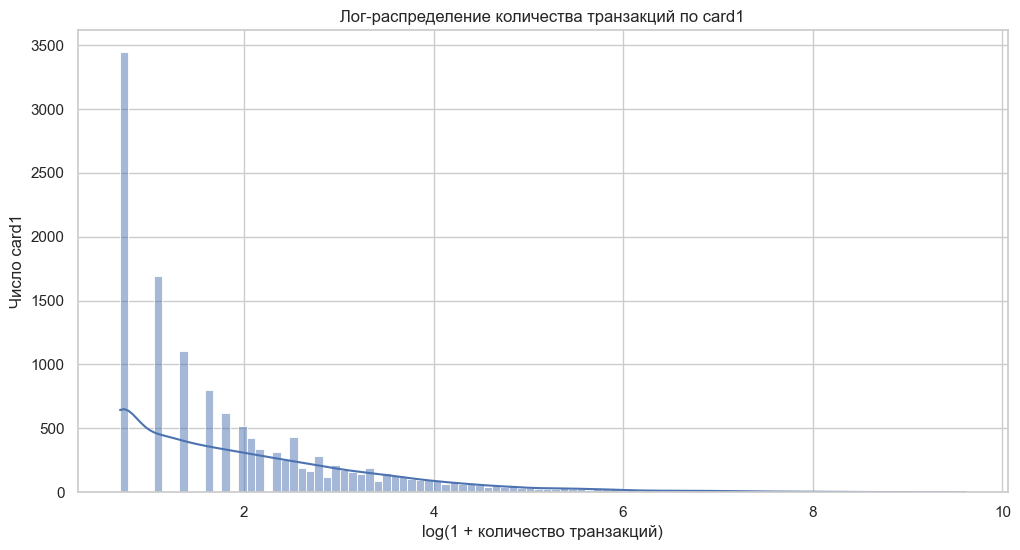

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Считаем количество транзакций по каждому card1
card1_counts = train['card1'].value_counts()

# Чтобы избежать проблем с "unknown" (где 0 транзакций)
card1_counts = card1_counts[card1_counts > 0]

# Логарифмируем количество транзакций для более наглядного графика
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(card1_counts), bins=100, kde=True)
plt.title('Лог-распределение количества транзакций по card1')
plt.xlabel('log(1 + количество транзакций)')
plt.ylabel('Число card1')
plt.grid(True)
plt.show()


### Выводы по графику лог-распределения количества транзакций по `card1`

1. **Сильная скошенность влево:**
   - Большинство карт имеет небольшое количество транзакций, что типично для распределений с длинным хвостом.

2. **Длинный хвост:**
   - Небольшое количество карт используется очень активно, что может указывать на определенные поведенческие паттерны или риск мошенничества.

3. **Аномалии в активности:**
   - Карты с чрезмерно высоким числом транзакций могут быть исследованы на предмет аномального или подозрительного поведения.

4. **Требуется дополнительное исследование:**
   - Важно проанализировать временные и контекстуальные аспекты использования этих карт, чтобы лучше понять природу активности и связанный с ней риск.

5. **Разработка признаков:**
   - Возможно создание новых признаков, таких как "частота транзакций", для повышения точности моделей анти-фрода.

### Анализ признака card2


Анализ признака: card2
card2
321.0    0.082865
111.0    0.076525
555.0    0.071113
490.0    0.064593
583.0    0.036920
170.0    0.030843
194.0    0.028682
545.0    0.027695
360.0    0.025722
514.0    0.024623
Name: proportion, dtype: float64


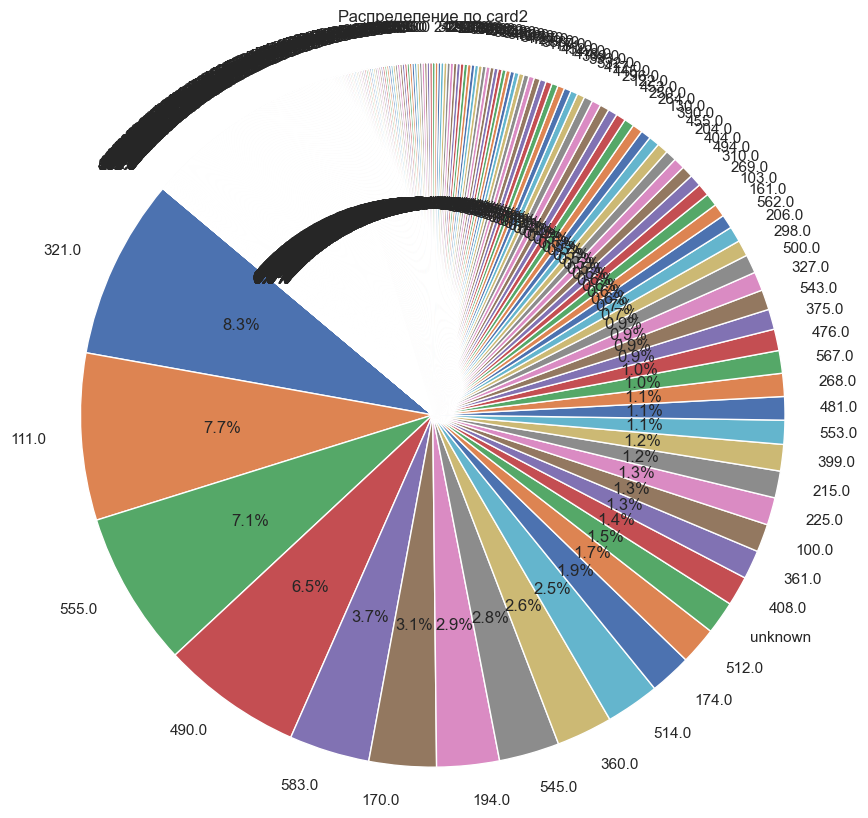

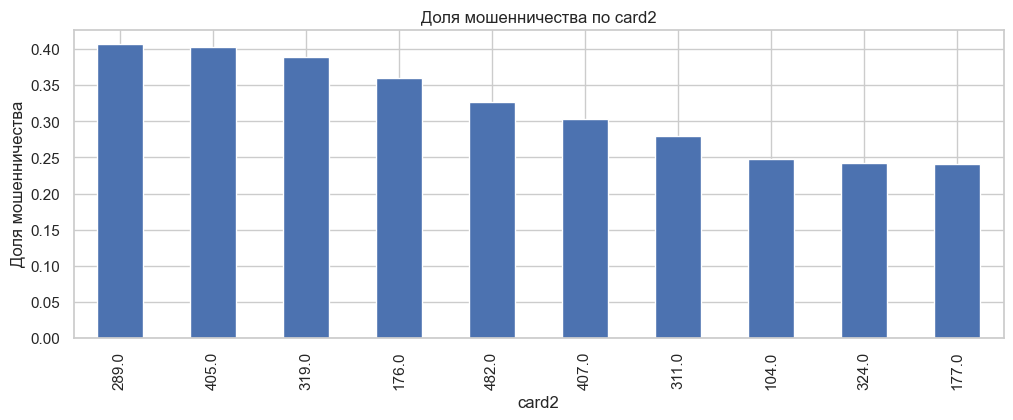

In [105]:
col = 'card2'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))


fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()


fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика "Доля мошенничества по card2"

1. **Различия в доле мошенничества:**
   - Карты с кодами `card2`, такими как 289.0 и 405.0, имеют более высокую долю мошенничества по сравнению с другими. Это указывает на возможные рисковые категории.

2. **Вариативность данных:**
   - Наблюдается значительное различие в доле мошенничества между различными значениями `card2`. Это различие может помочь в идентификации карт с высоким риском мошенничества.

3. **Выявление аномалий:**
   - Высокая доля мошенничества для некоторых значений может указывать на возможность целенаправленных атак или повышенного фокуса мошенников на этих картах.

4. **Использование в моделировании:**
   - Значения `card2` с высокой долей мошенничества можно использовать как индикаторы "красного флага" для автоматического мониторинга и фильтрации подозрительных транзакций.

### Варианты использования признака:

  - Провести анализ транзакций по указанным категориям, чтобы понять причину высокого уровня мошенничества.
  - Использовать данную информацию в качестве значимого признака для классификационных моделей, чтобы повысить точность предсказания мошенничества.

### Анализ признака card3


Анализ признака: card3
card3
150.0      0.882729
185.0      0.095414
106.0      0.002660
unknown    0.002650
146.0      0.002120
144.0      0.002120
117.0      0.001629
143.0      0.001522
119.0      0.001270
102.0      0.000779
Name: proportion, dtype: float64


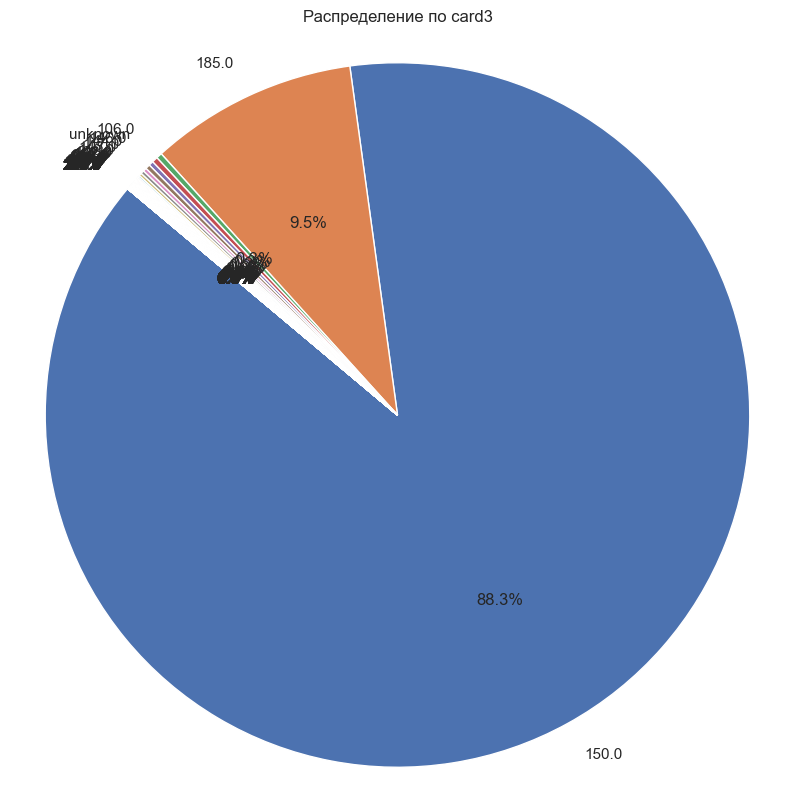

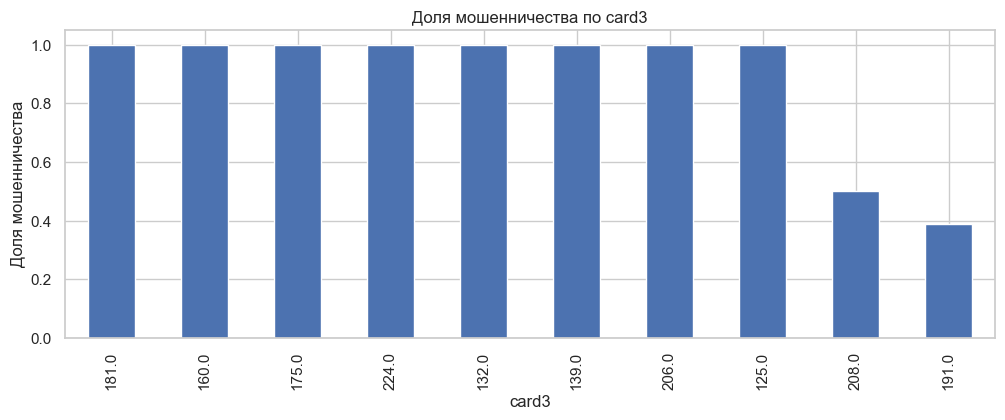

In [106]:
col = 'card3'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))


fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()


fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `card3`

1. **Высокая доля мошенничества:**
   - На графике видно, что несколько значений `card3` (такие как 181.0, 160.0, 175.0 и другие) имеют значительные доли мошенничества, близкие к 1. Это делает их важными для анализа риска.

2. **Потенциальные аномалии:**
   - Значения с высокой долей мошенничества могут указывать на либо целенаправленные атаки, либо на фальшивые карты. Стоит провести более детальное исследование таких транзакций.

3. **Сравнение с распространенностью:**
   - Несмотря на то что 150.0 занимает подавляющую часть транзакций (88%), в данном графике анализируются значения, возможно, реже встречающиеся, но более подозрительные.

4. **Важно для включения в модель:**
   - Эти данные могут быть полезны для моделирования мошенничества; важно убедиться, что эти категории включены как важные признаки в алгоритмы машинного обучения.

### Варианты использования признака:

  - Провести исследование транзакций по выявленным значениям с высокой долей мошенничества, чтобы выявить возможные причины.
  - Интегрировать те значения `card3`, которые показывают повышенный уровень риска, для повешения точности моделей прогнозирования мошенничества.


### Анализ признака  card4


Анализ признака: card4
card4
visa                0.651551
mastercard          0.320414
american express    0.014102
discover            0.011263
unknown             0.002670
Name: proportion, dtype: float64


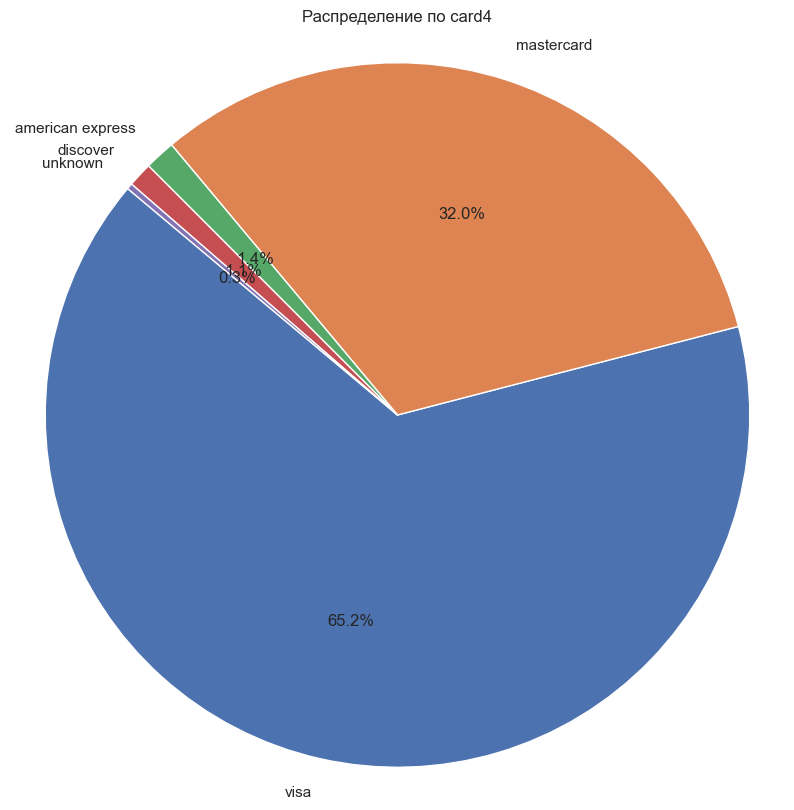

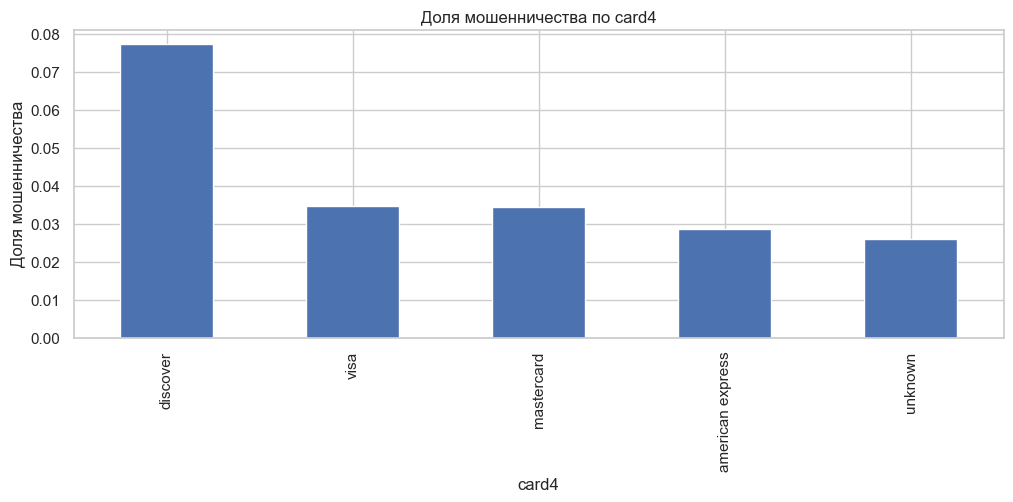

In [107]:
col = 'card4'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))


fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()


fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `card4`

1. **Доля мошенничества:**
   - Карты `discover` имеют самую высокую долю мошенничества среди всех категорий. Это может указывать на более высокий риск или целенаправленные атаки, связанные с этим типом карт.

2. **Чаще используемые карты:**
   - Хотя `visa` и `mastercard` занимают наиболее значимую долю транзакций (65% и 32% соответственно), их доля мошенничества ниже, чем у `discover`.

3. **Риск для менее распространенных карт:**
   - `American Express` и `unknown` имеют более низкие доли в данных, но их уровни мошенничества также значимы, что указывает на необходимость внимательного мониторинга.

### Варианты использования признака:

  - Продолжать анализировать транзакции по категориям, а также исследовать возможные причины высоких уровней мошенничества для некоторых типов карт.
  - Использовать категориальный признак `card4` в предсказательных моделях для повышения точности прогноза мошенничества.

### Анализ признака card5


Анализ признака: card5
card5
226.0    0.502161
224.0    0.138031
166.0    0.096759
102.0    0.049285
117.0    0.043928
138.0    0.033422
195.0    0.028694
137.0    0.019846
126.0    0.017438
219.0    0.016805
Name: proportion, dtype: float64


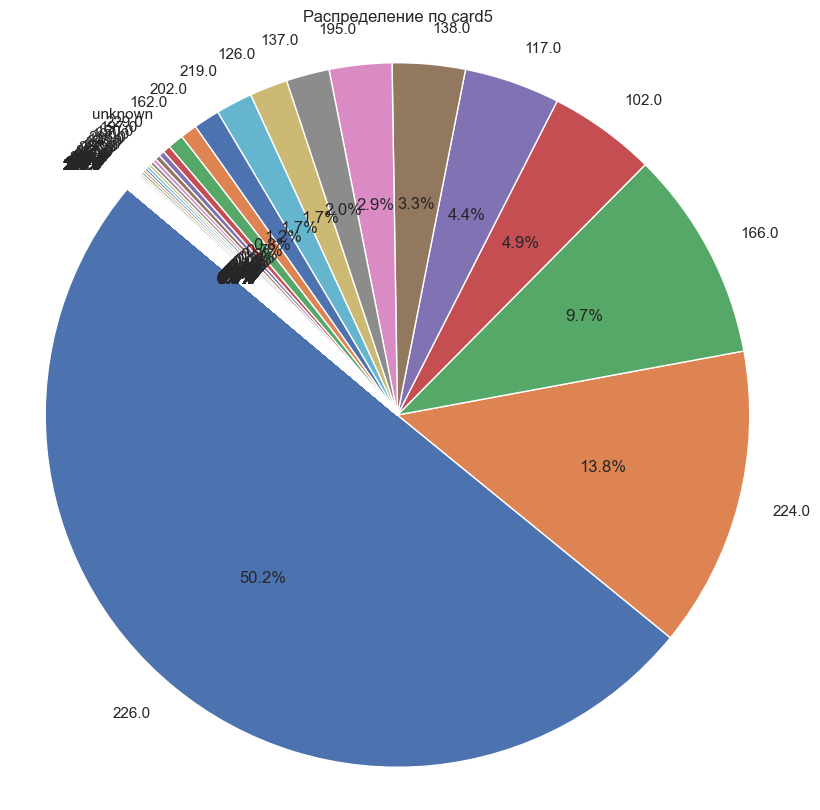

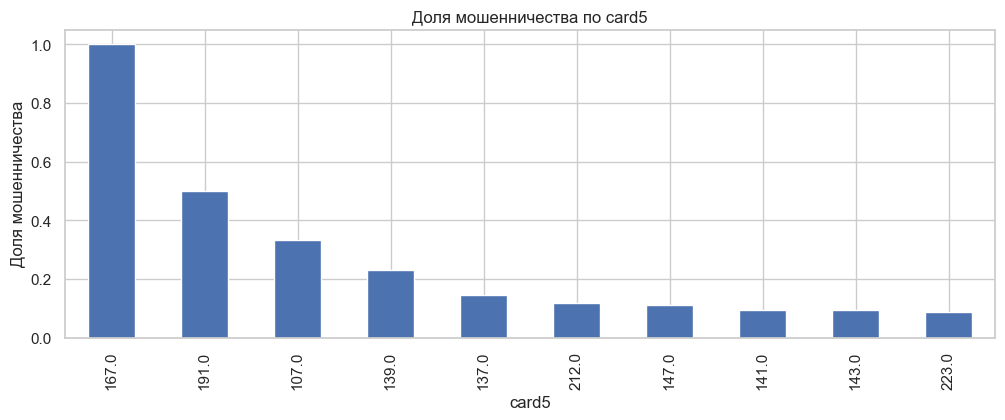

In [108]:
col = 'card5'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()


fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `card5`

1. **Значительное распространение:**
   - Наиболее распространенное значение для `card5` — это `226.0`, составляющее более половины всех записей. Такой перекос может затруднять анализ менее распространенных значений.

2. **Высокий уровень мошенничества:**
   - Значения `167.0` и `191.0` имеют впечатляюще высокую долю мошенничества, близкую к 1 , что может указывать на значительную уязвимость или дополнительные признаки аномальной активности.

3. **Разнообразие в долях:**
   - График показывает, что доля мошенничества значительно варьируется между разными значениями `card5`, что можно использовать для выделения критичных для анализа категорий.

### Варианты использования признака:

  - Провести детальное исследование транзакций с `card5` значениями 167.0 и 191.0, чтобы определить возможные уязвимости или шаблоны, объясняющие высокий уровень риска.
  - Включить разнообразие долей мошенничества по `card5` в прогнозные модели для повышения их точности при обнаружении потенциальных мошенничеств.

### Анализ признака card6


Анализ признака: card6
card6
debit              0.744976
credit             0.252288
unknown            0.002660
debit or credit    0.000051
charge card        0.000025
Name: proportion, dtype: float64


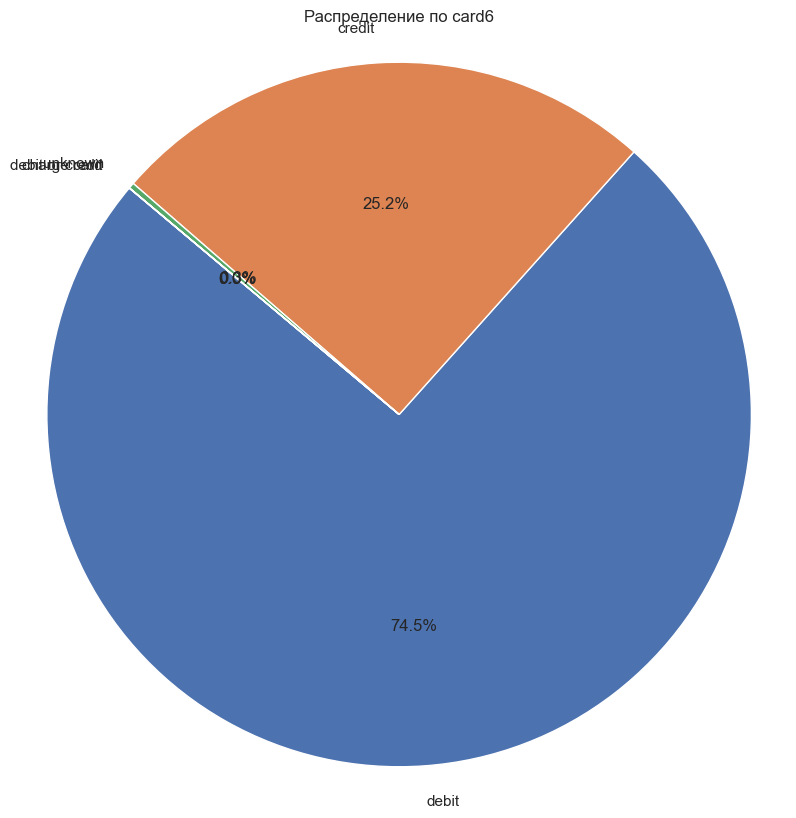

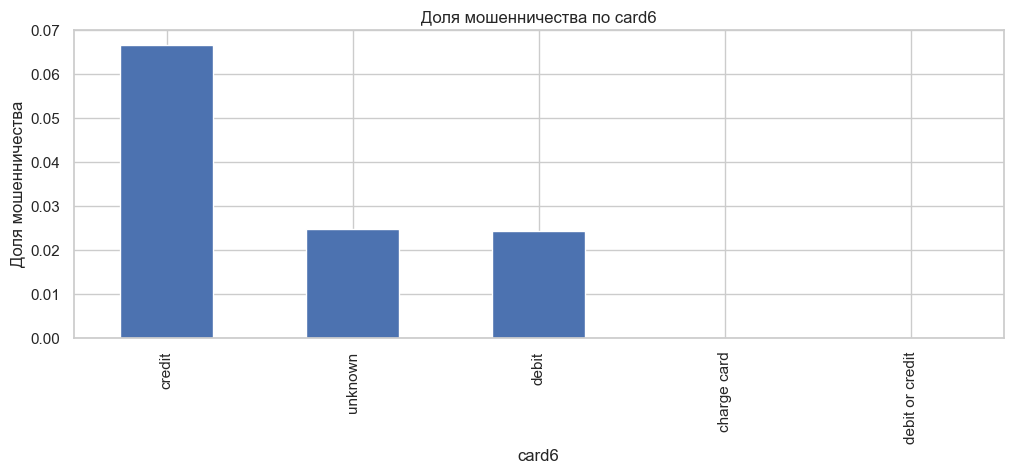

In [109]:
col = 'card6'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()

fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `card6`

1. **Подавляющее использование дебетовых карт:**
   - Основная часть транзакций осуществляется с дебетовыми картами (около 74%), однако доля их мошенничества ниже, чем у кредитных карт.

2. **Высокий риск по кредитным картам:**
   - Кредитные карты имеют более высокую долю мошенничества. Это может быть связано с характером кредитных операций или более высокой ценностью транзакций.

3. **Неопределенные и редкие категории:**
   - Категории `unknown`, `debit or credit` и `charge card` встречаются редко. Хотя они показывают доли мошенничества, их малое количество затрудняет выводы.

### Варианты использования признака:

  - Определить происхождение и характер транзакций в категории `unknown`, чтобы улучшить анализ данных.
  - Провести детальный анализ редких категорий, чтобы понимать их потенциальные риски и принимать решения на основе полученных данных.

### Анализ признака addr1


Анализ признака: addr1
addr1
unknown    0.111264
299.0      0.078462
325.0      0.072393
204.0      0.071155
264.0      0.067514
330.0      0.044513
315.0      0.039079
441.0      0.035268
272.0      0.034106
123.0      0.027272
Name: proportion, dtype: float64


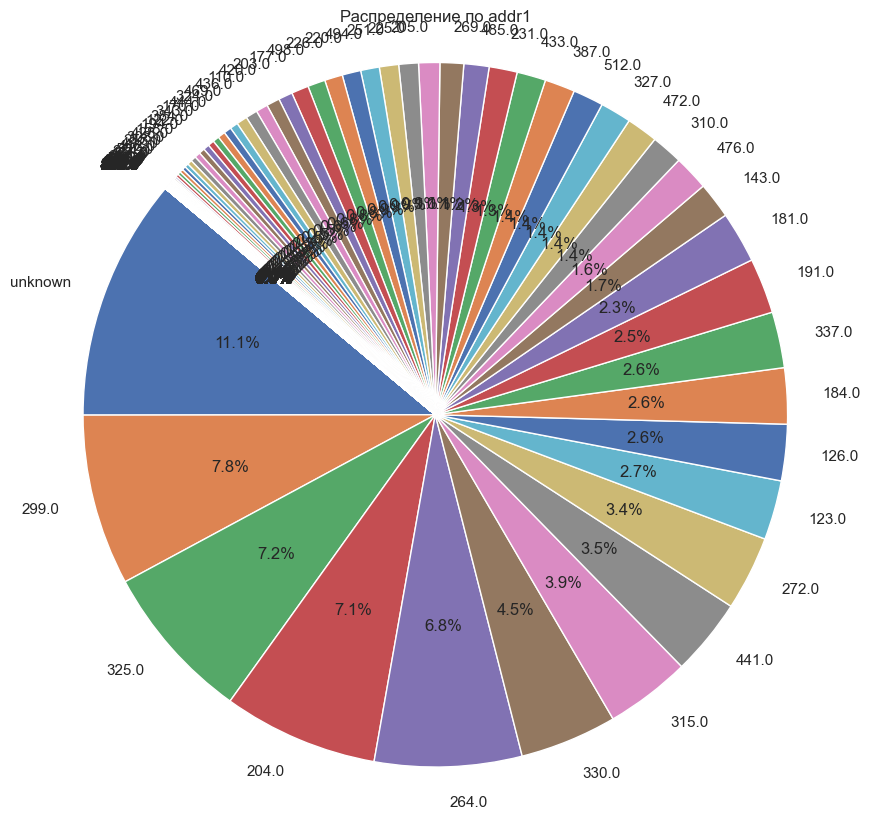

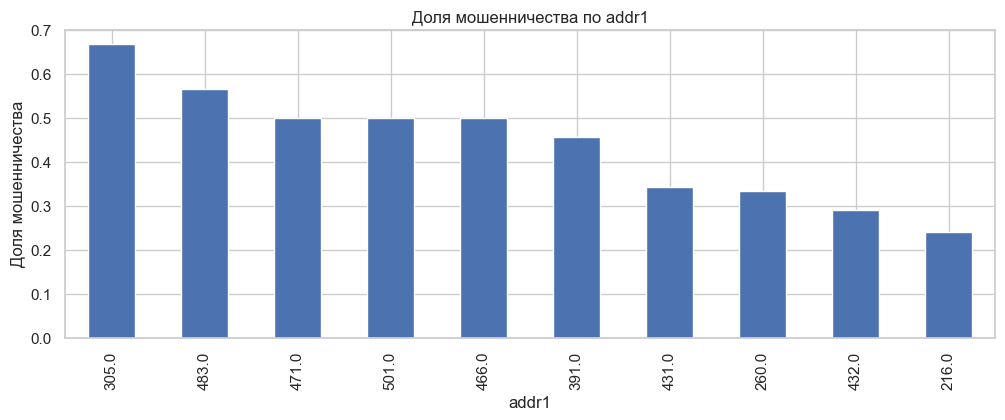

In [110]:
col = 'addr1'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()

fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `addr1`

1. **Высокая доля мошенничества:**
   - Значения, такие как `305.0`, `483.0`, `471.0` и другие, показывают высокую долю мошенничества, что может указывать на целевые уязвимости в этих регионах или адресах.

2. **Широкий разброс:**
   - Видно, что доля мошеннических транзакций значительно варьируется в разных адресных группах, что подчеркивает значимость данного признака для анализа рисков.

3. **Категория `unknown`:**
   - Хотя "unknown" имеет значительную долю в данных, его влияние на уровень мошенничества необходимо дополнительно изучать.

### Варианты использования признака:

  - Провести детальное исследование транзакций для адресов с наибольшими рисками, чтобы выявить потенциальные причины высокой доли мошенничества.
  - Использовать `addr1` как важный признак в моделях машинного обучения для улучшения предсказания мошенничества.
  - Исследовать и, возможно, корректировать записи с адресами "unknown", чтобы избежать искажения данных и повысить точность анализа.

### Анализ признака addr2


Анализ признака: addr2
addr2
87.0       0.881365
unknown    0.111264
60.0       0.005222
96.0       0.001080
32.0       0.000154
65.0       0.000139
16.0       0.000093
31.0       0.000080
19.0       0.000056
26.0       0.000042
Name: proportion, dtype: float64


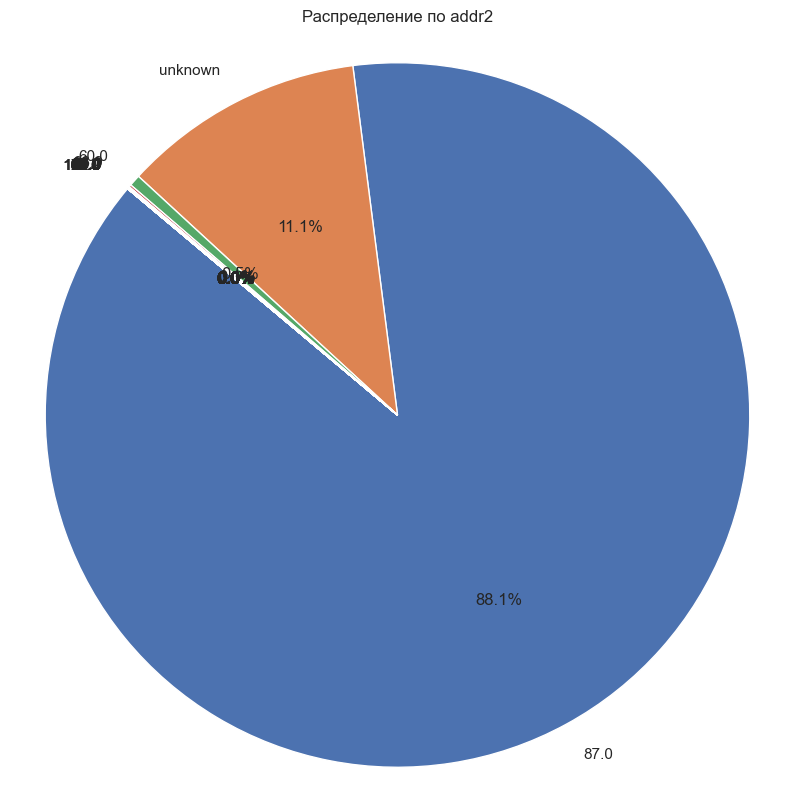

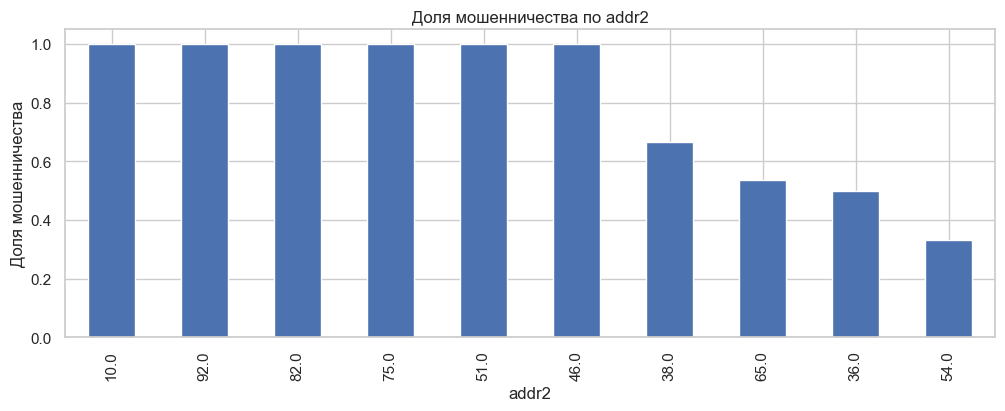

In [111]:
col = 'addr2'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()


fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `addr2`

1. **Доминирование значения 87.0:**
   - Значение `87.0` составляет около 88% всех записей, что указывает на значительную концентрацию в определенном регионе или области. Это может затруднять выявление других паттернов.

2. **Высокая доля мошенничества:**
   - Значения, такие как `10.0`, `92.0` и другие, демонстрируют крайне высокую долю мошеннических транзакций, близкую к 1, что может свидетельствовать о целенаправленных атаках на эти регионы.

3. **Неопределенность категорий:**
   - Категория `unknown` также занимает значимую долю, но её влияние на уровень мошенничества нужно дополнительно изучать.

### Варианты использования признака:
  - Провести дополнительное исследование транзакций из адресов с самыми высокими уровнями мошенничества, чтобы выявить возможные причины.
  - Поскольку `87.0` занимает значительную долю, оценить, почему именно это значение столь распространено и как оно влияет на общие паттерны данных.
  - Включить явный дисбаланс в `addr2` при построении моделей для понимания рисков и потенциальных угроз.

### Анализ признака P_emaildomain


Анализ признака: P_emaildomain
P_emaildomain
gmail.com        0.386688
yahoo.com        0.170918
unknown          0.159949
hotmail.com      0.076625
anonymous.com    0.062651
aol.com          0.047904
comcast.net      0.013357
icloud.com       0.010612
outlook.com      0.008629
msn.com          0.006929
Name: proportion, dtype: float64


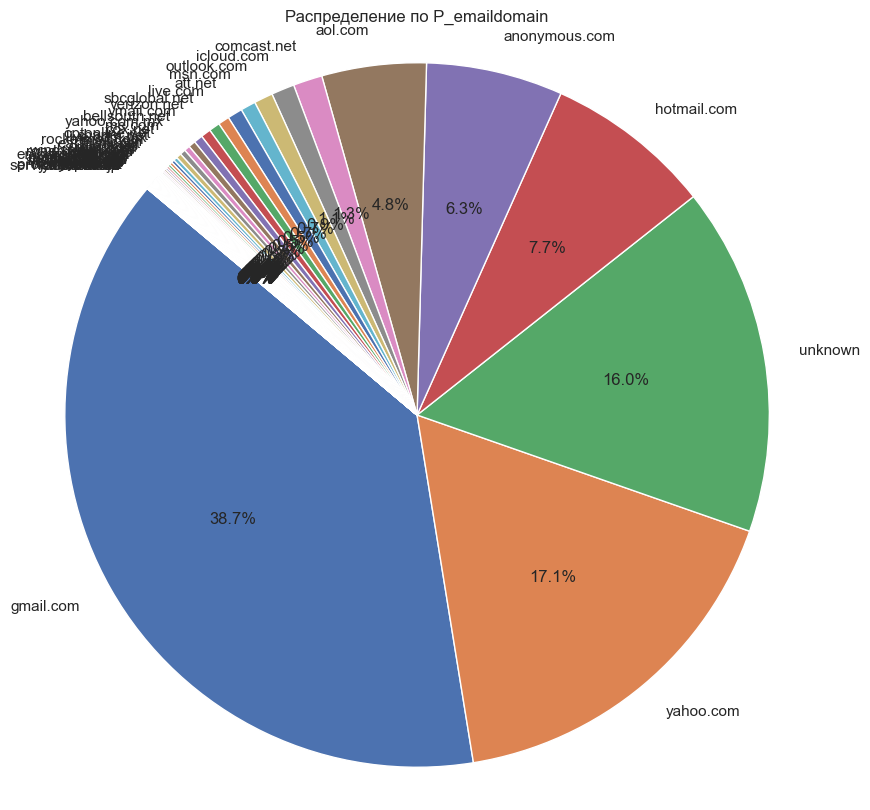

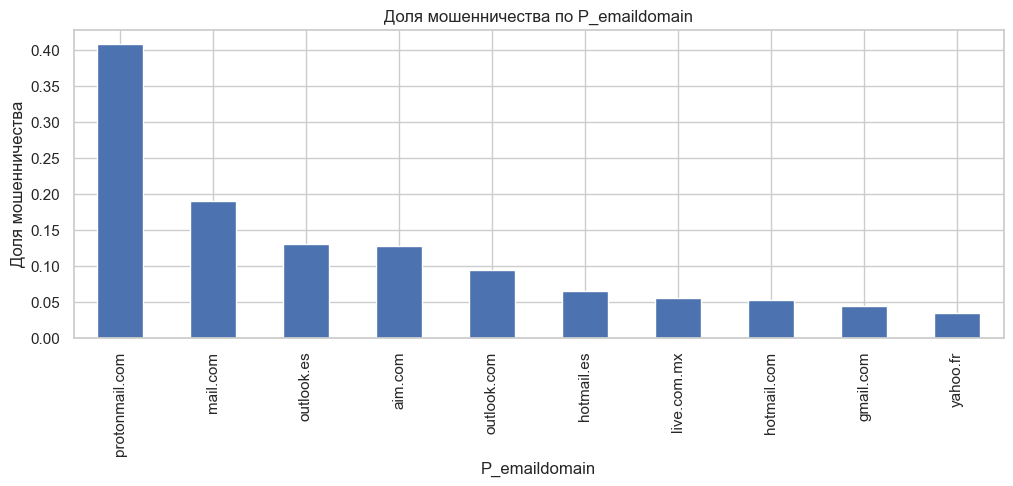

In [112]:
col = 'P_emaildomain'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()

fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `P_emaildomain`

1. **Высокий уровень мошенничества у определённых провайдеров:**
   - `protonmail.com` имеет наивысшую долю мошенничества среди доменов, что может указывать на его популярность среди злоумышленников.

2. **Распространённые домены:**
   - `gmail.com` и `yahoo.com` являются самыми распространёнными доменами, но их доля мошенничества намного ниже, по сравнению с другими доменами.

3. **Роль "unknown":**
   - Категория `unknown` составляет значительную часть данных, и её влияние на общие паттерны неясно, что требует дополнительного изучения.

### Варианты использования признака:

  - Исследовать записи с `unknown` доменами для понимания их природы и потенциальных рисков.

### Анализ признака  R_emaildomain


Анализ признака: R_emaildomain
R_emaildomain
unknown          0.767516
gmail.com        0.096771
hotmail.com      0.046583
anonymous.com    0.034763
yahoo.com        0.020053
aol.com          0.006267
outlook.com      0.004245
comcast.net      0.003068
yahoo.com.mx     0.002554
icloud.com       0.002367
Name: proportion, dtype: float64


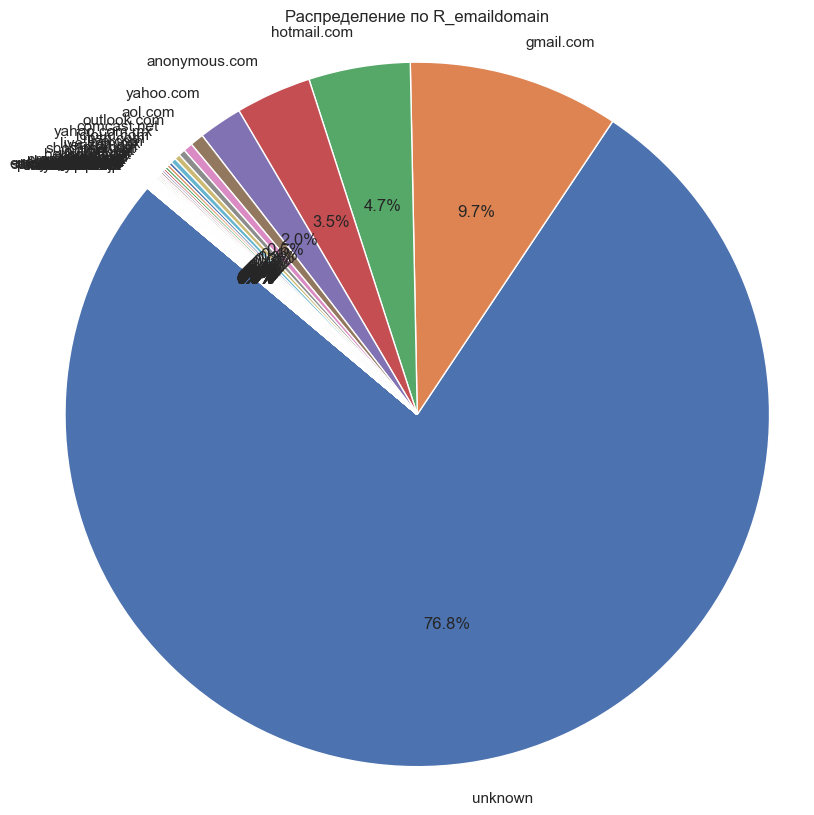

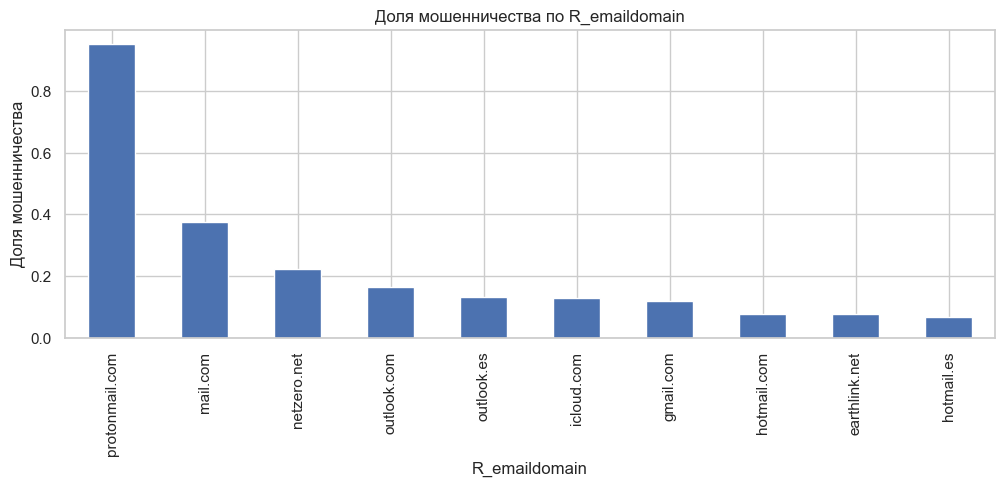

In [113]:
col = 'R_emaildomain'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()


fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `R_emaildomain`

1. **Высокая доля "unknown":**
   - Категория `unknown` доминирует (76.7%) среди записей, что указывает на недостаток информации о получателе в большинстве транзакций. Это затрудняет анализ распределения остальных категорий.

2. **Высокая доля мошенничества у `protonmail.com`:**
   - `protonmail.com` имеет наибольшую долю мошенничества, что требует внимания и возможно, повышенного мониторинга таких транзакций.

3. **Низкое распределение по другим категориям:**
   - Очень малая доля пользователей на gmail.com, hotmail.com и других популярных доменах указана как получатели. Это может указывать на особенности данных или стратегию мошенников.

### Варианты использования признака:

  - Углубленный анализ данных без известных доменов может помочь понять логику транзакций и выявить скрытые риски.
  - Изучить транзакции с известными, но менее представленными доменами и понять их роль в общем контексте.

### Анализ признака  DeviceType


Анализ признака: DeviceType
DeviceType
unknown    0.761557
desktop    0.144215
mobile     0.094227
Name: proportion, dtype: float64


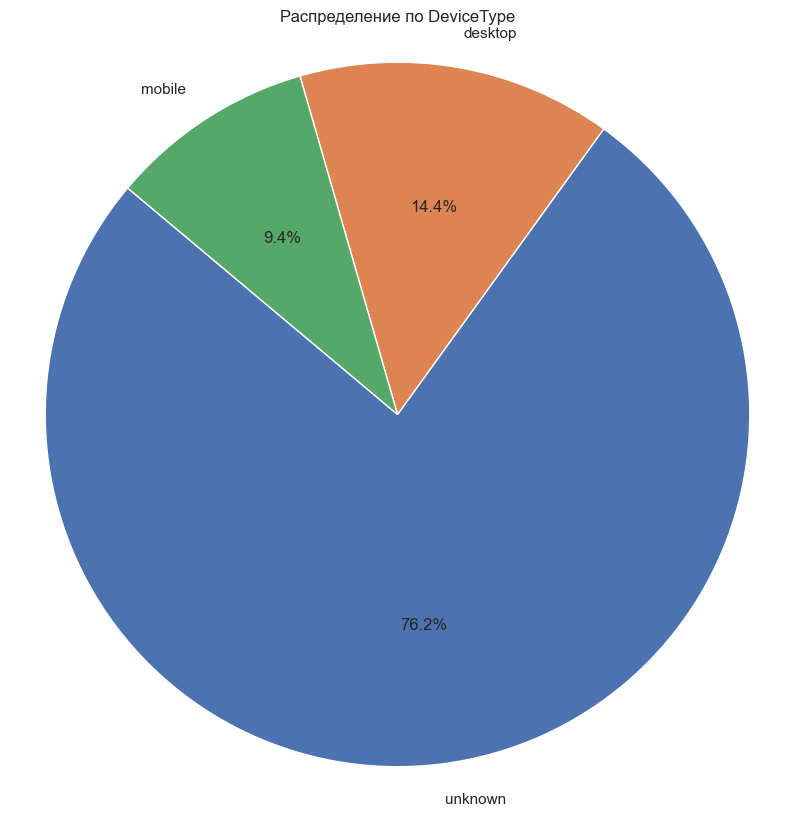

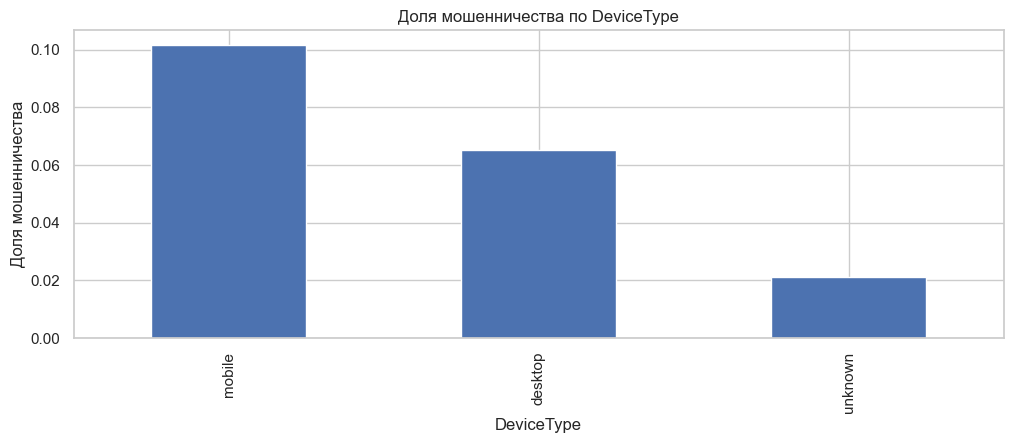

In [114]:
col = 'DeviceType'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()

fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `DeviceType`

1. **Преобладание категории "unknown":**
   - Большинство записей (76.2%) не указывают тип устройства, что затрудняет анализ и требует дополнительной интерпретации данных.

2. **Мошенничество на мобильных устройствах:**
   - Мобильные устройства показывают более высокую долю мошенничества по сравнению с другими категориями, что может указывать на уязвимость этих устройств.

3. **Процент использования:**
   - `desktop` и `mobile` составляют меньшую долю, но все еще значимы для анализа пользовательского поведения.

### Анализ признака  DeviceInfo


Анализ признака: DeviceInfo
DeviceInfo
unknown                  0.799055
Windows                  0.080811
iOS Device               0.033498
MacOS                    0.021291
Trident/7.0              0.012599
rv:11.0                  0.003219
rv:57.0                  0.001629
SM-J700M Build/MMB29K    0.000930
SM-G610M Build/MMB29K    0.000781
SM-G531H Build/LMY48B    0.000694
Name: proportion, dtype: float64


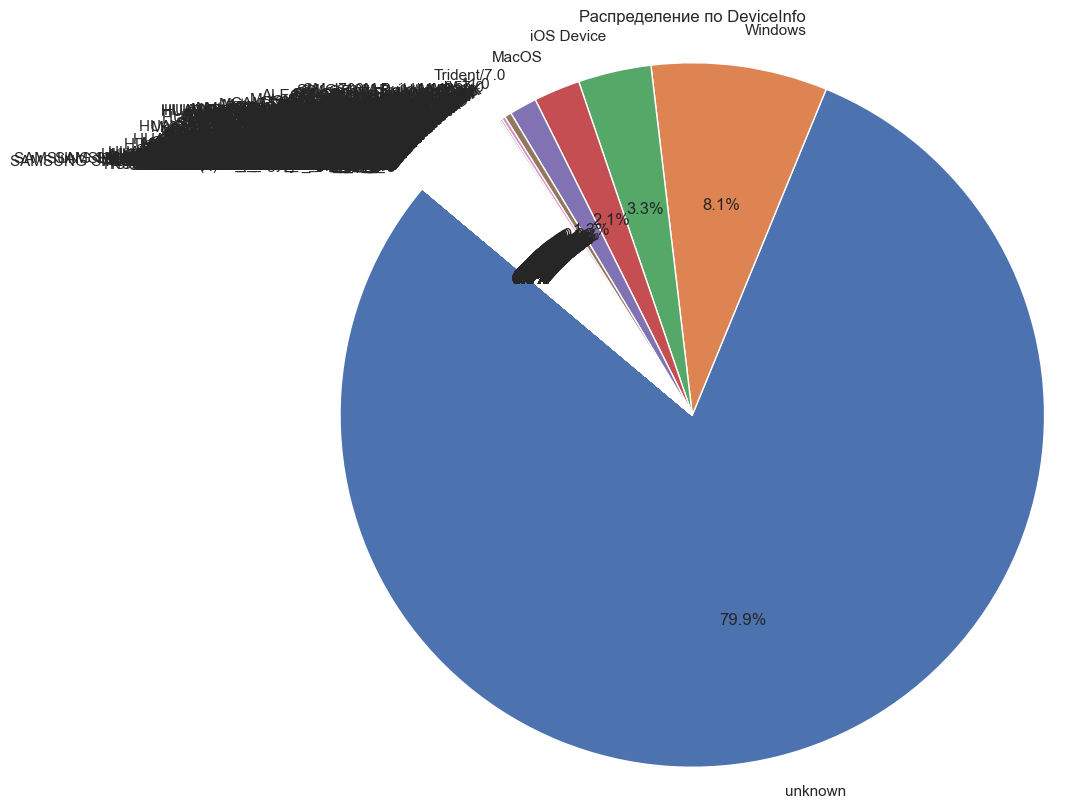

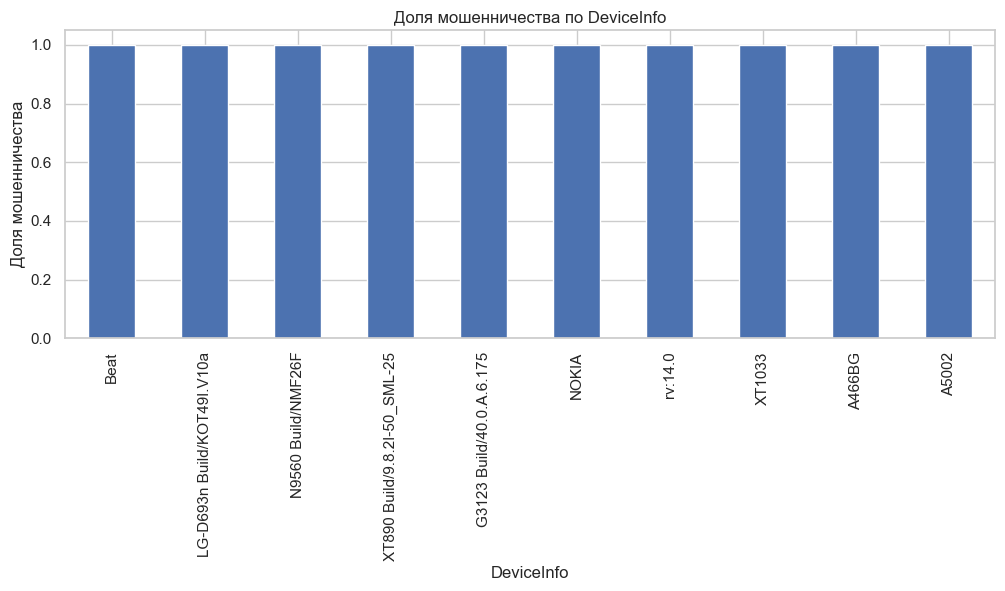

In [115]:
col = 'DeviceInfo'
print(f'\nАнализ признака: {col}')
print(train[col].value_counts(normalize=True).head(10))

fature_counts = train[col].value_counts(normalize=True) * 100

# Построение круговой диаграммы
plt.figure(figsize=(10,10))
plt.pie(fature_counts, labels=fature_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Распределение по {col}')
plt.axis('equal')  # Убедитесь, что круговая диаграмма круглая
plt.show()

fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
fraud_rate.head(10).plot(kind='bar')
plt.title(f'Доля мошенничества по {col}')
plt.ylabel('Доля мошенничества')
plt.show()

### Анализ графика признака `DeviceInfo`

1. **Преобладание "unknown":**
   - Подавляющее большинство записей (79.9%) не содержат информации об устройстве, что создаёт значительную неопределённость.

2. **Высокий уровень мошенничества у отдельных устройств:**
   - Устройства, такие как `Beat`, `NOKIA`, и некоторые другие специфические модели, показывают очень высокую долю мошенничества, что требует дополнительного внимания.

3. **Доля популярных устройств:**
   - `Windows`, `iOS Device`, и `MacOS` представлены в меньшей степени, с более низким уровнем мошенничества.

### Варианты использования признака:
  - Провести подробное исследование и мониторинг устройств с высокой долей мошенничества.
  - Уменьшить кол-во типов устройст


Анализ признака: id_01
id_01
 unknown    0.755761
-5.0        0.139144
 0.0        0.033114
-10.0       0.019062
-20.0       0.018984
-15.0       0.009608
-25.0       0.007828
-45.0       0.003629
-35.0       0.002747
-40.0       0.002345
Name: proportion, dtype: float64


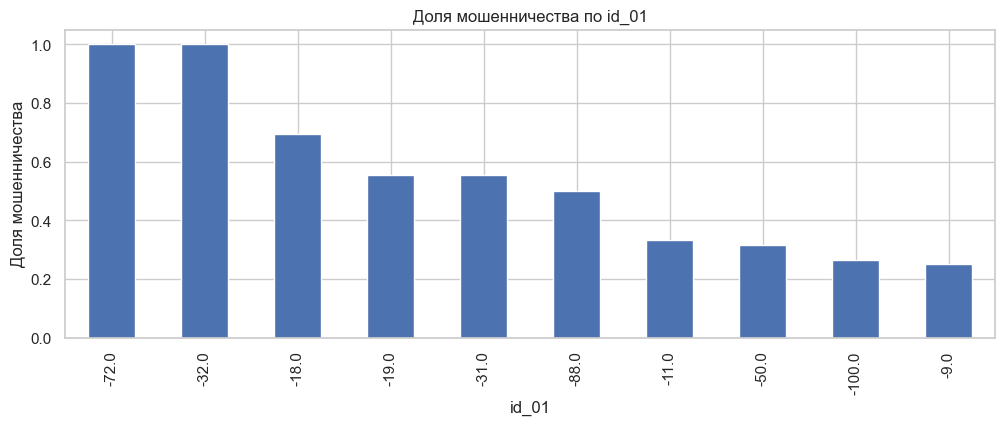


Анализ признака: id_02
id_02
unknown    0.761452
1102.0     0.000019
696.0      0.000017
1141.0     0.000015
1117.0     0.000015
1116.0     0.000015
1083.0     0.000015
1120.0     0.000015
1127.0     0.000014
1110.0     0.000012
Name: proportion, dtype: float64


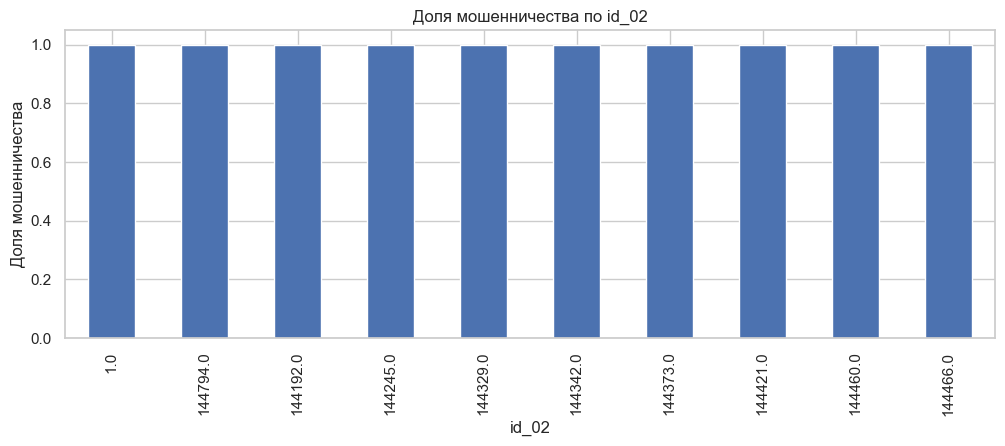


Анализ признака: id_03
id_03
 unknown    0.887689
 0.0        0.108211
 1.0        0.001461
 3.0        0.001131
 2.0        0.000713
 5.0        0.000185
 4.0        0.000169
 6.0        0.000108
-5.0        0.000056
-6.0        0.000052
Name: proportion, dtype: float64


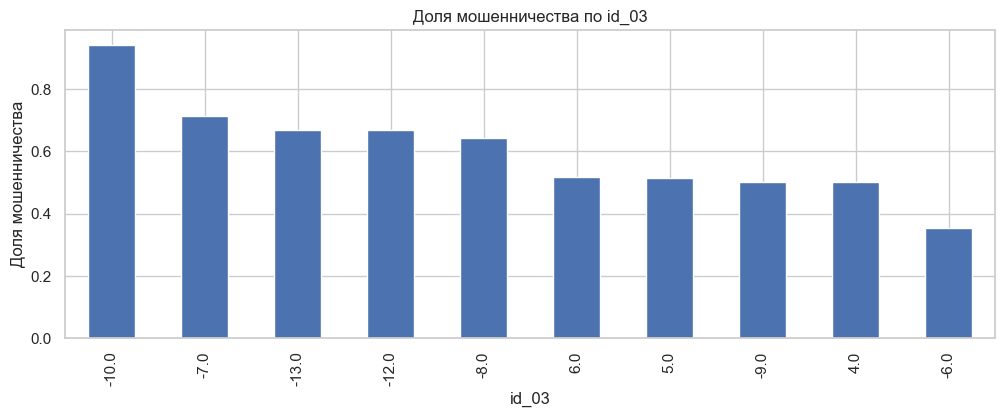


Анализ признака: id_04
id_04
 unknown    0.887689
 0.0        0.111320
-5.0        0.000224
-6.0        0.000166
-8.0        0.000108
-4.0        0.000086
-1.0        0.000073
-11.0       0.000059
-12.0       0.000058
-10.0       0.000051
Name: proportion, dtype: float64


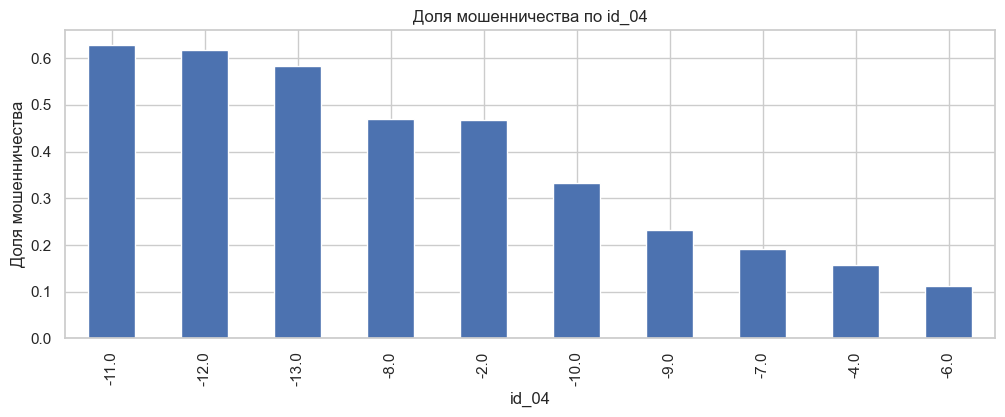


Анализ признака: id_05
id_05
unknown    0.768238
0.0        0.157048
1.0        0.014043
2.0        0.008360
3.0        0.006526
4.0        0.004980
6.0        0.003959
5.0        0.003915
7.0        0.002498
8.0        0.002144
Name: proportion, dtype: float64


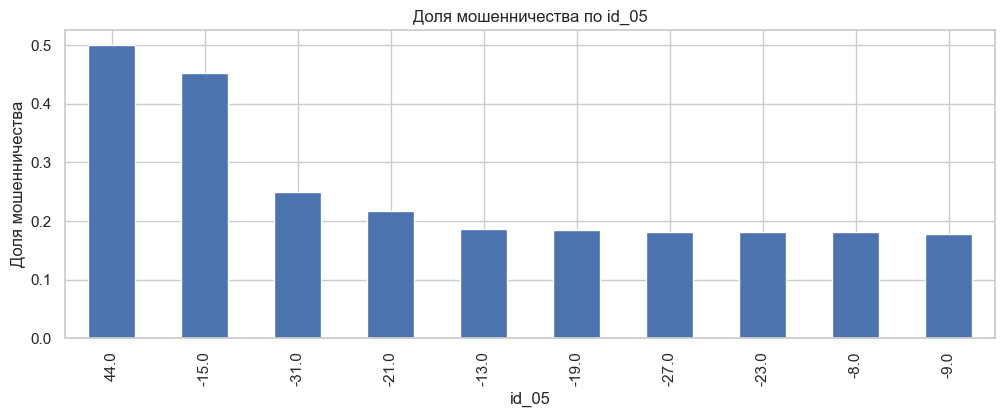


Анализ признака: id_06
id_06
 unknown    0.768238
 0.0        0.154647
-1.0        0.007937
-5.0        0.006518
-6.0        0.005515
-9.0        0.004460
-100.0      0.004117
-8.0        0.003377
-10.0       0.003326
-11.0       0.003102
Name: proportion, dtype: float64


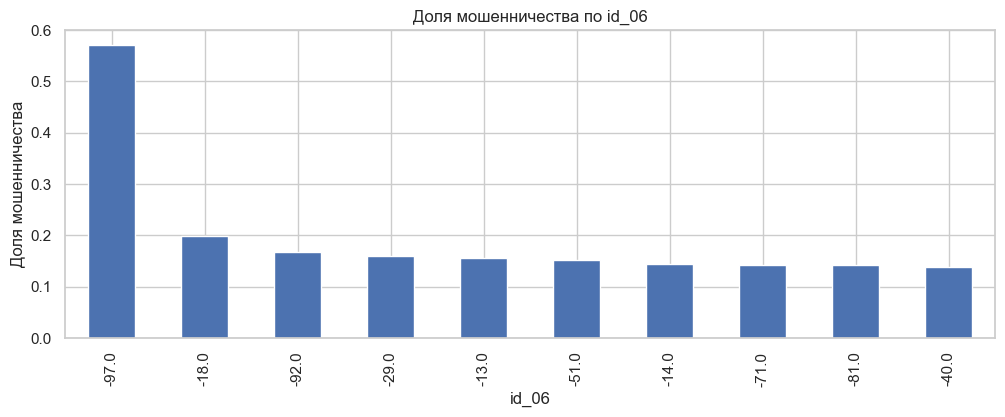


Анализ признака: id_09
id_09
 unknown    0.873123
 0.0        0.119176
 1.0        0.002736
 3.0        0.001636
 2.0        0.001309
 4.0        0.000457
 5.0        0.000351
 6.0        0.000246
-6.0        0.000112
-5.0        0.000102
Name: proportion, dtype: float64


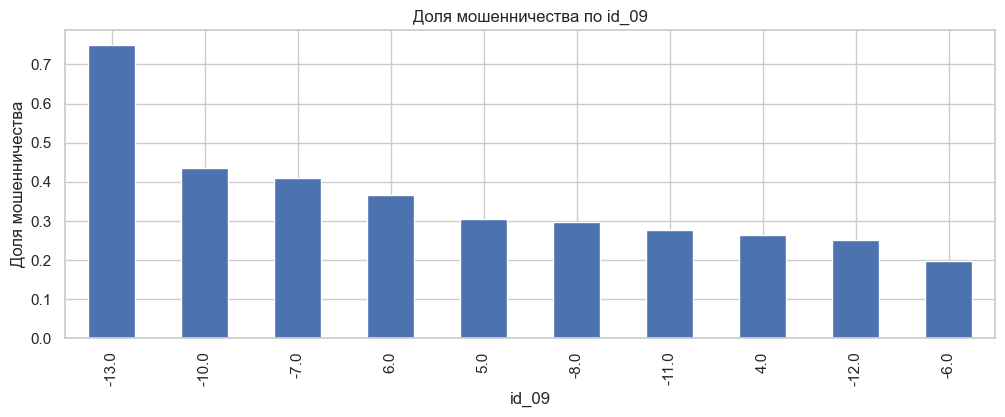


Анализ признака: id_10
id_10
 unknown    0.873123
 0.0        0.123411
-6.0        0.000500
-5.0        0.000418
-1.0        0.000339
-8.0        0.000249
-11.0       0.000215
-9.0        0.000200
-12.0       0.000200
-10.0       0.000195
Name: proportion, dtype: float64


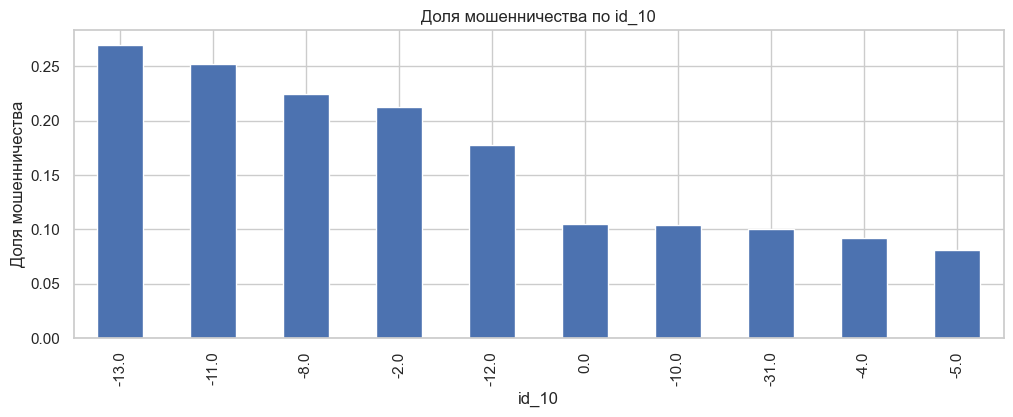


Анализ признака: id_11
id_11
unknown      0.761273
100.0        0.225492
95.080002    0.002085
95.160004    0.001277
97.120003    0.000745
96.669998    0.000564
95.650002    0.000484
96.190002    0.000408
94.290001    0.000386
93.550003    0.000345
Name: proportion, dtype: float64


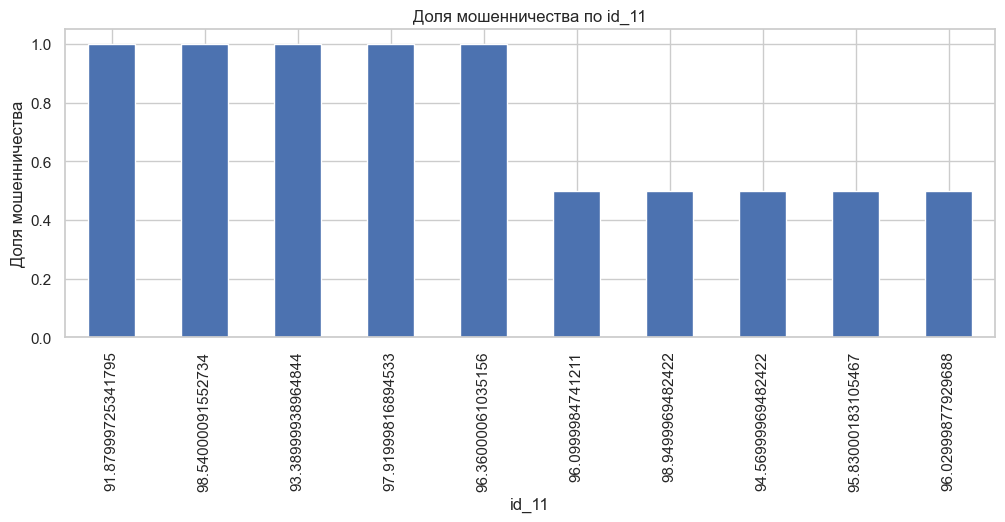


Анализ признака: id_12
id_12
unknown     0.755761
NotFound    0.208326
Found       0.035913
Name: proportion, dtype: float64


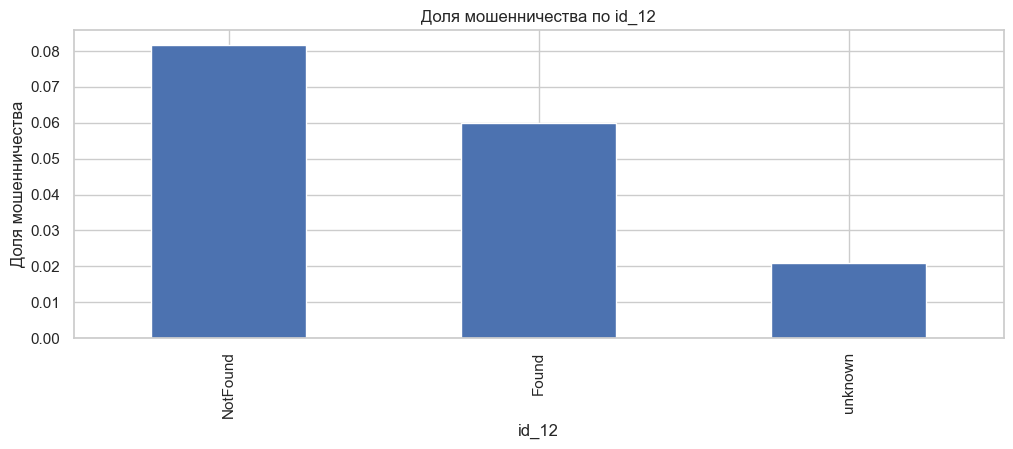


Анализ признака: id_13
id_13
unknown    0.784401
52.0       0.098383
49.0       0.044646
64.0       0.024434
33.0       0.017015
27.0       0.006208
20.0       0.004874
14.0       0.004232
63.0       0.002486
19.0       0.001942
Name: proportion, dtype: float64


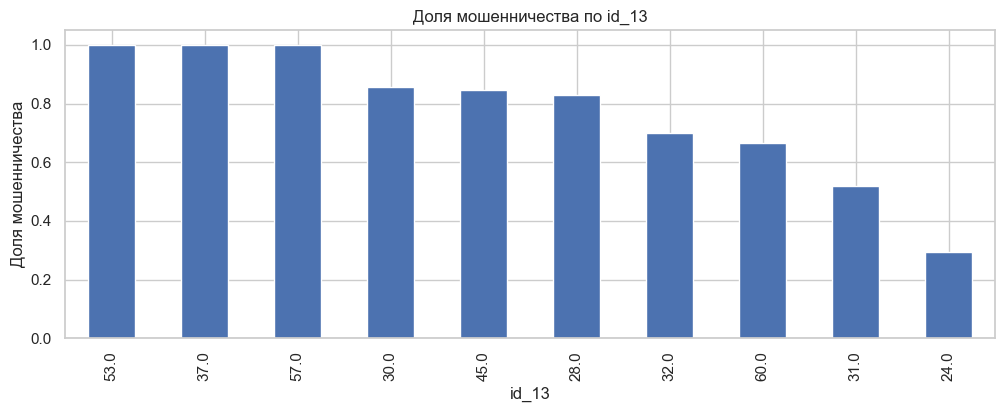


Анализ признака: id_14
id_14
 unknown    0.864456
-300.0      0.074713
-360.0      0.028213
-480.0      0.021829
-420.0      0.007691
-600.0      0.000843
 60.0       0.000625
 0.0        0.000325
-240.0      0.000269
-180.0      0.000213
Name: proportion, dtype: float64


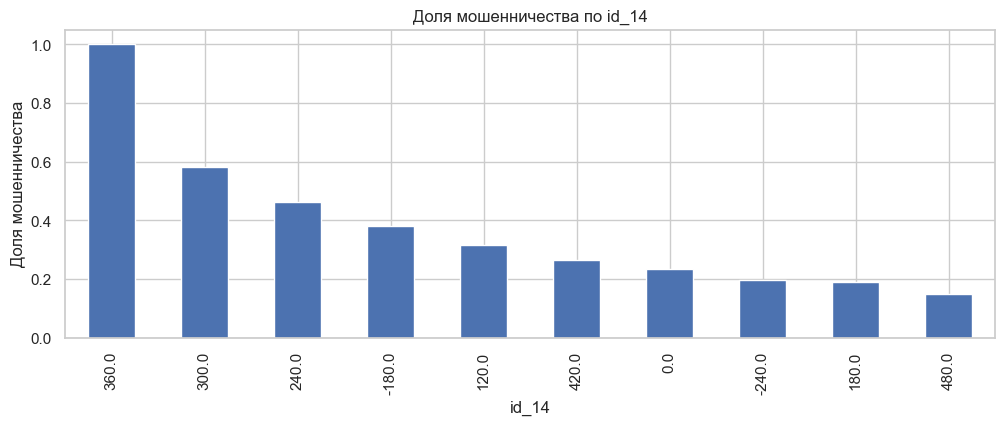


Анализ признака: id_15
id_15
unknown    0.761261
Found      0.114688
New        0.104332
Unknown    0.019719
Name: proportion, dtype: float64


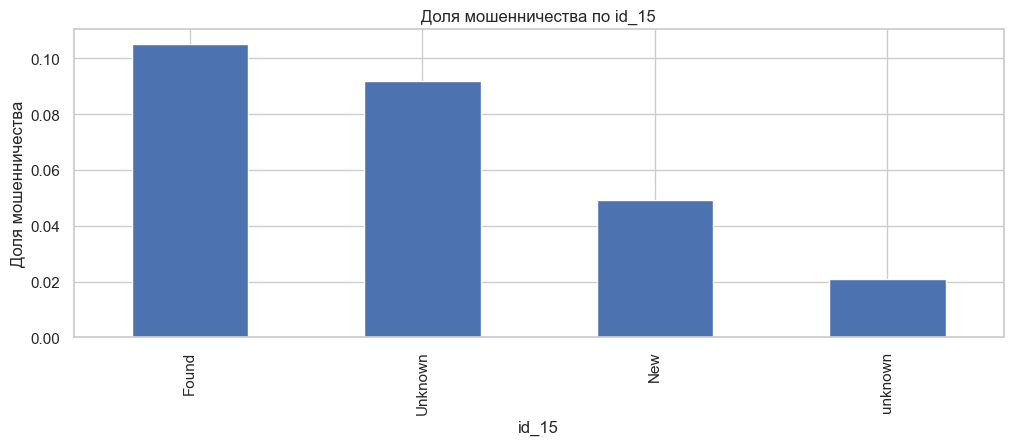


Анализ признака: id_16
id_16
unknown     0.780980
Found       0.112311
NotFound    0.106709
Name: proportion, dtype: float64


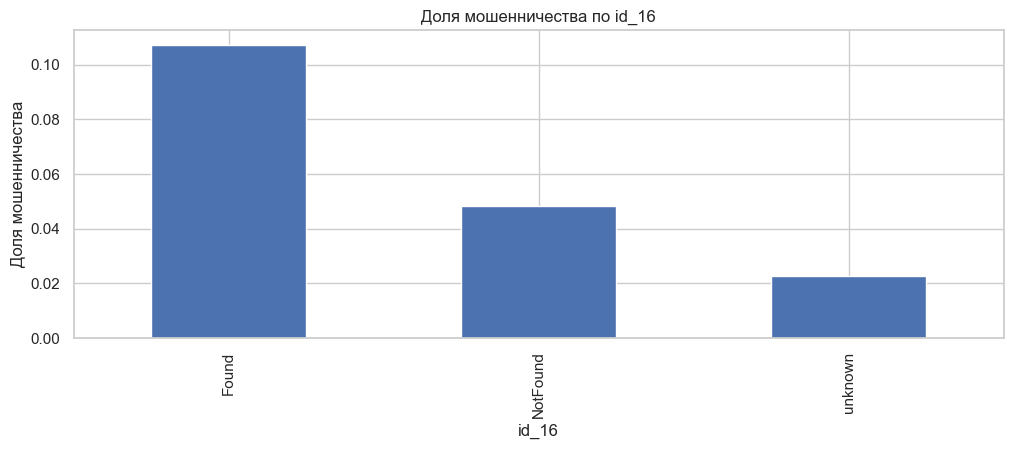


Анализ признака: id_17
id_17
unknown    0.763997
166.0      0.133151
225.0      0.096468
102.0      0.001167
159.0      0.000596
100.0      0.000569
121.0      0.000472
148.0      0.000388
150.0      0.000213
191.0      0.000208
Name: proportion, dtype: float64


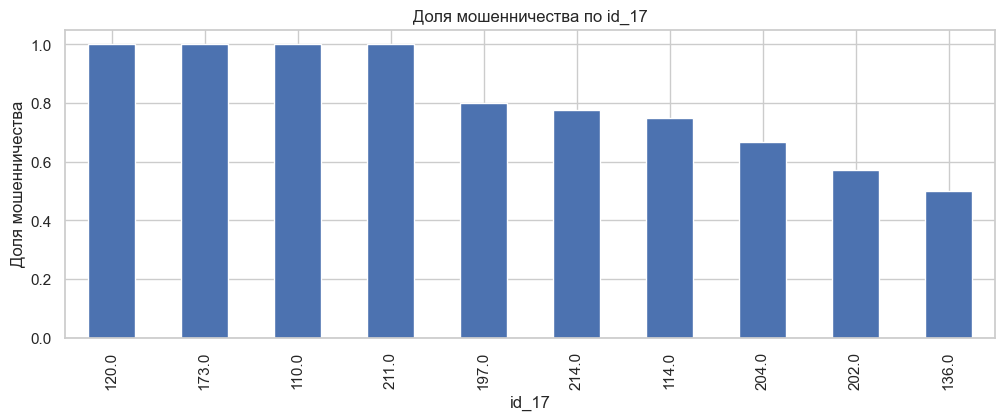


Анализ признака: id_18
id_18
unknown    0.923607
15.0       0.043162
13.0       0.022757
12.0       0.007884
18.0       0.001101
20.0       0.000574
17.0       0.000395
26.0       0.000151
21.0       0.000132
24.0       0.000088
Name: proportion, dtype: float64


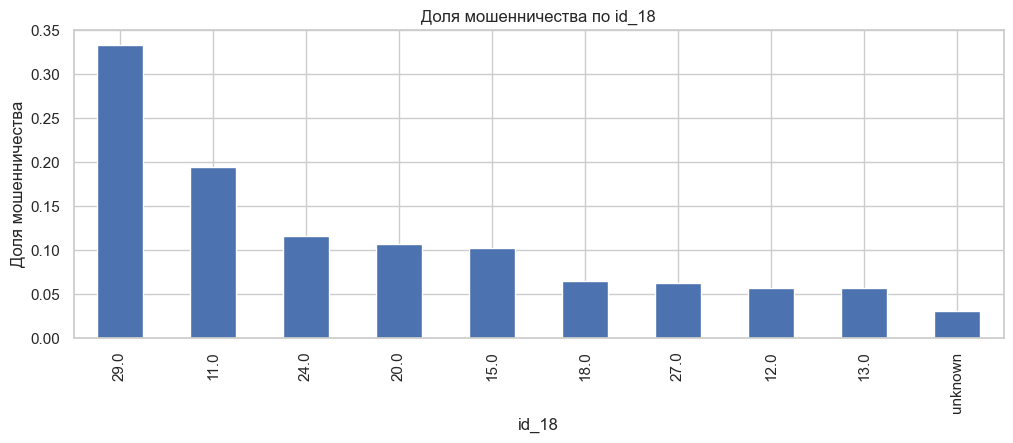


Анализ признака: id_19
id_19
unknown    0.764084
266.0      0.033612
410.0      0.019166
427.0      0.014915
529.0      0.013754
312.0      0.010545
100.0      0.008910
542.0      0.008663
215.0      0.008006
153.0      0.007424
Name: proportion, dtype: float64


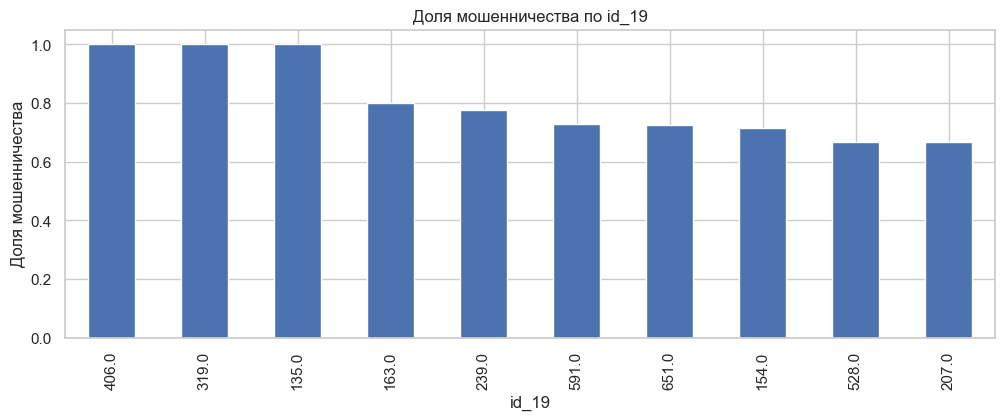


Анализ признака: id_20
id_20
unknown    0.764180
507.0      0.037781
222.0      0.018737
325.0      0.013772
533.0      0.011195
214.0      0.009591
549.0      0.009556
600.0      0.009420
563.0      0.007977
333.0      0.006250
Name: proportion, dtype: float64


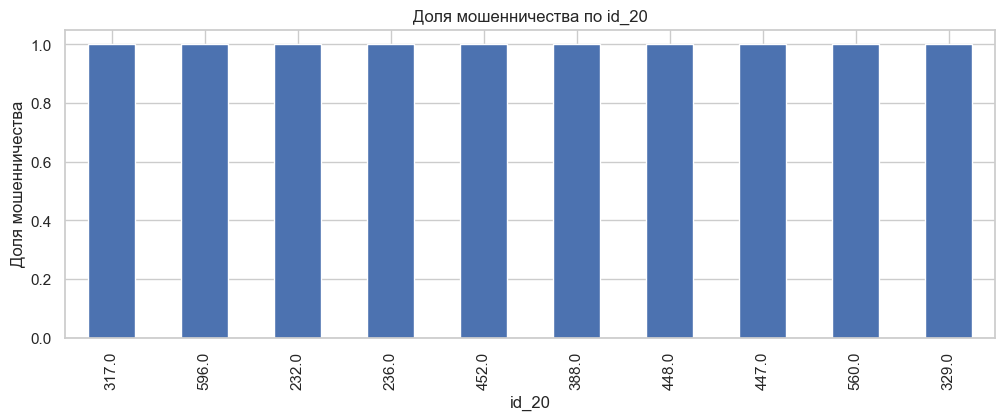


Анализ признака: id_28
id_28
unknown    0.761273
Found      0.129089
New        0.109639
Name: proportion, dtype: float64


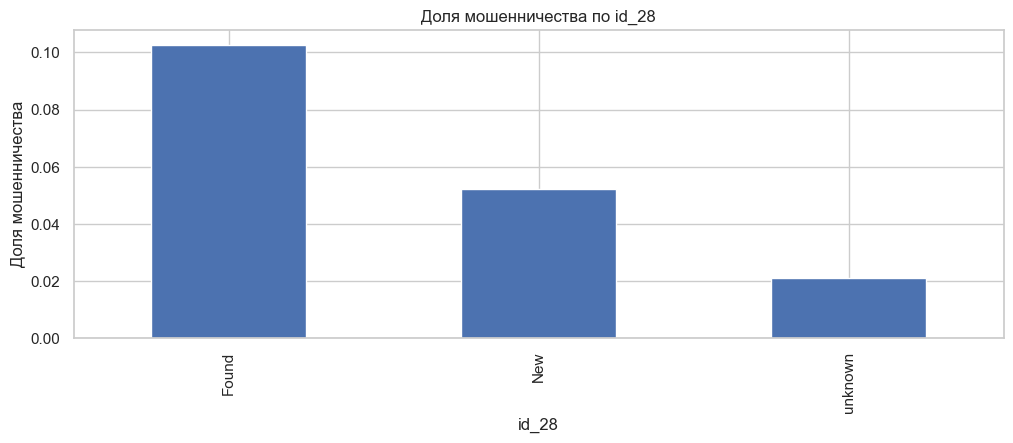


Анализ признака: id_29
id_29
unknown     0.761273
Found       0.126877
NotFound    0.111850
Name: proportion, dtype: float64


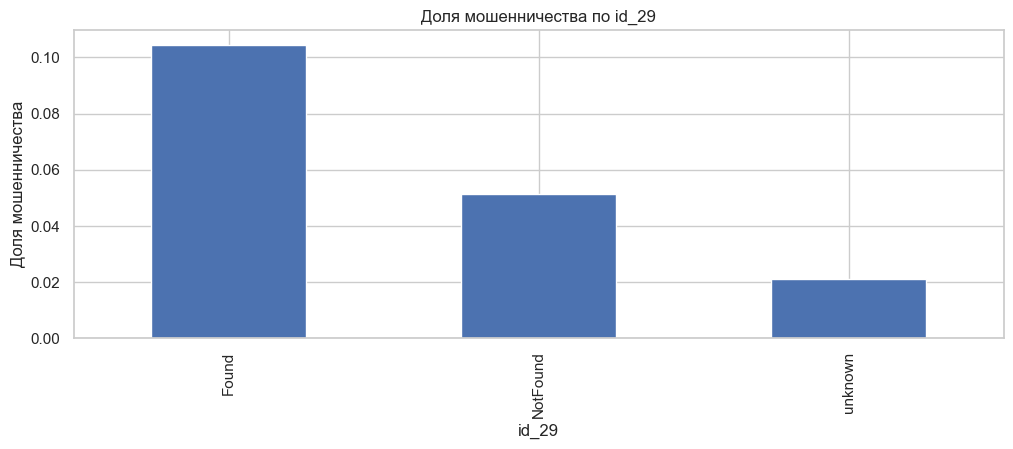


Анализ признака: id_30
id_30
unknown             0.868654
Windows 10          0.035823
Windows 7           0.022200
iOS 11.2.1          0.006303
iOS 11.1.2          0.006264
Android 7.0         0.004862
Mac OS X 10_12_6    0.004333
Mac OS X 10_11_6    0.003976
iOS 11.3.0          0.003414
Windows 8.1         0.003241
Name: proportion, dtype: float64


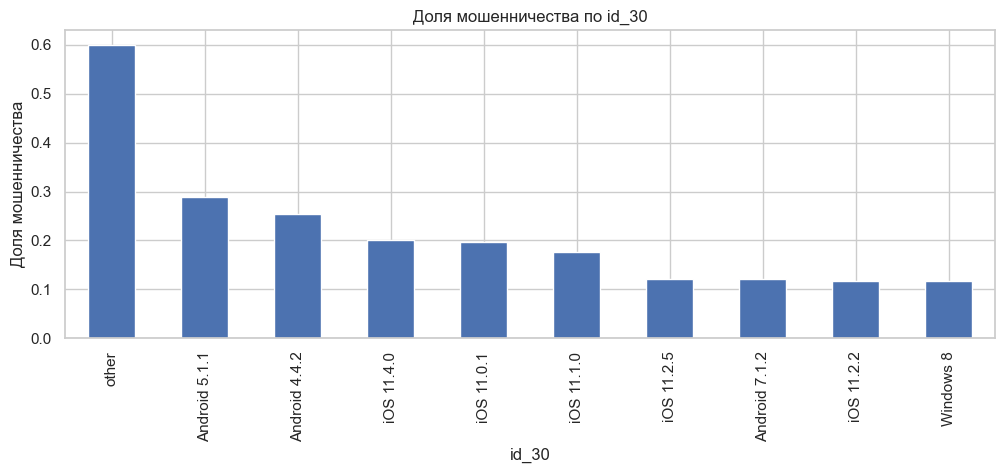


Анализ признака: id_31
id_31
unknown                    0.762451
chrome 63.0                0.037254
mobile safari 11.0         0.022730
mobile safari generic      0.019430
ie 11.0 for desktop        0.015291
safari generic             0.013877
chrome 62.0                0.012162
chrome 65.0                0.011635
chrome 64.0                0.011364
chrome 63.0 for android    0.009832
Name: proportion, dtype: float64


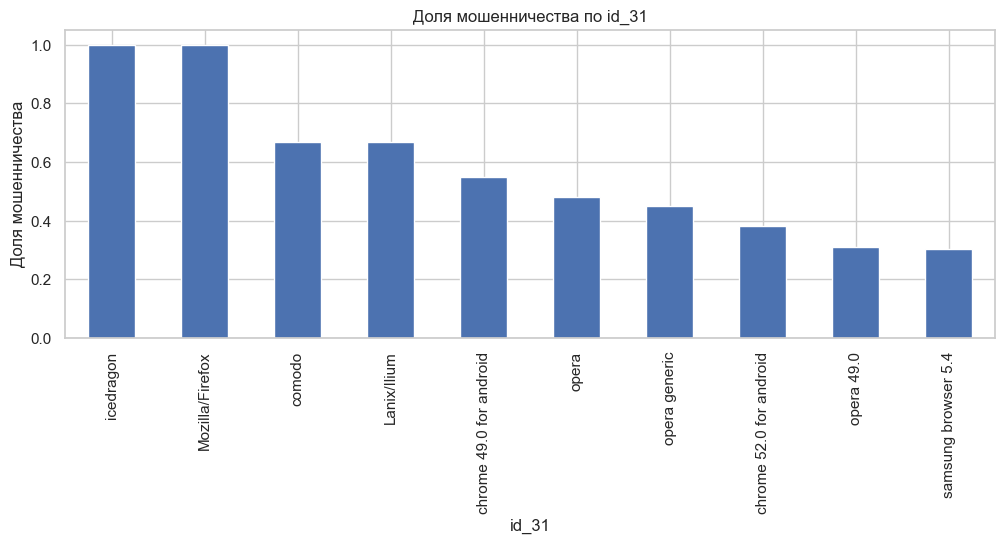


Анализ признака: id_32
id_32
unknown    0.868619
24.0       0.089869
32.0       0.041366
16.0       0.000137
0.0        0.000010
Name: proportion, dtype: float64


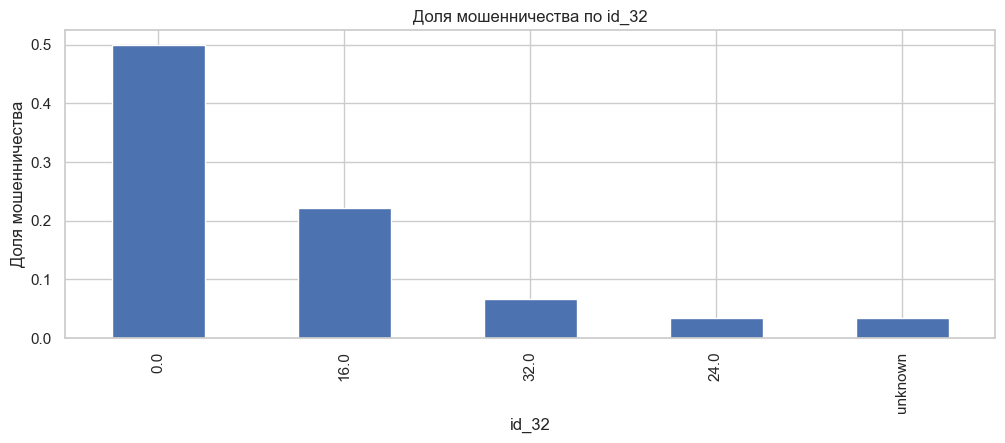


Анализ признака: id_33
id_33
unknown      0.875895
1920x1080    0.028574
1366x768     0.014571
1334x750     0.010917
2208x1242    0.008297
1440x900     0.007424
1600x900     0.005944
2048x1536    0.005896
1280x800     0.003639
2560x1600    0.003544
Name: proportion, dtype: float64


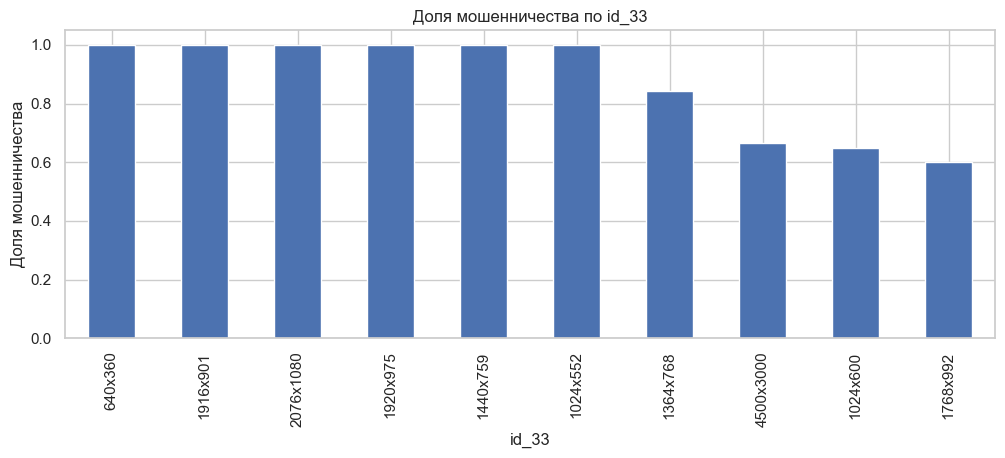


Анализ признака: id_34
id_34
unknown            0.868248
match_status:2     0.101621
match_status:1     0.029424
match_status:0     0.000703
match_status:-1    0.000005
Name: proportion, dtype: float64


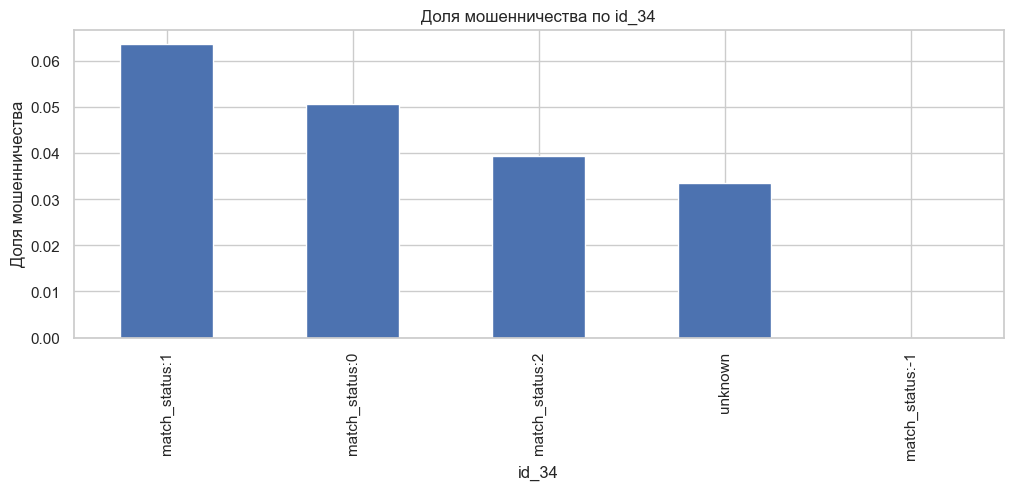


Анализ признака: id_35
id_35
unknown    0.761261
T          0.131768
F          0.106972
Name: proportion, dtype: float64


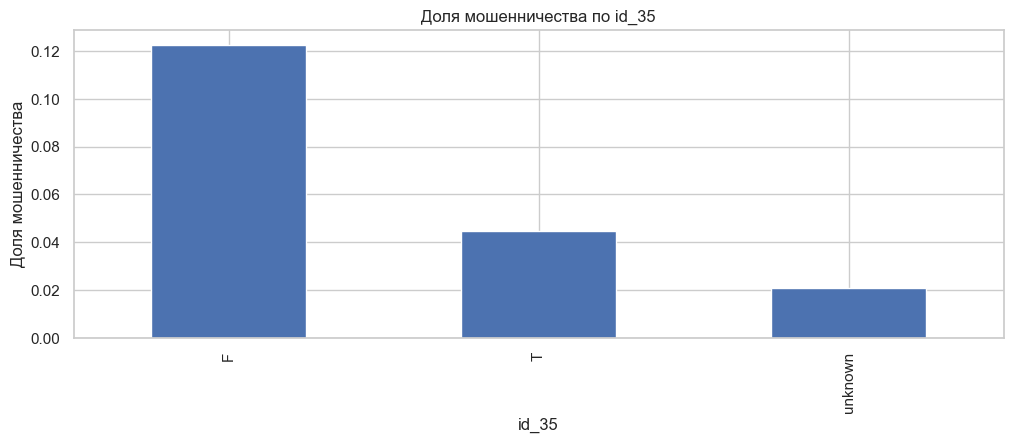


Анализ признака: id_36
id_36
unknown    0.761261
F          0.227023
T          0.011716
Name: proportion, dtype: float64


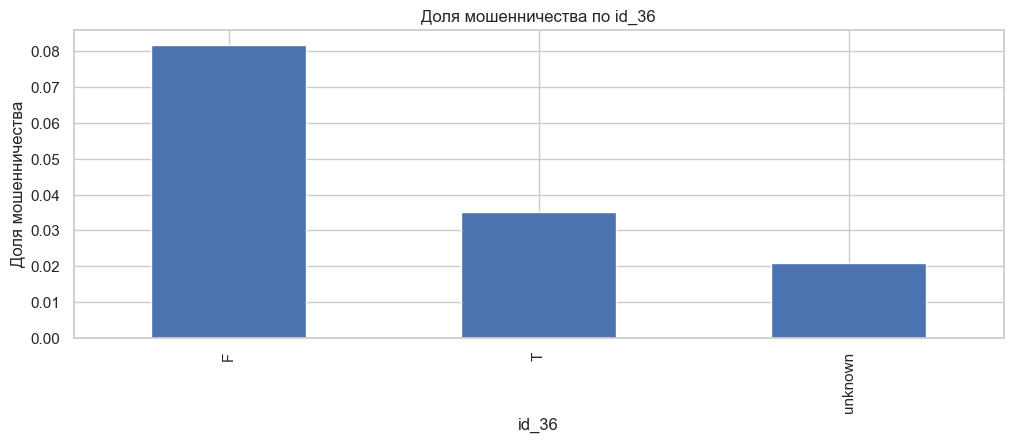


Анализ признака: id_37
id_37
unknown    0.761261
T          0.187036
F          0.051704
Name: proportion, dtype: float64


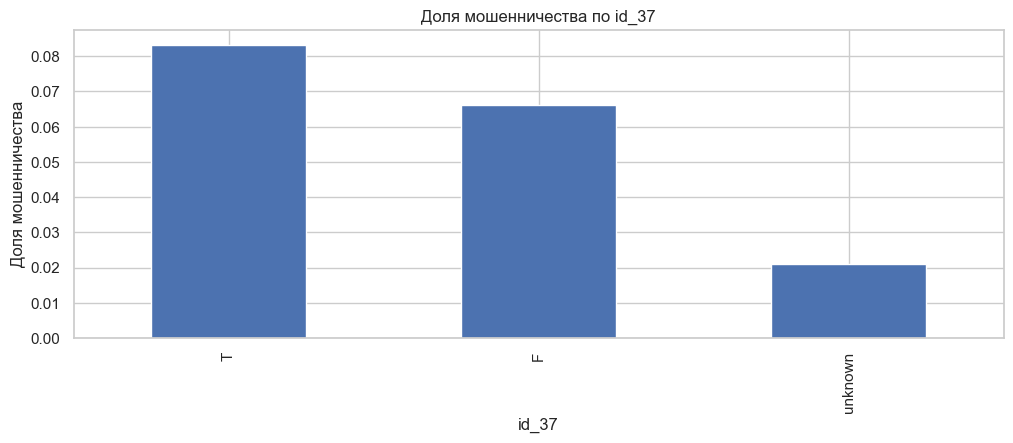


Анализ признака: id_38
id_38
unknown    0.761261
F          0.125177
T          0.113562
Name: proportion, dtype: float64


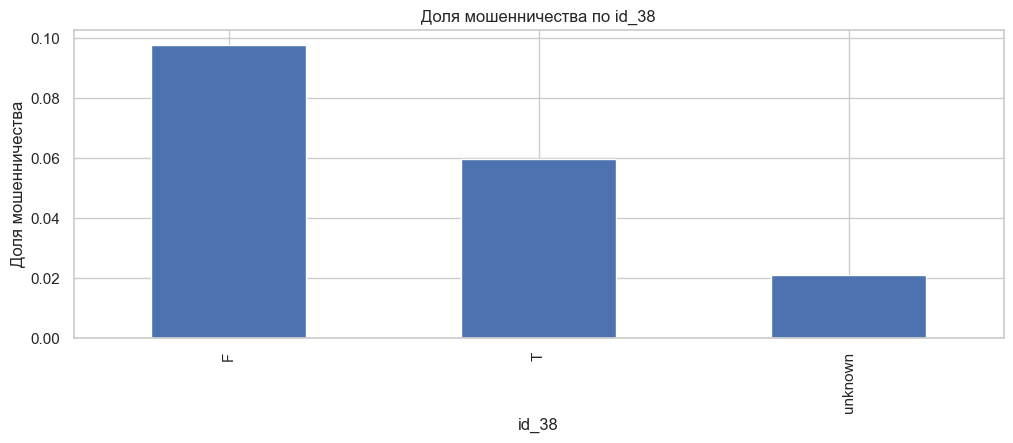


Анализ признака: M1
M1
T          0.540886
unknown    0.459071
F          0.000042
Name: proportion, dtype: float64


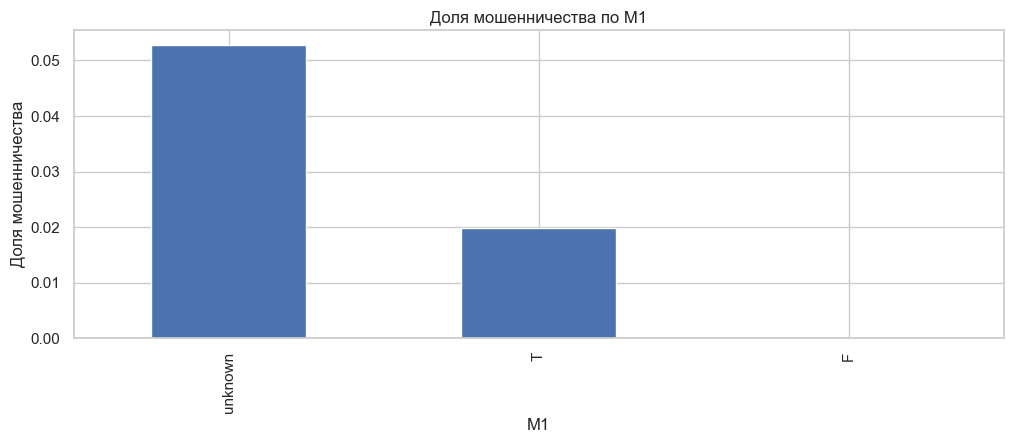


Анализ признака: M2
M2
T          0.483402
unknown    0.459071
F          0.057527
Name: proportion, dtype: float64


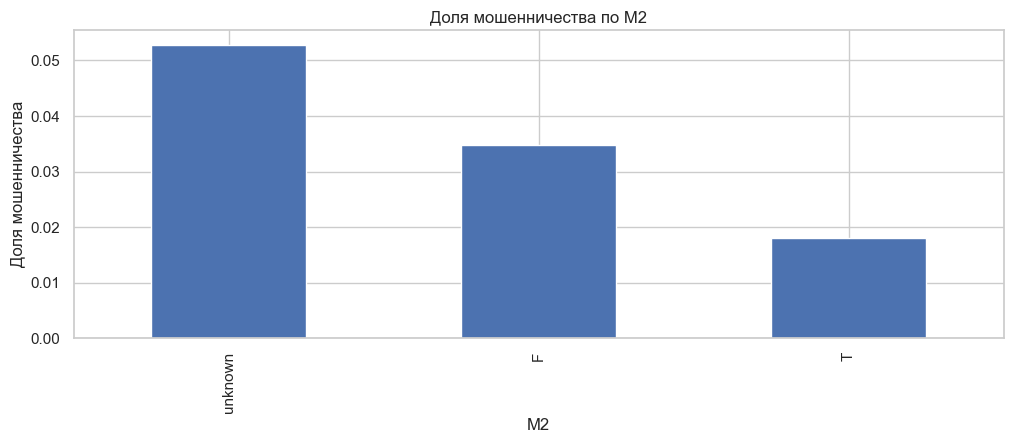


Анализ признака: M3
M3
unknown    0.459071
T          0.426273
F          0.114656
Name: proportion, dtype: float64


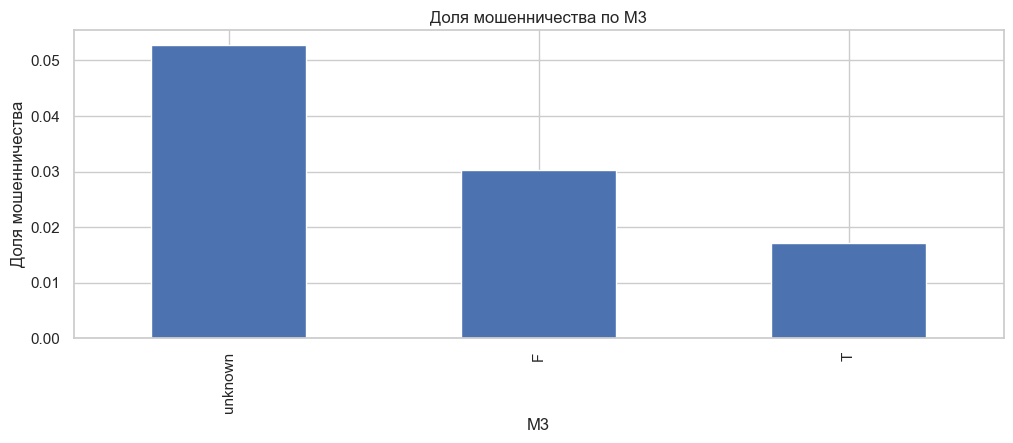


Анализ признака: M4
M4
unknown    0.476588
M0         0.332585
M2         0.101373
M1         0.089454
Name: proportion, dtype: float64


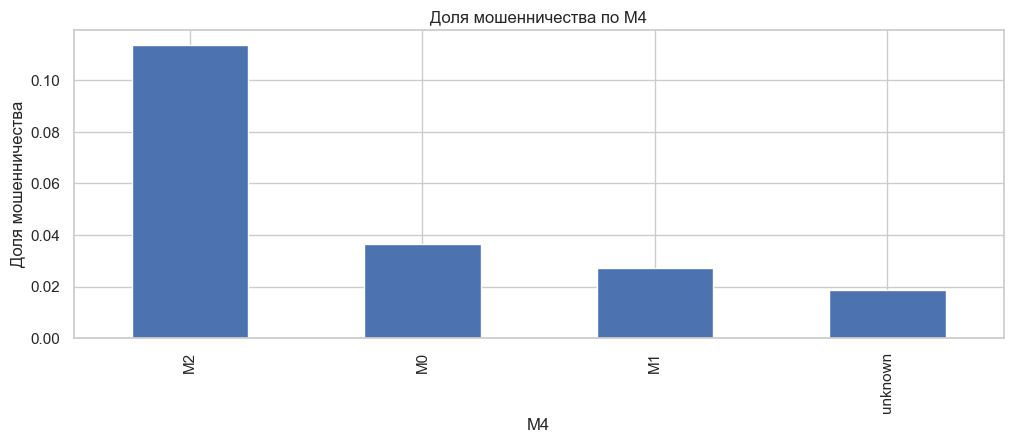


Анализ признака: M5
M5
unknown    0.593494
F          0.224356
T          0.182150
Name: proportion, dtype: float64


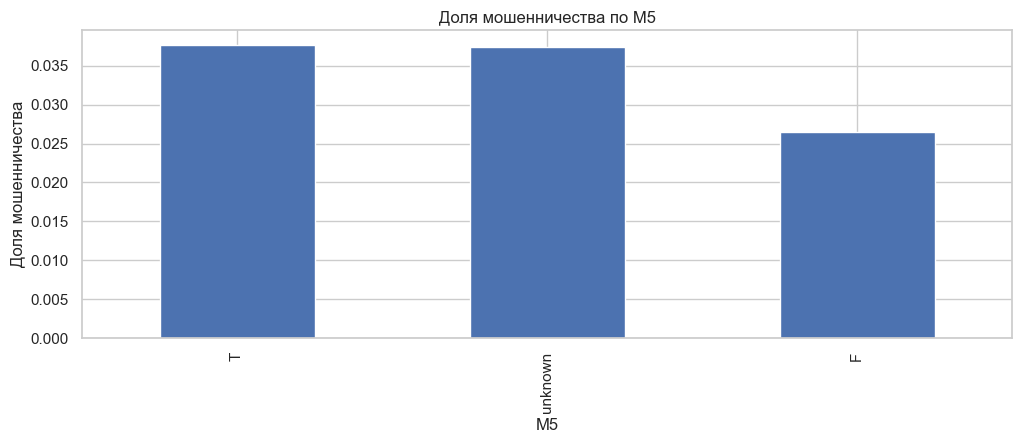


Анализ признака: M6
M6
F          0.385843
T          0.327368
unknown    0.286788
Name: proportion, dtype: float64


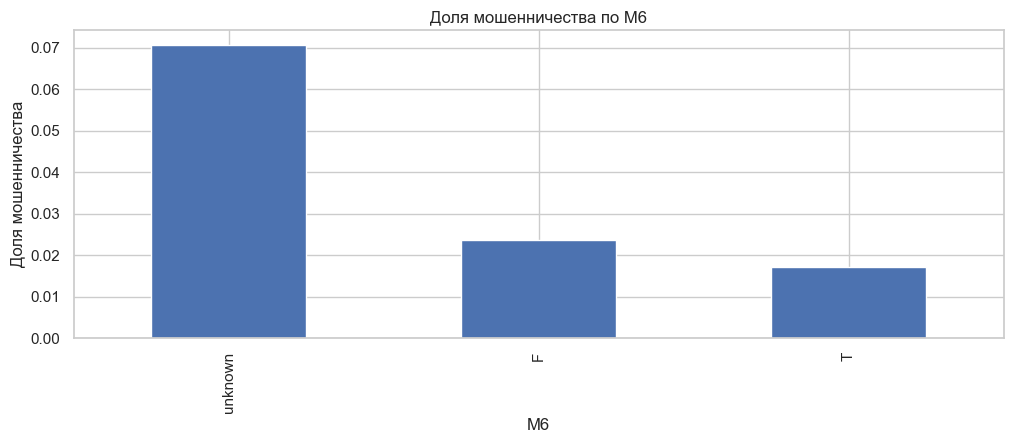


Анализ признака: M7
M7
unknown    0.586353
F          0.357933
T          0.055713
Name: proportion, dtype: float64


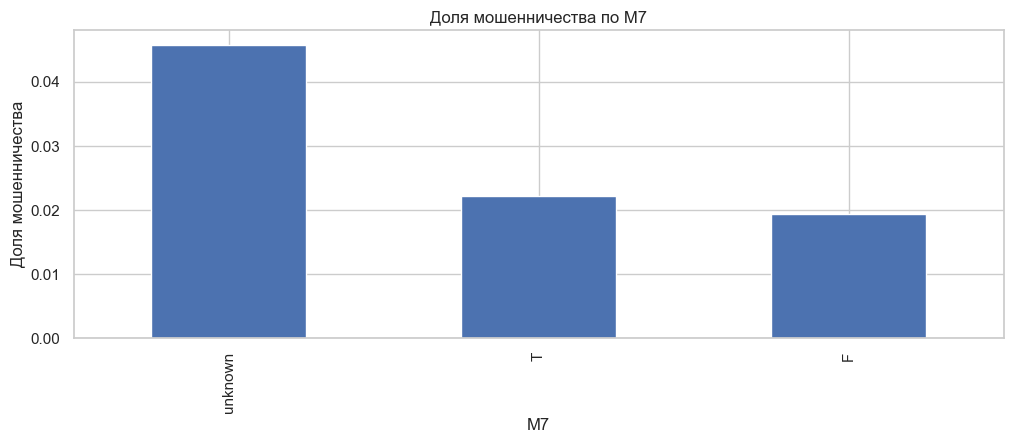


Анализ признака: M8
M8
unknown    0.586331
F          0.262897
T          0.150772
Name: proportion, dtype: float64


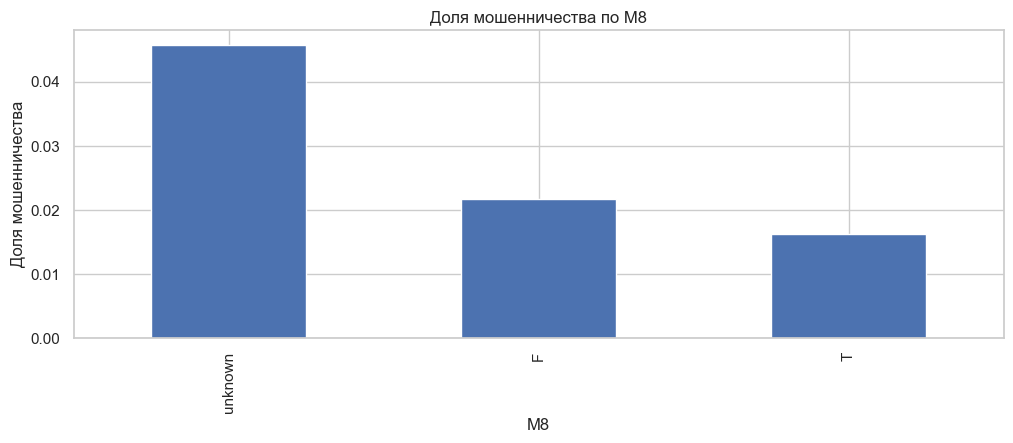


Анализ признака: M9
M9
unknown    0.586331
T          0.348251
F          0.065418
Name: proportion, dtype: float64


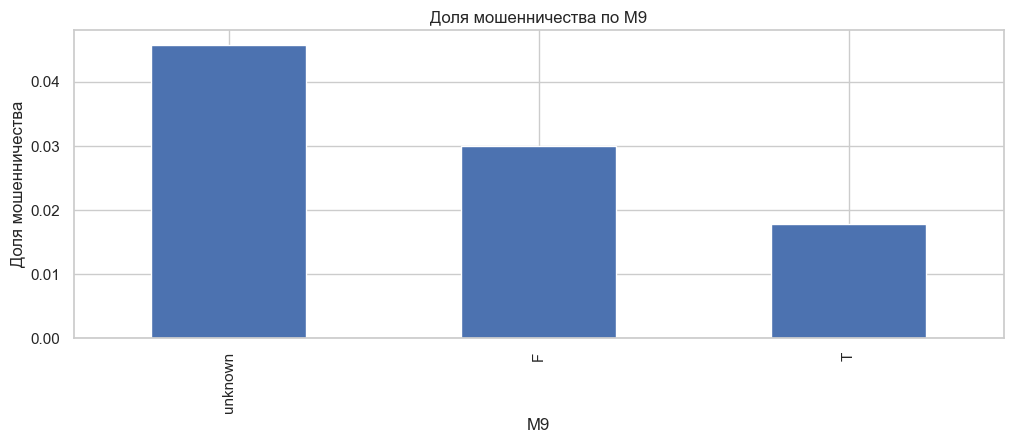

In [95]:
exclude = [
    'ProductCD', 
    'card1', 
    'card2', 
    'card3', 
    'card4', 
    'card5', 
    'card6', 
    'addr1', 
    'addr2', 
    'P_emaildomain', 
    'R_emaildomain', 
    'DeviceType',
    'DeviceInfo'
]

for col in categorical_features:
    if col in exclude:
        continue
    
    print(f'\nАнализ признака: {col}')
    print(train[col].value_counts(normalize=True).head(10))

    fraud_rate = train.groupby(col)['isFraud'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12,4))
    fraud_rate.head(10).plot(kind='bar')
    plt.title(f'Доля мошенничества по {col}')
    plt.ylabel('Доля мошенничества')
    plt.show()


### 5. Анализ числовых признаков

#### Анализ признака  dist1

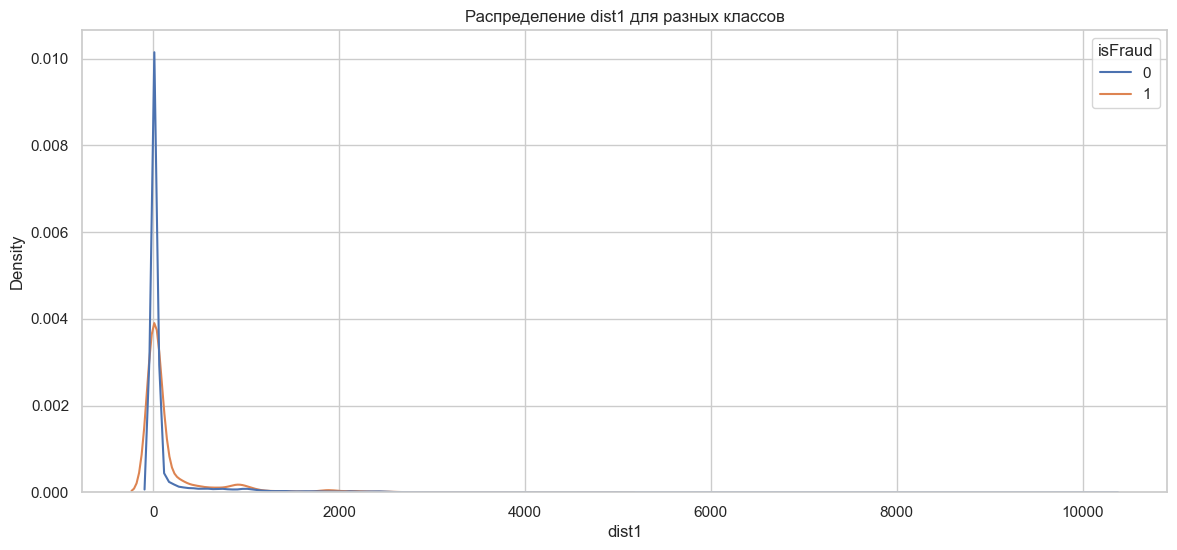

In [118]:
col = 'dist1'
plt.figure(figsize=(14,6))
sns.kdeplot(data=train, x=col, hue='isFraud', common_norm=False)
plt.title(f'Распределение {col} для разных классов')
plt.show()


### Анализ графика признака `dist1`

1. **Сосредоточенность значений:**
   - Большинство значений `dist1` сконцентрировано около 0, что отображается высоким пиком в левой части графика для обоих классов (`isFraud` = 0 и 1).

2. **Сходство распределений:**
   - Обе кривые (для мошеннических и немошеннических транзакций) имеют схожие формы и убывают относительно быстро, что указывает на распределение данных, близкое к нормальному.

3. **Редкие большие значения:**
   - Есть небольшое количество более высоких значений, растягивающее распределение вправо, что может указывать на аномальные или редкие случаи транзакций.

### Что можно сделать с признаком:

- **Дополнительный анализ редких значений:**
  - Провести исследование аномально больших значений `dist1`, чтобы выявить потенциальные риски и особенности.

- **Оценка значимости:**
  - Определить, действительно ли `dist1` является значимым признаком для выявления мошенничества в этой выборке, учитывая его схожесть для обоих классов.

#### Анализ признака  dist2

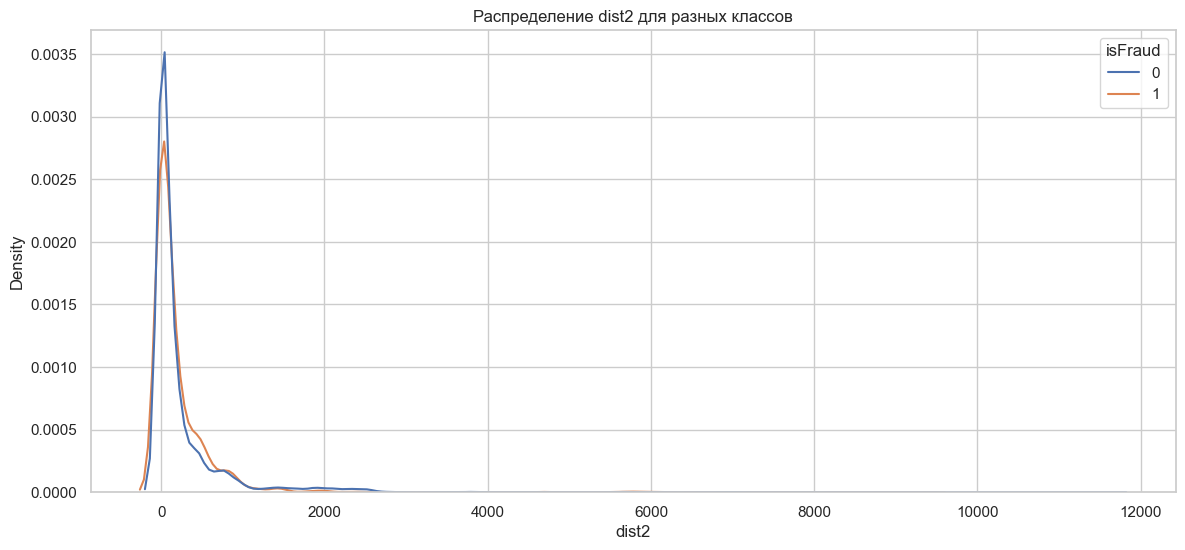

In [119]:
col = 'dist2'
plt.figure(figsize=(14,6))
sns.kdeplot(data=train, x=col, hue='isFraud', common_norm=False)
plt.title(f'Распределение {col} для разных классов')
plt.show()


### Анализ графика признака `dist2`

1. **Концентрация значений:**
   - Большинство значений `dist2` также сконцентрировано около 0, аналогично `dist1`.

2. **Схожесть распределений:**
   - Наблюдается сильное перекрытие между распределениями для мошеннических (`isFraud` = 1) и немошеннических (`isFraud` = 0) транзакций, указывая на отсутствие явных различий.

3. **Хвосты распределения:**
   - Небольшое количество более высоких значений, растягивающее распределение вправо. Это говорит о редких случаях, которые могут быть аномальными.

### Что можно сделать с признаком:

- **Анализ аномалий:**
  - Изучить редкие большие значения в `dist2`, чтобы понять, могут ли они сигнализировать о мошенничестве или ошибках.

- **Важность признака:**
  - Оценить значимость `dist2` для моделей предсказания, так как его схожесть для обоих классов может ограничивать его полезность.

### Обзор остальных признаков

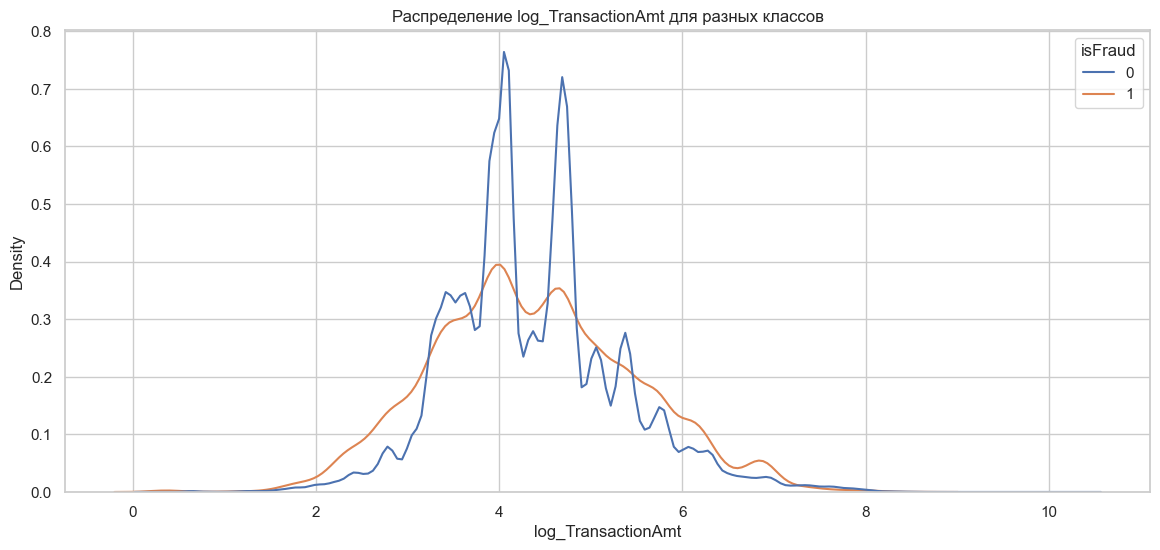

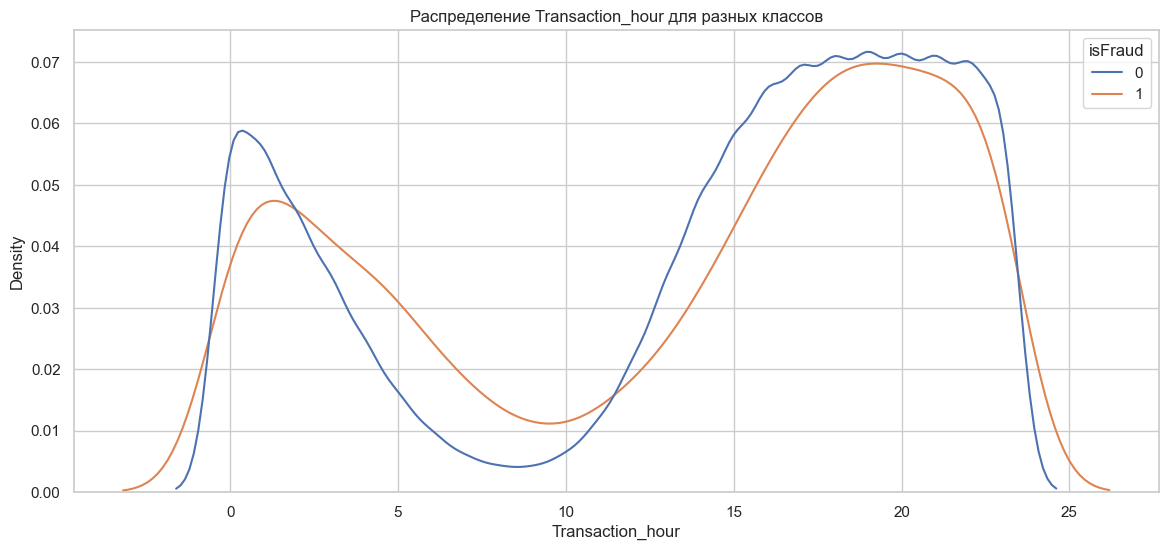

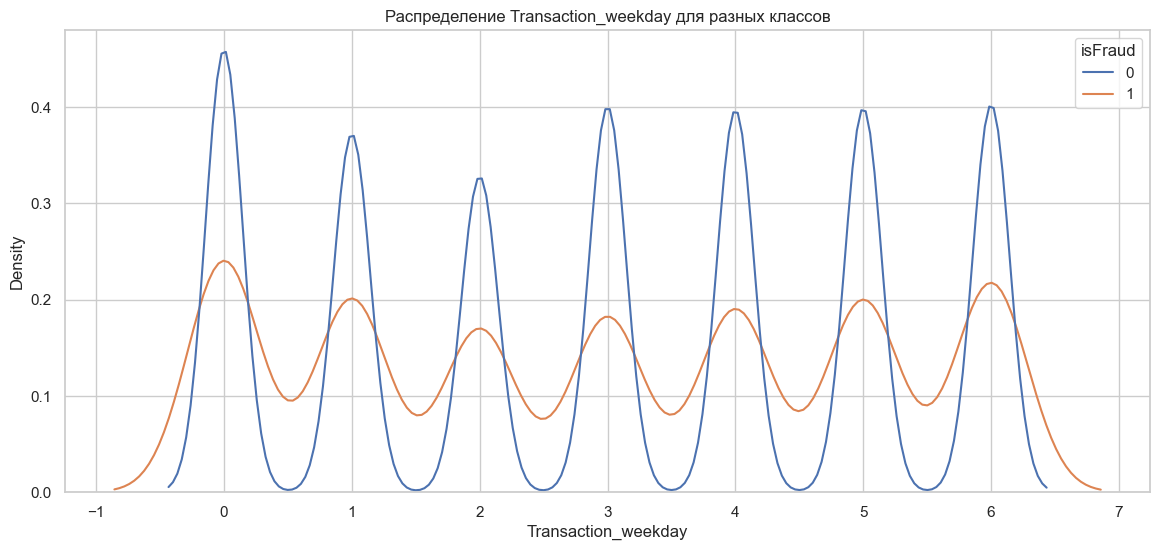

In [201]:
exclude = [
    'isFraud',
    'TransactionID',
    'TransactionDT',
    'dist1',
    'dist2', 
]

for col in numeric_features:
    if col in exclude:
        continue

    
    plt.figure(figsize=(14,6))
    sns.kdeplot(data=train, x=col, hue='isFraud', common_norm=False)
    plt.title(f'Распределение {col} для разных классов')
    plt.show()


> Если рассматривать графики в целом по всем признакам. То можно сделать вывдол что в каждом графике график класса 0 и 1 повтаряют друг друго (только с разной амплитудой и иногда с небольшим смещением)

### 6. Корреляции

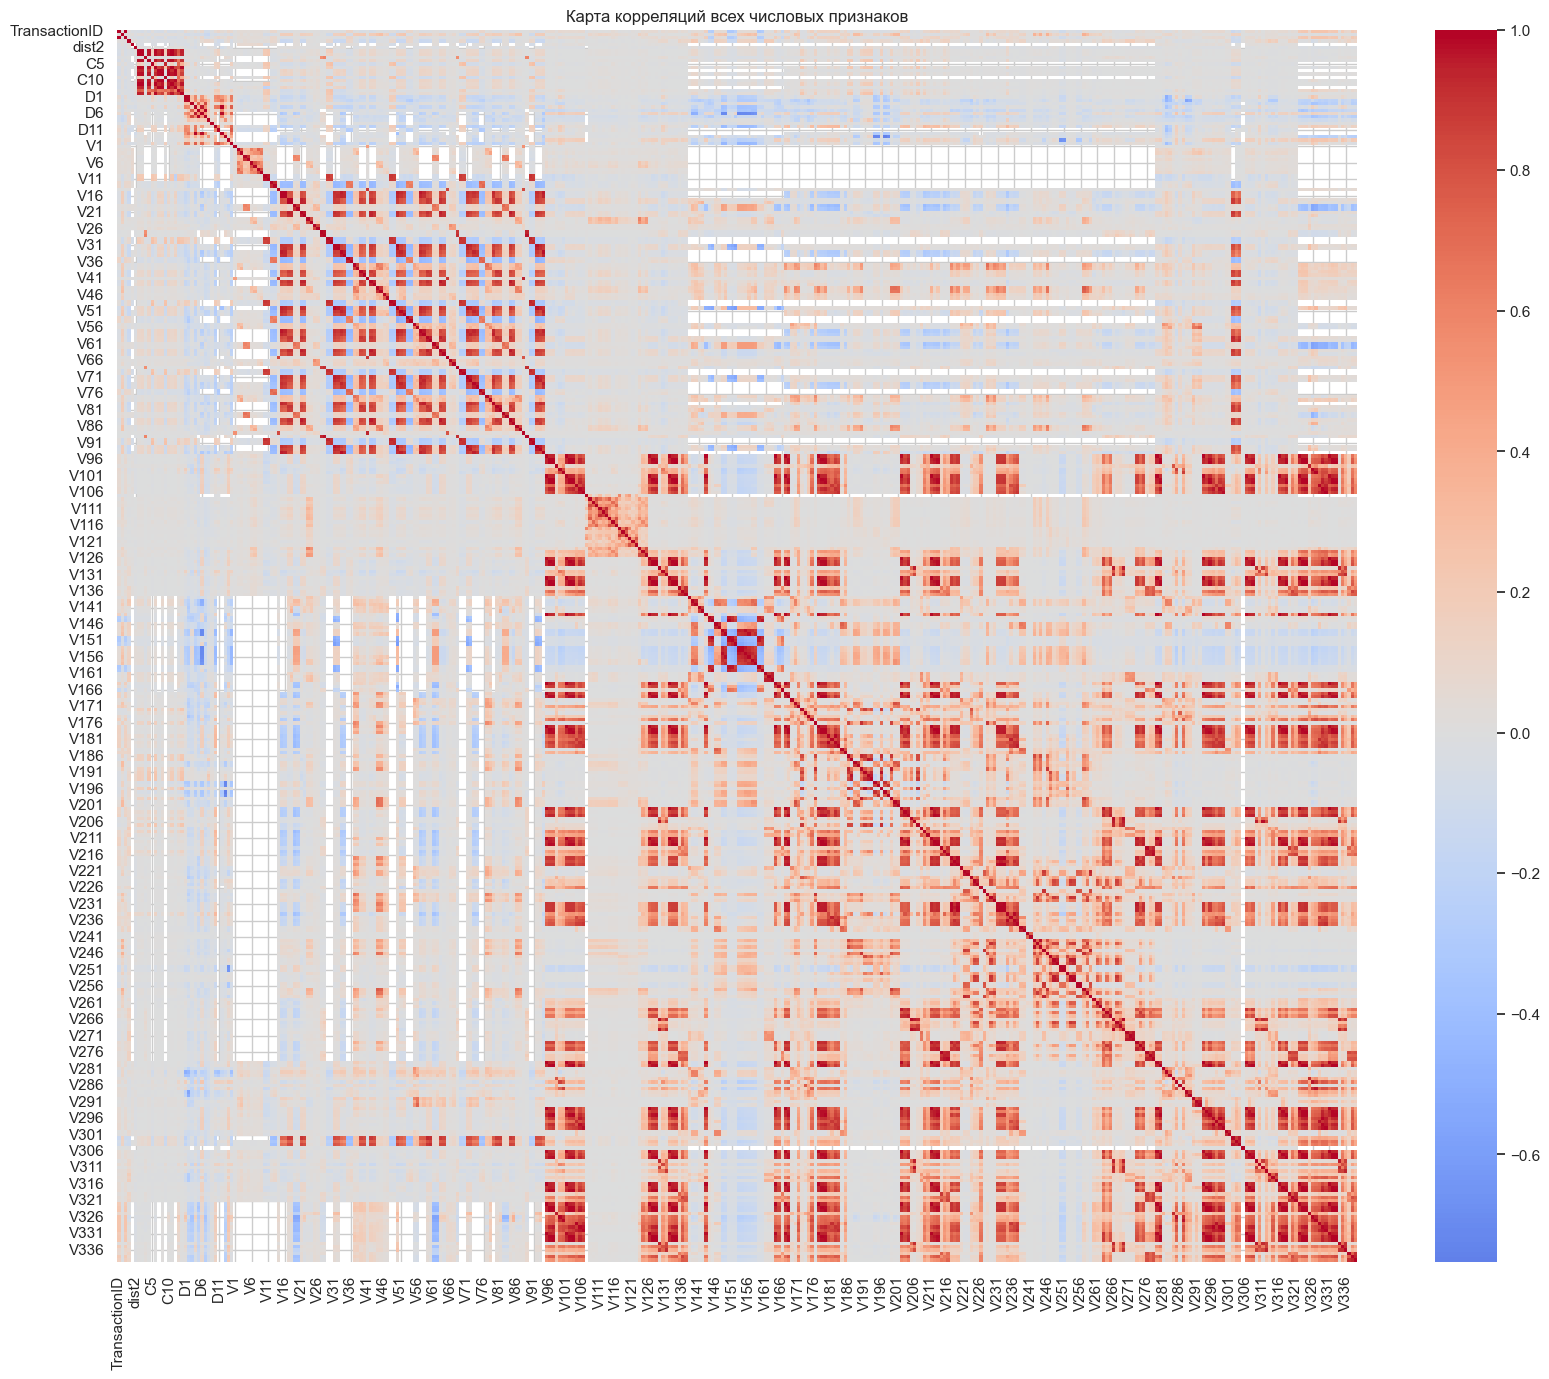

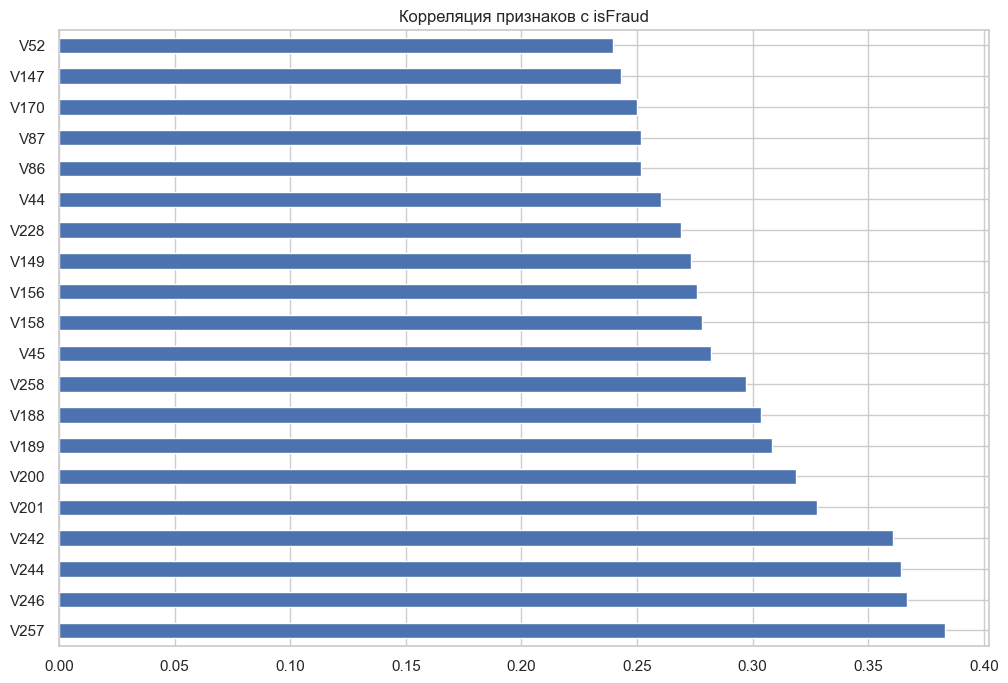

In [14]:
# Корреляционная матрица всех числовых признаков
plt.figure(figsize=(20, 16))
corr_matrix = train[numeric_features].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Карта корреляций всех числовых признаков')
plt.show()

# Корреляция признаков с isFraud
plt.figure(figsize=(12,8))
fraud_corr.head(20).plot(kind='barh')
plt.title('Корреляция признаков с isFraud')
plt.show()


### 7. Поиск выбросов

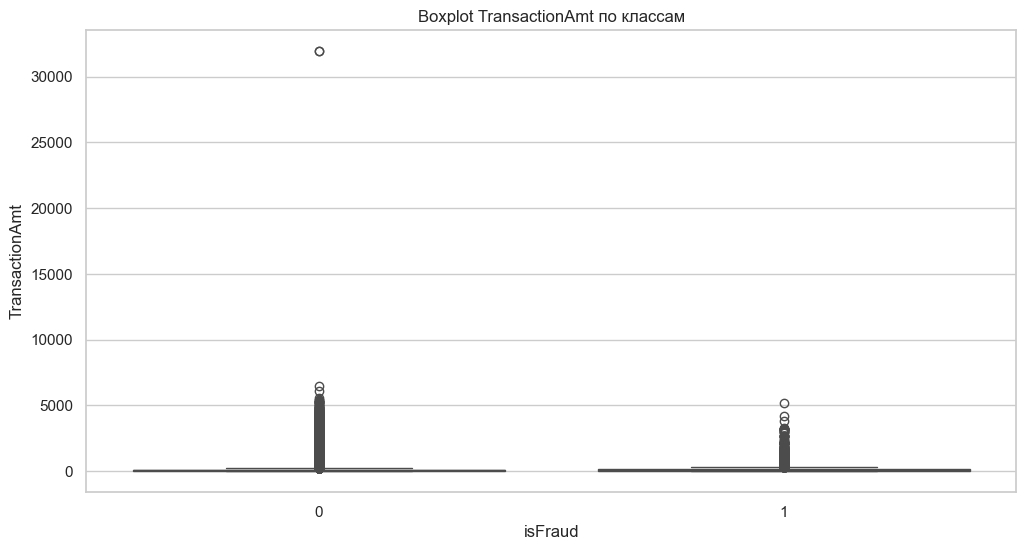

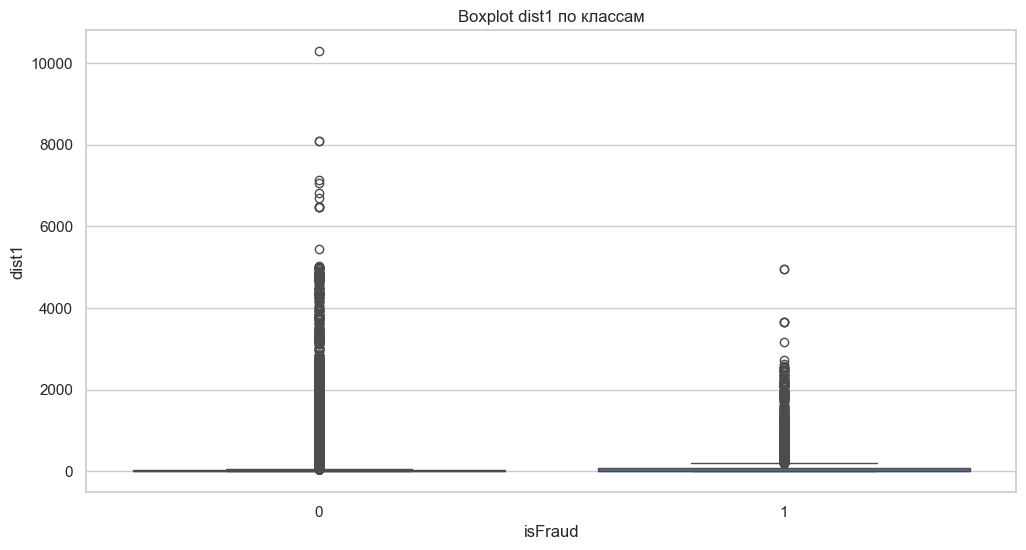

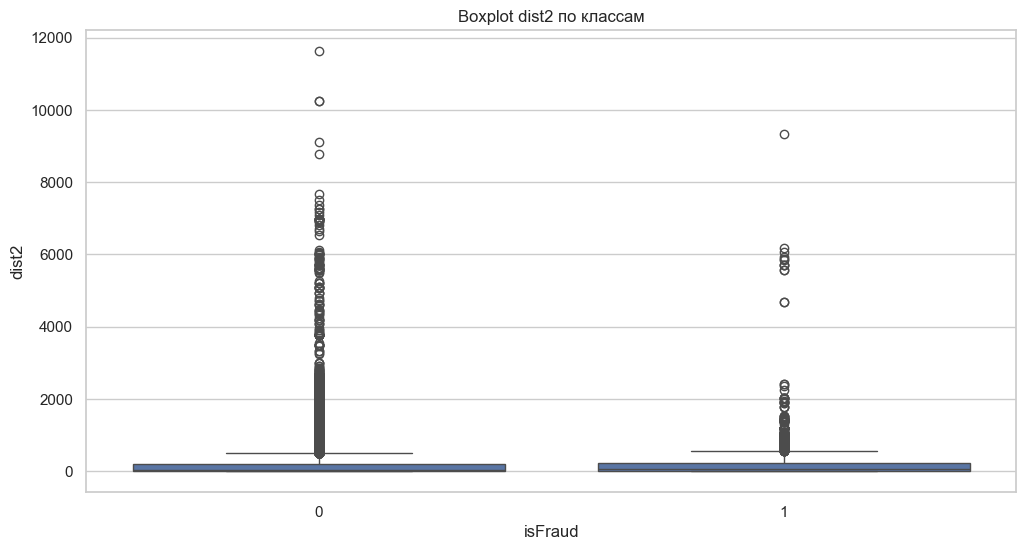

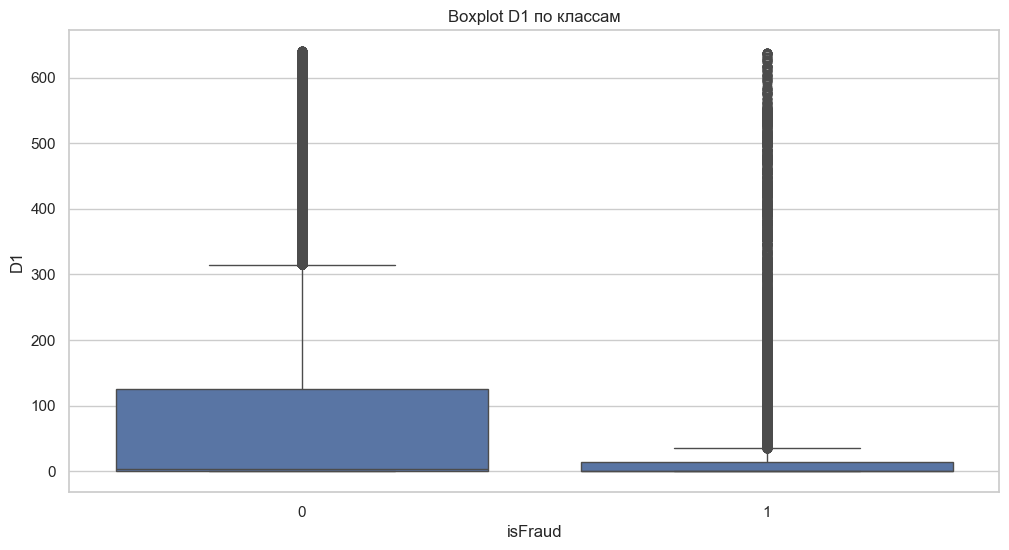

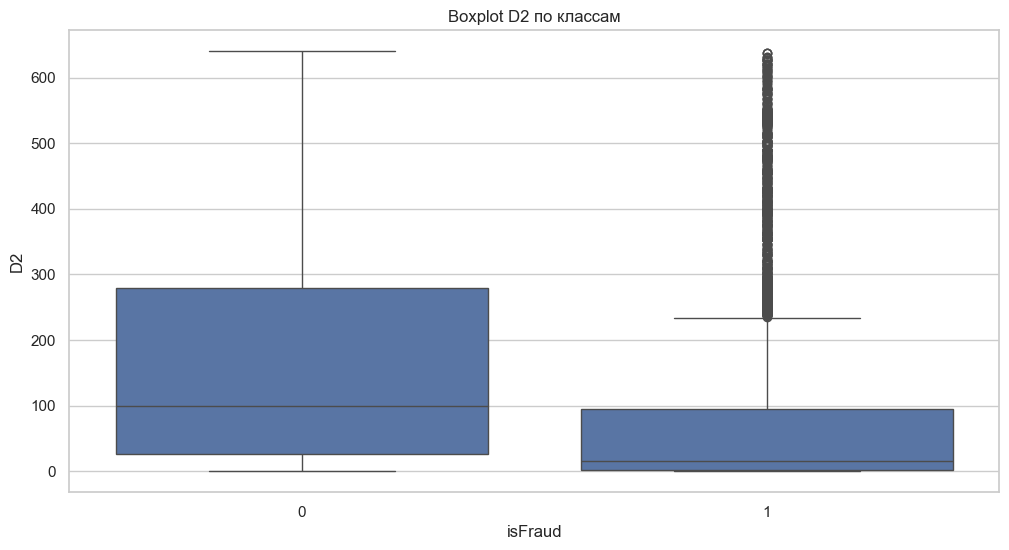

In [15]:
key_features = ['TransactionAmt', 'dist1', 'dist2', 'D1', 'D2']
for col in key_features:
    if col in train.columns:
        plt.figure(figsize=(12,6))
        sns.boxplot(x='isFraud', y=col, data=train)
        plt.title(f'Boxplot {col} по классам')
        plt.show()


## Минимальная обработка признаков

### 1. Обработка редких категорий


In [ ]:
#for col in categorical_features:
#    rare_values = train[col].value_counts()[train[col].value_counts() < 10].index
#    train[col] = train[col].apply(lambda x: 'rare' if x in rare_values else x)
#    print(f'Признак {col}: заменено {len(rare_values)} редких категорий на "rare"')


Признак ProductCD: заменено 1 редких категорий на "rare"
Признак card1: заменено 9256 редких категорий на "rare"
Признак card2: заменено 0 редких категорий на "rare"
Признак card3: заменено 56 редких категорий на "rare"
Признак card4: заменено 0 редких категорий на "rare"
Признак card5: заменено 54 редких категорий на "rare"
Признак card6: заменено 0 редких категорий на "rare"
Признак addr1: заменено 230 редких категорий на "rare"
Признак addr2: заменено 55 редких категорий на "rare"
Признак P_emaildomain: заменено 0 редких категорий на "rare"
Признак R_emaildomain: заменено 2 редких категорий на "rare"
Признак DeviceType: заменено 0 редких категорий на "rare"
Признак DeviceInfo: заменено 1273 редких категорий на "rare"
Признак id_01: заменено 48 редких категорий на "rare"
Признак id_02: заменено 115653 редких категорий на "rare"
Признак id_03: заменено 9 редких категорий на "rare"
Признак id_04: заменено 1 редких категорий на "rare"
Признак id_05: заменено 24 редких категорий на "rare

### 2. Обработка TransactionDT

> Важно! Так как `TransactionDT` - Временная метка (в секундах от некой базовой точки), то преобразования в новые признаки условное Так как у нас нет базовой точки отсчета (Предполагаю что это транзакции за какието  месяца 2018 года, но это предположение). Но как мне кажется даже в этом случае можно проследить тенденции

In [137]:
# на всякий случай отсортируем по TransactionDT
train = train.sort_values('TransactionDT')

# Найдем минимальное значение
min_timestamp = train['TransactionDT'].min()

# Преобразуем временные метки относительно минимальной
train['Relative_TransactionDT'] = train['TransactionDT'] - min_timestamp

# Преобразуем в дни, часы, минуты и т.д.
train['Transaction_day'] = train['Relative_TransactionDT'] // (24 * 60 * 60)  # в днях
train['Transaction_hour'] = (train['Relative_TransactionDT'] // 3600) % 24  # в часах
train['Transaction_weekday'] = (train['Relative_TransactionDT'] // (3600*24)) % 7
train['Transaction_day'] = train['Transaction_day'].astype(int)
train['Transaction_hour'] = train['Transaction_hour'].astype(int)
train['Transaction_weekday'] = train['Transaction_weekday'].astype(int)

# Новые признаки на основе TransactionDT
#train['weekday'] = (train['TransactionDT'] // (3600*24)) % 7
#train['hour'] = (train['TransactionDT'] // 3600) % 24


### 3. Обработка 'P_emaildomain', 'R_emaildomain'

In [138]:

# Группировка email-доменов
#email_domains = {
#    'google': 'gmail', 'gmail': 'gmail', 'att.net': 'other', 'twc.com': 'other',
#    'scranton.edu': 'other', 'verizon.net': 'other', 'protonmail.com': 'other',
#    'aol.com': 'aol', 'hotmail.com': 'hotmail', 'yahoo.com': 'yahoo', 
#    'yahoo.com.mx': 'yahoo', 'outlook.com': 'microsoft', 'icloud.com': 'apple'
#}
#for col in ['P_emaildomain', 'R_emaildomain']:
#    if col in train.columns:
#        train[col] = train[col].apply(lambda x: email_domains.get(x.split('.')[0], 'other'))

### 4. TransactionAmt - Анализ и очистка выбросов

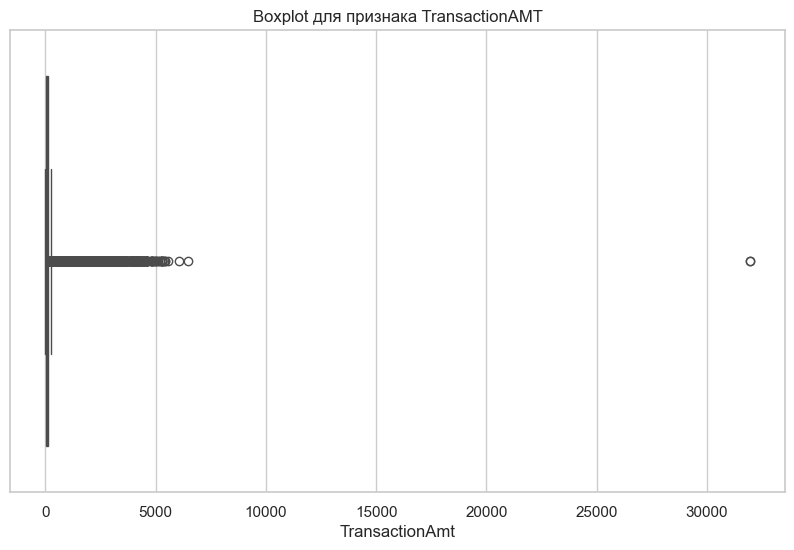

Границы для выбросов: -79.20 - 247.52
Число выбросов в TransactionAmt: 66482
    TransactionAmt  isFraud
7           422.50        0
31          363.89        0
41          774.00        0
56          500.00        0
58          380.21        0


In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Построим boxplot для анализа выбросов в TransactionAMT
plt.figure(figsize=(10, 6))
sns.boxplot(x=train['TransactionAmt'])
plt.title('Boxplot для признака TransactionAMT')
plt.show()

# Рассчитаем статистику для выявления выбросов
q1 = train['TransactionAmt'].quantile(0.25)  # 25-й перцентиль
q3 = train['TransactionAmt'].quantile(0.75)  # 75-й перцентиль
iqr = q3 - q1  # Интерквартильный размах

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Границы для выбросов: {lower_bound:.2f} - {upper_bound:.2f}")

# Выбросы — это значения, которые лежат за пределами этих границ
outliers = train[(train['TransactionAmt'] < lower_bound) | (train['TransactionAmt'] > upper_bound)]
print(f"Число выбросов в TransactionAmt: {outliers.shape[0]}")
print(outliers[['TransactionAmt', 'isFraud']].head())


### Что делать с выбросами:

#### 1 Понимание контекста данных:


Сначала нужно проанализировать, не являются ли эти выбросы важными. Например, большие транзакции могут быть связаны с мошенничеством, и важно определить, как они коррелируют с целевой переменной isFraud. Для этого можно исследовать, какой процент мошенничеств происходит среди этих выбросов.

In [140]:
# Анализируем выбросы по классу isFraud
outliers_fraud = outliers['isFraud'].value_counts(normalize=True)
print(f"Распределение классов среди выбросов: {outliers_fraud}")


Распределение классов среди выбросов: isFraud
0    0.94928
1    0.05072
Name: proportion, dtype: float64


#### 2 Визуализация выбросов

Построим график, который покажет, как выбросы соотносятся с транзакциями. Это поможет понять, стоит ли их удалять или оставлять.

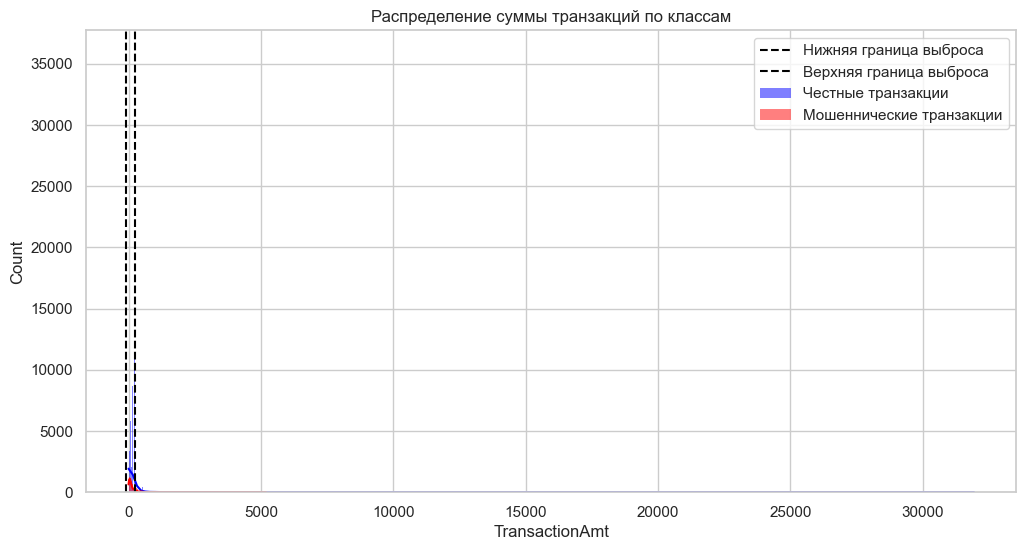

In [141]:
# Визуализация выбросов на графике
plt.figure(figsize=(12, 6))
sns.histplot(train[train['isFraud'] == 0]['TransactionAmt'], kde=True, color='blue', label='Честные транзакции')
sns.histplot(train[train['isFraud'] == 1]['TransactionAmt'], kde=True, color='red', label='Мошеннические транзакции')
plt.axvline(x=lower_bound, color='black', linestyle='--', label='Нижняя граница выброса')
plt.axvline(x=upper_bound, color='black', linestyle='--', label='Верхняя граница выброса')
plt.legend()
plt.title('Распределение суммы транзакций по классам')
plt.show()


Распределение классов среди выбросов показывает, что **только 5.07%** выбросов — это мошенничество (**`isFraud = 1`**), в то время как большинство выбросов (94.93%) приходится на честные транзакции (**`isFraud = 0`**).

### Выводы:

1. **Мошенничество среди выбросов**:
   - Это относительно небольшая доля. Это может означать, что выбросы, скорее всего, представляют собой редкие или экстраординарные транзакции, которые не обязательно связаны с мошенничеством. Возможно, это крупные, но не мошеннические транзакции.

2. **Что с этим делать**:
   - Поскольку мошенничество среди выбросов — это небольшая доля, можно рассматривать два подхода:
     - **Удалить выбросы**: Если выбросы действительно ошибочные или экстремальные, можно их удалить, так как они составляют меньшую часть данных.
     - **Оставить выбросы**: Поскольку они не столь сильно влияют на класс мошенничества, можно оставить их в данных, если они не слишком искажают общую картину.

В случае, если выбросы оставляем, то можно **применить трансформации**, такие как логарифмическое преобразование или бинирование.

Для **антифродовой задачи** (предсказания мошенничества), важным фактором является правильная обработка признаков, таких как сумма транзакции, чтобы модель могла эффективно различать мошеннические и честные транзакции, особенно когда суммы могут сильно варьироваться.


Для антифродовой задачи начнем с **логарифмирования**, так как это позволит модели учитывать широкий диапазон транзакций (включая большие суммы, которые могут быть мошенническими), не теряя важную информацию. Но и применим **бинирование** как дополнительный шаг для анализа и для улучшения интерпретируемости модели.


In [142]:
import numpy as np

# Преобразование столбца TransactionAMT
train['log_TransactionAmt'] = np.log1p(train['TransactionAmt'])

In [143]:

bins = [0, 100, 1000, 5000, 10000, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High', 'Extremely High']

train['TransactionAmt_binned'] = pd.cut(train['TransactionAmt'], bins=bins, labels=labels)

# Альтернативный способ:  Биннинг суммы транзакции по квантилям
#train['TransactionAmt_bin'] = pd.qcut(train['TransactionAmt'], q=10, duplicates='drop')


#### Добавление признака выброса

Чтобы модель могла учитывать выбросы и их связь с мошенничеством, можно добавить новый признак, который будет отмечать, является ли транзакция выбросом.

In [144]:
train['isOutlier'] = ((train['TransactionAmt'] < lower_bound) | (train['TransactionAmt'] > upper_bound)).astype(int)

Это поможет модели явно учитывать, что транзакция относится к выбросам, что может быть полезно для предсказания мошенничества.

In [145]:
train[['TransactionAmt', 'log_TransactionAmt', 'TransactionAmt_binned']].describe()

TransactionAmt  log_TransactionAmt
count   590540.000000       590540.000000
mean       135.027176            4.382960
std        239.162522            0.937183
min          0.251000            0.223943
25%         43.321000            3.791459
50%         68.769000            4.245190
75%        125.000000            4.836282
max      31937.391000           10.371564

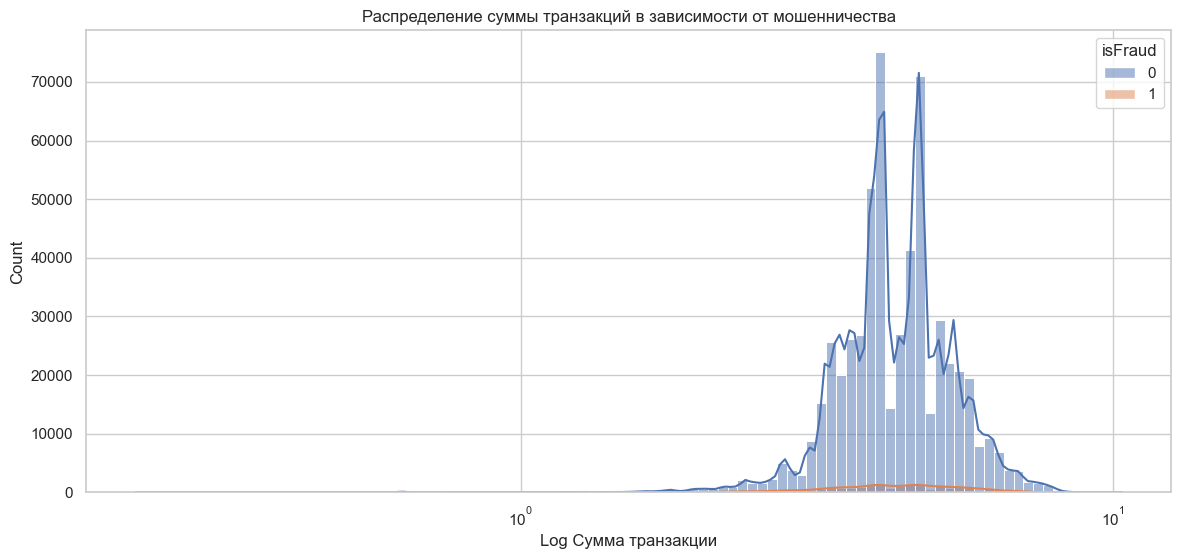

In [146]:
# Распределение сумм транзакций
plt.figure(figsize=(14,6))
sns.histplot(data=train, x='log_TransactionAmt', hue='isFraud', bins=100, log_scale=True, kde=True)
plt.title('Распределение суммы транзакций в зависимости от мошенничества')
plt.xlabel('Log Сумма транзакции')
plt.show()


## Отбор признаков

## 1. **Выберем только простые и базовые признаки**
- Те, которые **прямо интерпретируются**.
- Те, которые **легко обработать без сложных трюков**.

✅ Обычно это:
- **Нумерические признаки** без пропусков (`TransactionAmt`, `TransactionDT`, и т.п.).
- **Категориальные признаки** с небольшим количеством уникальных значений (`card4`, `card6`, `ProductCD`, `P_emaildomain`).

❗ Игнорируем на старте:
- Очень "грязные" фичи с кучей пропусков.
- Очень высоко-кардинальные фичи (`card1`, `addr2`, и т.д. с 10 000+ уникальными значениями).

## 2. **Минимальная обработка признаков**
- Для числовых — оставим как есть или логарифмируем.
- Для категориальных — **Label Encoding** или **One-Hot Encoding**.
- **Без сложных** feature engineering.

Идея baseline:  
> "Проверить, можно ли получить разумное качество на самых простых признаках."

## 3. **Интуитивный отбор**

Выбираем признаки, которые **по смыслу** могут быть связаны с задачей.  
Для задачи фрода:
- Размер транзакции (`TransactionAmt`).
- Тип карты (`card4`).
- Время транзакции (`hour`, `weekday`).
- Тип email-адреса (`P_emaildomain`).
- device_info (`DeviceType`, `DeviceInfo`).

## 4. **Технические фильтры признаков**
После выбора можно сделать быстрые проверки:
- ❌ Убрать признаки с **>90% одного значения** (например, если 95% пользователей имеют одну страну).
- ❌ Убрать признаки с **>90% пропусков** (на старте проще без них).
- ❌ Убрать признаки с **уникальными значениями = числу строк** (например, `TransactionID` — это уникальный ID каждой строки, бесполезный для модели).


## 5. **Строим baseline модель**
Типичная связка:
- Модель: `LightGBM`, `CatBoost`, `XGBoost`, `LogisticRegression`, `RandomForest`.
- Потери: **LogLoss**, **AUC ROC**.

Просто запускаем без оптимизаций. Смотрим, **какое качество вообще возможно без ухищрений**.

# 🧠 Главное правило baseline:
> Сделать настолько простую модель, чтобы потом точно видеть — где улучшения работают.

In [147]:
base_columns = [
    'isFraud',
    'log_TransactionAmt',
    'TransactionAmt_binned',
    'ProductCD',
    'card4',
    'card6',
    'Transaction_hour', 
    'Transaction_weekday',
    'P_emaildomain',
    'DeviceType',
    'DeviceInfo'
]

train[base_columns].head()

isFraud  log_TransactionAmt TransactionAmt_binned ProductCD       card4  \
0        0            4.241327                   Low         W    discover   
1        0            3.401197                   Low         W  mastercard   
2        0            4.094345                   Low         W        visa   
3        0            3.931826                   Low         W  mastercard   
4        0            3.931826                   Low         H  mastercard   

    card6  Transaction_hour  Transaction_weekday P_emaildomain DeviceType  \
0  credit                 0                    0       unknown    unknown   
1  credit                 0                    0     gmail.com    unknown   
2   debit                 0                    0   outlook.com    unknown   
3   debit                 0                    0     yahoo.com    unknown   
4  credit                 0                    0     gmail.com     mobile   

                      DeviceInfo  
0                        unknown  
1                        unknown  
2                        unknown  
3                        unknown  
4  SAMSUNG SM-G892A Build/NRD90M

In [148]:
from sklearn.calibration import LabelEncoder


numeric_features = ['log_TransactionAmt', 'Transaction_hour', 'Transaction_weekday']
categorical_features = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'DeviceType', 'DeviceInfo']

base_train = train.copy()

# Легкая предобработка
for col in categorical_features:
    base_train[col] = base_train[col].fillna('unknown')
    le = LabelEncoder()
    base_train[col] = le.fit_transform(base_train[col])


base_train[numeric_features + categorical_features].head()

log_TransactionAmt  Transaction_hour  Transaction_weekday  ProductCD  \
0            4.241327                 0                    0          4   
1            3.401197                 0                    0          4   
2            4.094345                 0                    0          4   
3            3.931826                 0                    0          4   
4            3.931826                 0                    0          1   

   card4  card6  P_emaildomain  DeviceType  DeviceInfo  
0      1      1             48           2        1774  
1      2      1             16           2        1774  
2      4      2             35           2        1774  
3      2      2             54           2        1774  
4      2      1             16           1         954

In [149]:
# Простая модель
X = base_train[numeric_features + categorical_features]
y = base_train['isFraud']

1. **Разделим данные на обучение и валидацию.**
   - Если это транзакции во времени (как в фроде) — разбиение должно быть аккуратным, **без перемешивания**.
   - Иначе — стандартное `train_test_split`.

In [152]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

### LogisticRegression

In [193]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

Recall: 0.0000
ROC-AUC: 0.6917
PR-AUC: 0.0976


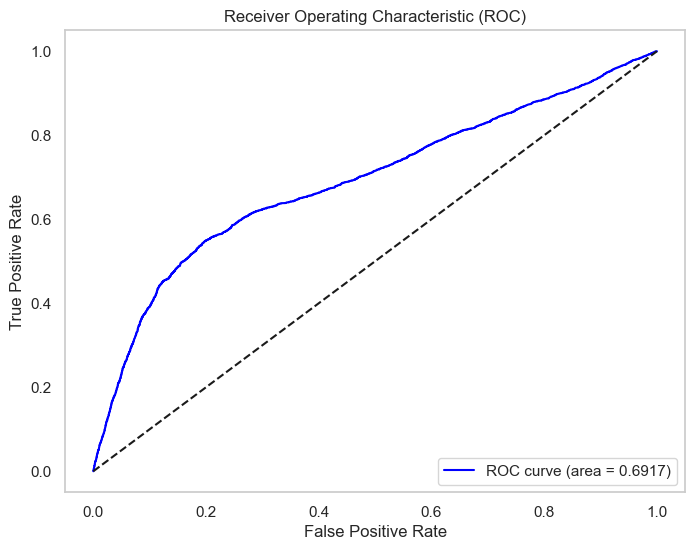

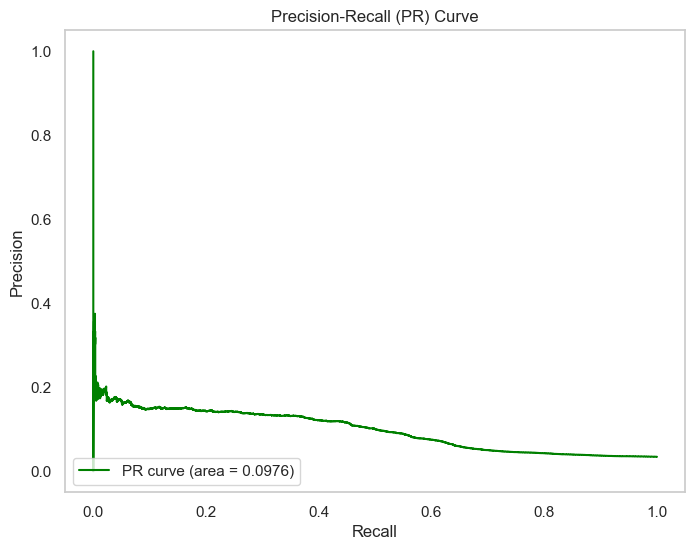

In [194]:
eval(model, X_val, y_val)

### Анализ метрик и графиков базовой модели

#### Метрики:

- **Recall: 0.0000**
  - Полное отсутствие правильного выявления положительных классов.
  - Модель не способна определить истинные случаи мошенничества.
  
- **ROC-AUC: 0.6917**
  - Среднее качество предсказаний.
  - Модель чуть лучше случайного угадывания, но все еще далеко от идеала.

- **PR-AUC: 0.0976**
  - Очень низкая точность на фоне выбранных данных.
  - Модель испытывает затруднения с выявлением положительных классов при наличии дисбаланса.

#### ROC-кривая

- **Форма кривой:**
  - Близка к диагонали, что указывает на слабую способность различать классы.
  - Возможны улучшения через тюнинг модели или использование дополнительных признаков.

#### PR-кривая

- **Форма кривой:**
  - Резкое снижение precision при увеличении recall.
  - Множество ложных срабатываний при попытке улучшить выявление положительных случаев.

### RandomForest

In [195]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Recall: 0.0327
ROC-AUC: 0.7037
PR-AUC: 0.0934


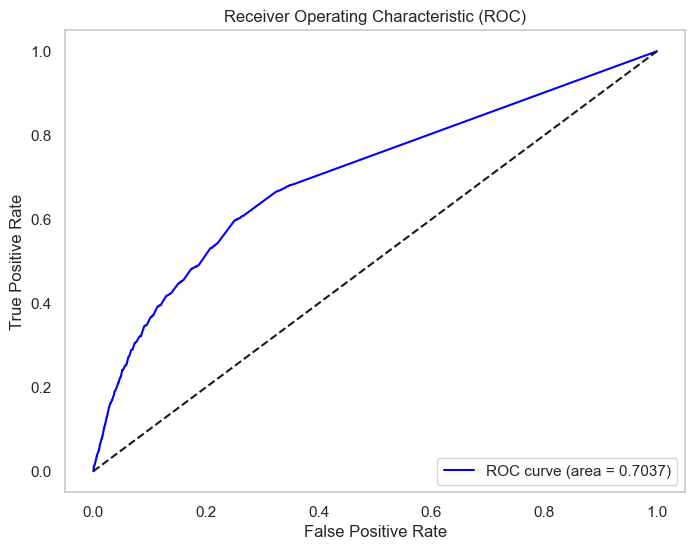

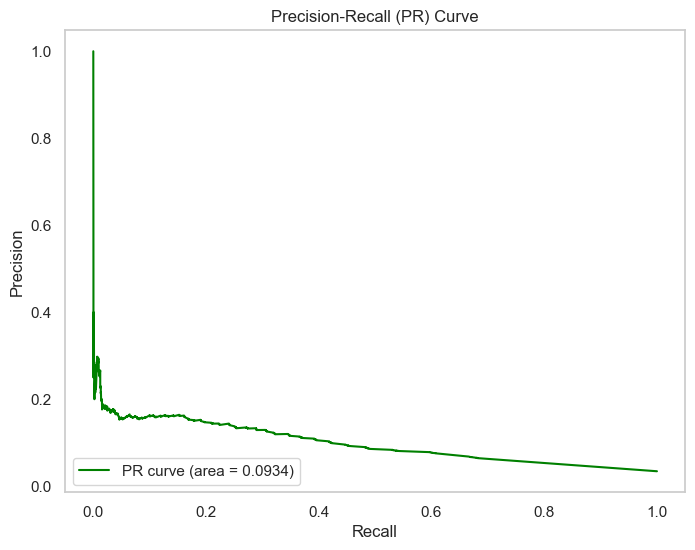

In [196]:
eval(model, X_val, y_val)

### Анализ метрик и графиков для модели

#### Метрики

- **Recall: 0.0327**
  - Очень низкая полнота, что свидетельствует о том, что модель не находит большинство случаев класса "мошенничество".
  
- **ROC-AUC: 0.7037**
  - Модель немного лучше отличает классы, чем случайное угадывание.
  - Есть небольшой прогресс по сравнению с LogisticRegression, но все еще далеко от идеала.

- **PR-AUC: 0.0934**
  - Низкое значение указывает на трудности модели в условиях дисбаланса классов.

#### ROC-кривая

- **Форма кривой:**
  - Кривая слегка отходит от диагонали. Это говорит о том, что модель обладает ограниченной способностью различать классы.

#### PR-кривая

- **Форма кривой:**
  - Резкое снижение показателей precision при увеличении recall.
  - Сложности с позитивными предсказаниями на фоне доминирующих негативных примеров.

### Поиск наилучших гиперпараметров

In [197]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score

# Сортируем данные по времени
#train = train.sort_values('TransactionDT')

#X = train.drop(columns=['isFraud'])
#y = train['isFraud']

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    # Параметры Random Forest
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  # исправлено
        'random_state': 42,
        'n_jobs': -1,
    }
    
    # Создаём модель
    model = RandomForestClassifier(**params)
    
    # Кросс-валидация по времени
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='roc_auc')
    
    # Оптимизируем среднее значение ROC AUC
    return scores.mean()

# Оптимизация
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Лучшие параметры:', study.best_params)


[I 2025-04-29 11:59:25,353] A new study created in memory with name: no-name-64420c7e-5c85-4540-bbf9-09d093acc864
[I 2025-04-29 11:59:57,543] Trial 0 finished with value: 0.7688376403089162 and parameters: {'n_estimators': 671, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.7688376403089162.
[I 2025-04-29 12:00:49,264] Trial 1 finished with value: 0.7704144649787772 and parameters: {'n_estimators': 982, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7704144649787772.
[I 2025-04-29 12:01:27,498] Trial 2 finished with value: 0.7688069727515662 and parameters: {'n_estimators': 781, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7704144649787772.
[I 2025-04-29 12:01:54,569] Trial 3 finished with value: 0.7519874063211354 and parameters: {'n_estimators': 317, 'max_depth': 18, 'min

Лучшие параметры: {'n_estimators': 801, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'log2'}


In [199]:

params = {'n_estimators': 801, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'log2', 'random_state': 42}
model = RandomForestClassifier(**params)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features='log2', min_samples_leaf=11,
                       min_samples_split=17, n_estimators=801, random_state=42)

Recall: 0.0054
ROC-AUC: 0.7689
PR-AUC: 0.1813


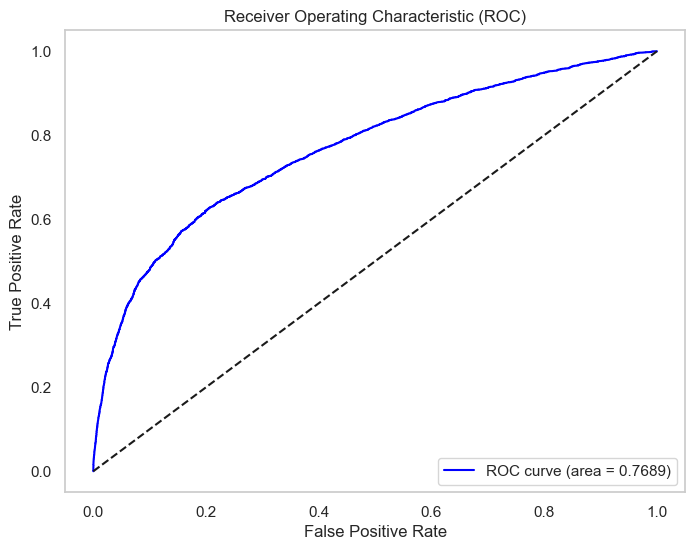

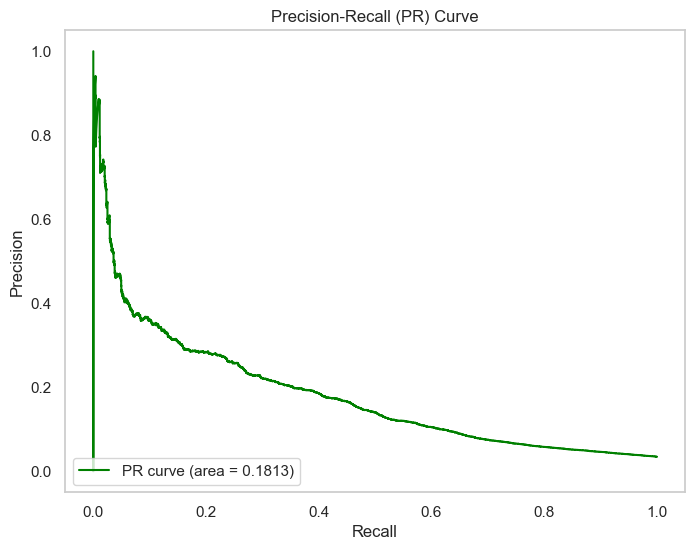

In [200]:
eval(model, X_val, y_val)

### Анализ метрик и графиков для модели Random Forest Classifier с настроенными гиперпараметрами

#### Метрики

- **Recall: 0.0054**
  - Все еще очень низкий уровень полноты, модель практически не выявляет положительные случаи.
  
- **ROC-AUC: 0.7689**
  - Улучшение по сравнению с предыдущими результатами, модель лучше отличает классы.

- **PR-AUC: 0.1813**
  - Значительное улучшение по сравнению с предыдущими моделями.

#### ROC-кривая

- **Форма кривой:**
  - Более отдаленная от диагонали, чем в предыдущих примерах, что говорит о лучшем распознавании классов.

#### PR-кривая

- **Форма кривой:**
  - Резкий спад precision при увеличении recall, но кривая все же улучшилась.

# Выводы


| Метрика  | Logistic Regression | Random Forest (стандартный) | Random Forest (оптимизированный) |
|----------|---------------------|-----------------------------|----------------------------------|
| Recall   | 0.0000              | 0.0327                      | 0.0054                           |
| ROC-AUC  | 0.6917              | 0.7037                      | 0.7689                           |
| PR-AUC   | 0.0976              | 0.0934                      | 0.1813                           |



### Общий вывод по таблице метрик

1. **Recall:**
   - **Logistic Regression** имеет самый низкий recall (0.0000), не идентифицируя положительные случаи.
   - **Стандартный Random Forest** показал небольшой прирост в recall (0.0327).
   - **Оптимизированный Random Forest** достиг значения recall в 0.0054, что выше, чем у Logistic Regression, но ниже по сравнению с его стандартной версией.

2. **ROC-AUC:**
   - **Оптимизированный Random Forest** имеет наивысшее значение ROC-AUC (0.7689), демонстрируя лучшую способность отличать классы.
   - Остальные модели находятся ниже по этому показателю.

3. **PR-AUC:**
   - **Оптимизированный Random Forest** также лидирует по PR-AUC (0.1813), что свидетельствует о более эффективном соотношении precision к recall.

### Заключение

- **Оптимизированный Random Forest** показал улучшение по большинству метрик, особенно в ROC-AUC и PR-AUC, показывая лучшую способность различать классы.
- **Logistic Regression** сталкивается с трудностями в обнаружении положительных случаев.
- Для улучшения можно применить дополнительные методы работы с дисбалансом классов, тюнинг порогов и усиление признаков.